In [9]:
import heist
import helpers
import torch.distributions
import torch

import gym
import random
import numpy as np
from helpers import generate_action, load_model
from procgen import ProcgenGym3Env
import imageio
import matplotlib.pyplot as plt
import typing
import math

from procgen import ProcgenGym3Env
import struct
import typing
from typing import Tuple, Dict, Callable, List, Optional
from dataclasses import dataclass
from src.policies_modified import ImpalaCNN
from procgen_tools.procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame

from gym3 import ToBaselinesVecEnv
import seaborn as sns


%load_ext autoreload
%autoreload 2

In [152]:

env_name = "procgen:procgen-heist-v0"  

env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 

model = helpers.load_model(model_path="../model_vivid_feather_latest.pt")

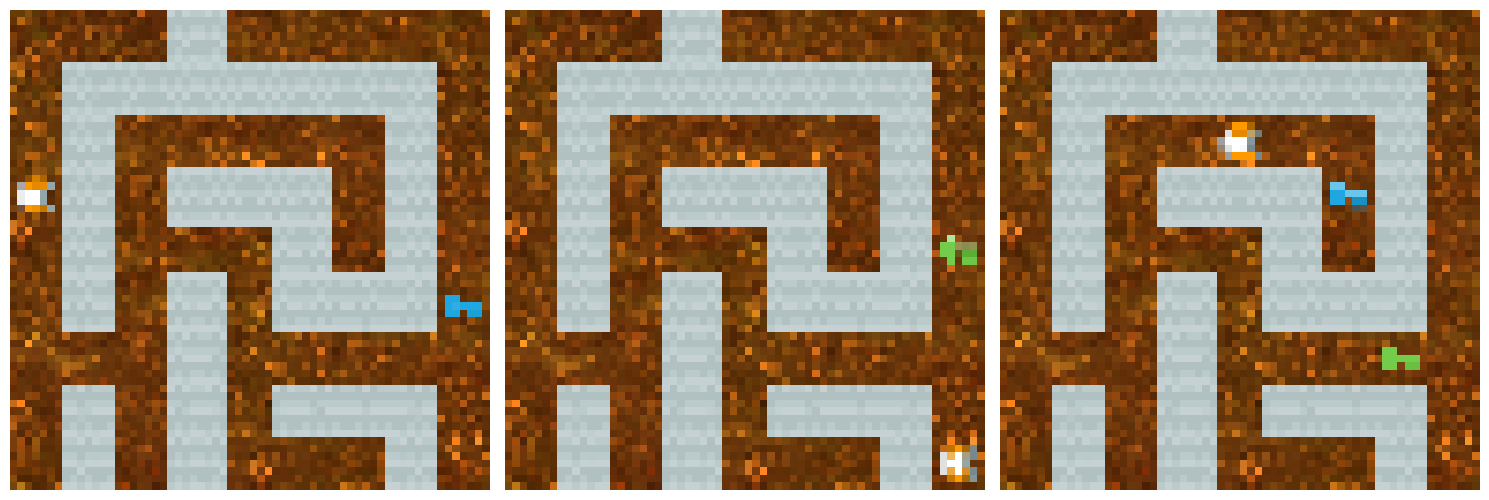

In [113]:
num_samples = 1
num_levels = 100
key_color_combinations = [['blue'], ['green'], ['blue', 'green']]
observations_list = heist.create_key_states(key_color_combinations, num_samples, num_levels)


import itertools
fig, axs = plt.subplots(1, 3, figsize=(15, 12))  # Adjusted to create a 5x3 grid
for ( j), obs in zip(itertools.product(range(3)), itertools.chain.from_iterable(observations_list)):
    axs[ j].imshow(obs.transpose(1, 2, 0))
    # axs[i, j].set_title(f"Sample {j+1}, Obs {i+1}")
    axs[j].axis('off')
plt.tight_layout()
plt.show()

In [114]:
layer_paths = [
    'conv_seqs.0.conv',
    'conv_seqs.0.res_block0.conv0',
    'conv_seqs.0.res_block0.conv1',
    'conv_seqs.0.res_block1.conv0',
    'conv_seqs.0.res_block1.conv1',
    'conv_seqs.1.conv',
    'conv_seqs.1.res_block0.conv0',
    'conv_seqs.1.res_block0.conv1',
    'conv_seqs.1.res_block1.conv0',
    'conv_seqs.1.res_block1.conv1',
    'conv_seqs.2.conv',
    'conv_seqs.2.res_block0.conv0',
    'conv_seqs.2.res_block0.conv1',
    'conv_seqs.2.res_block1.conv0',
    'conv_seqs.2.res_block1.conv1',
]

In [115]:

blue_key_only = observations_list[0][0]
green_key_only = observations_list[0][1]
blue_and_green_key = observations_list[0][2]

obs1 = torch.tensor(blue_key_only, dtype=torch.float32)
obs2 = torch.tensor(blue_and_green_key, dtype=torch.float32)

output1, blue_key_only_activations = model_activations.run_with_cache(obs1, layer_paths)
model_activations.clear_hooks()
output2, blue_and_green_key_activations = model_activations.run_with_cache(obs2, layer_paths)



In [153]:
save_gif_option = False  
for episode in range(1):
    venv = heist.create_venv(1,0,5)
    total_reward, frames, observations = helpers.run_episode_and_save_as_gif(venv, model, filepath=f'episode_mod_2_{episode+1}.gif', save_gif=save_gif_option, is_procgen_env=True)
    print(f"Episode {episode + 1} finished with total reward: {total_reward}")

Episode 1 finished with total reward: [10.]


In [ ]:
observation = torch.tensor(observations[0], dtype=torch.float32).unsqueeze(0)
output1, normal_activations = model_activations.run_with_cache(observation, layer_paths)

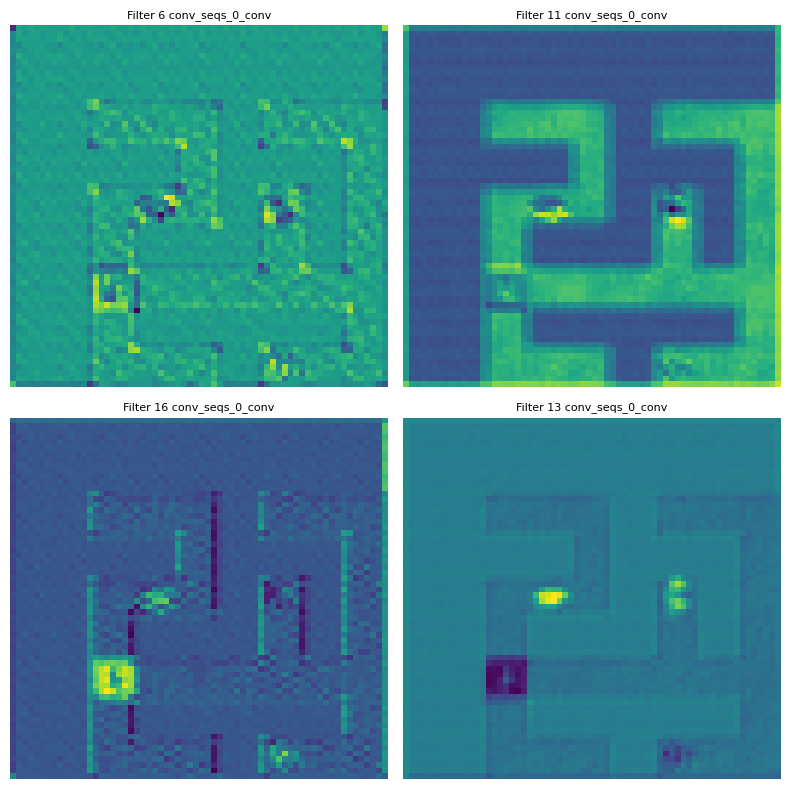

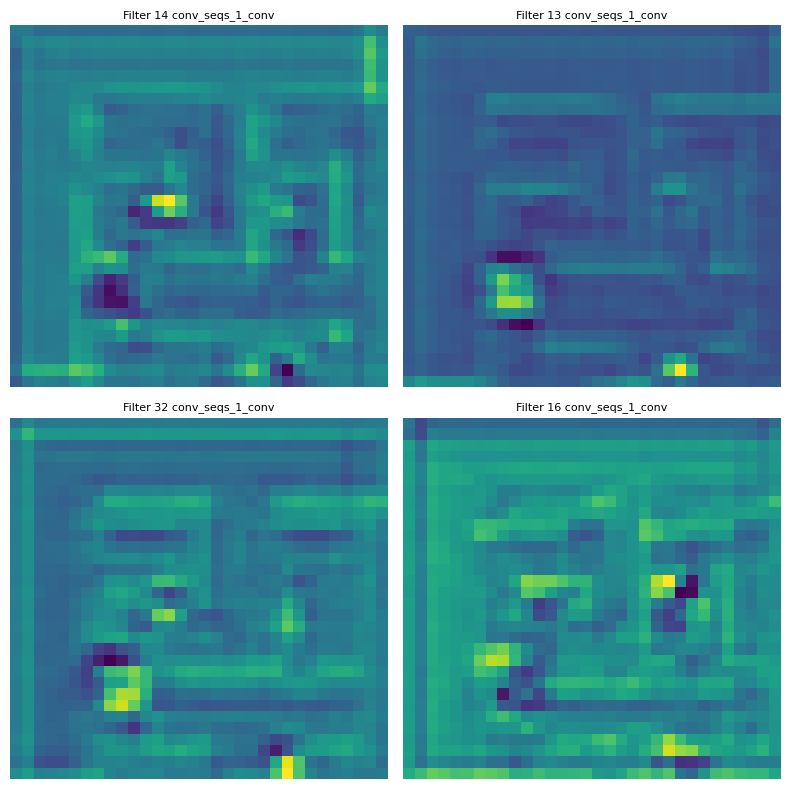

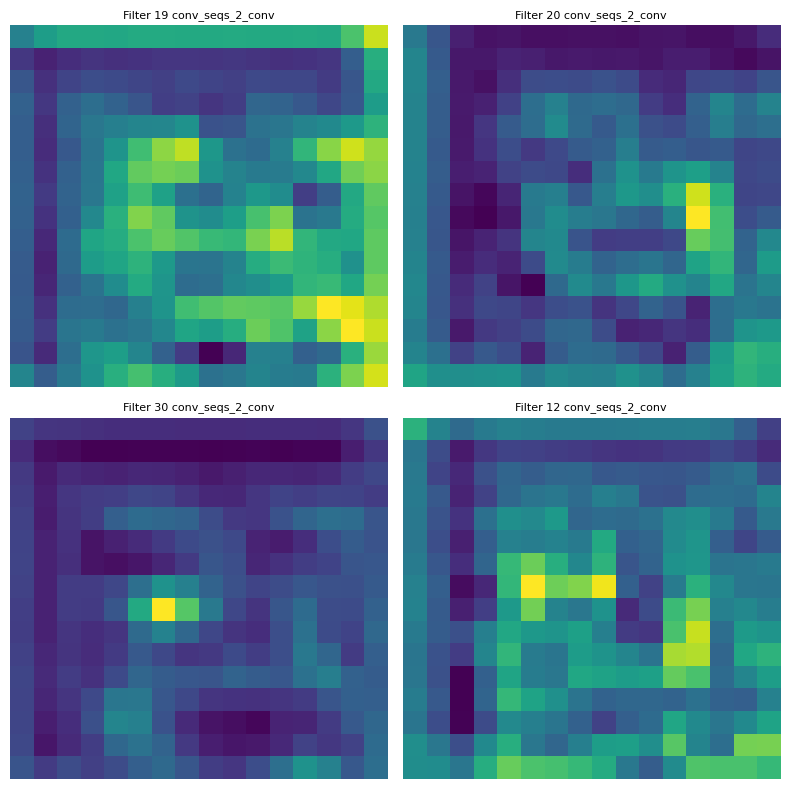

In [ ]:
helpers.plot_four_activations_for_layers(normal_activations, ["conv_seqs_0_conv", "conv_seqs_1_conv",  "conv_seqs_2_conv"] )


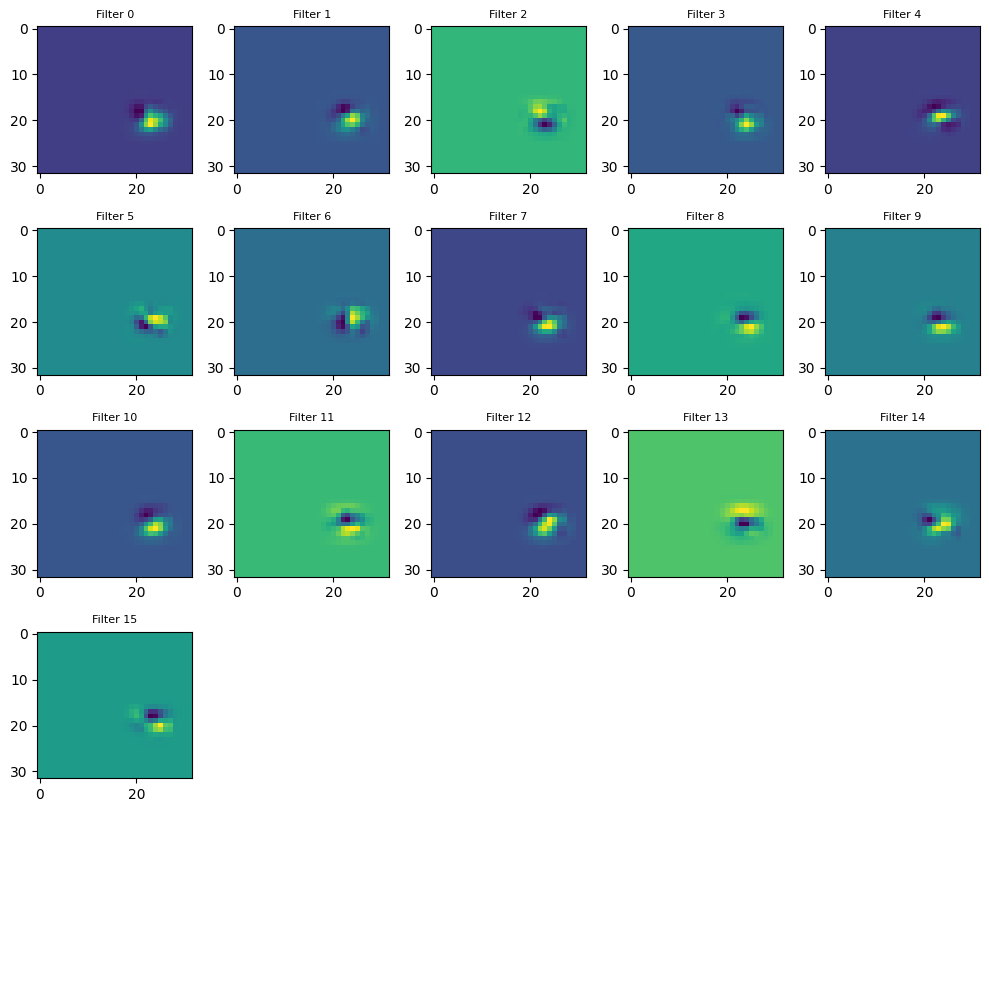

In [ ]:
helpers.plot_layer_activations_dynamic_grid(differences, "conv_seqs_0_res_block1_conv1")


# Compare activations in intepretable vs default model

In [ ]:
venv = heist.create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=num_levels)
state = heist.state_from_venv(venv, 0)

full_grid = state.full_grid(with_mouse=False)
entities = state.state_vals["ents"]
legal_mouse_positions = heist.get_legal_mouse_positions(full_grid, entities)

unchanged_obs= venv.reset()


state.remove_all_entities()

x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
entities = state.state_vals["ents"]
# state.set_key_position(0,x,y) 
entities = state.state_vals["ents"]
x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
state.set_mouse_pos(x,y)
entities = state.state_vals["ents"]
x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
state.set_gem_position(x,y)
state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    obs = venv.reset()

In [ ]:
helpers.plot_single_observation(unchanged_obs.squeeze().transpose(1,2,0))

NameError: name 'unchanged_obs' is not defined

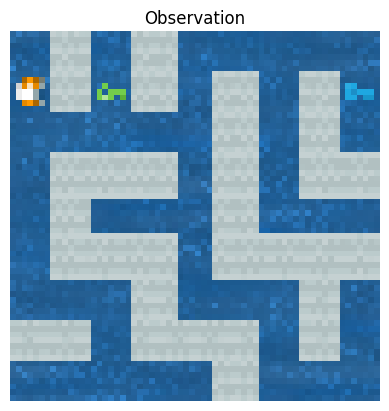

In [ ]:
helpers.plot_single_observation(obs.squeeze().transpose(1,2,0))


In [ ]:
from src.policies_impala import ImpalaCNN
less_interpretable_model = helpers.load_model(ImpalaCNN, "../model_vivid_feather_latest.pt", )
less_interpretable_model_layer_paths = helpers.get_model_layer_names(less_interpretable_model)
model_activations = ModelActivations(less_interpretable_model)
output2, gem_only_activations = model_activations.run_with_cache(helpers.observation_to_rgb(obs), less_interpretable_model_layer_paths)
# output2, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb( unchanged_obs), less_interpretable_model_layer_paths)


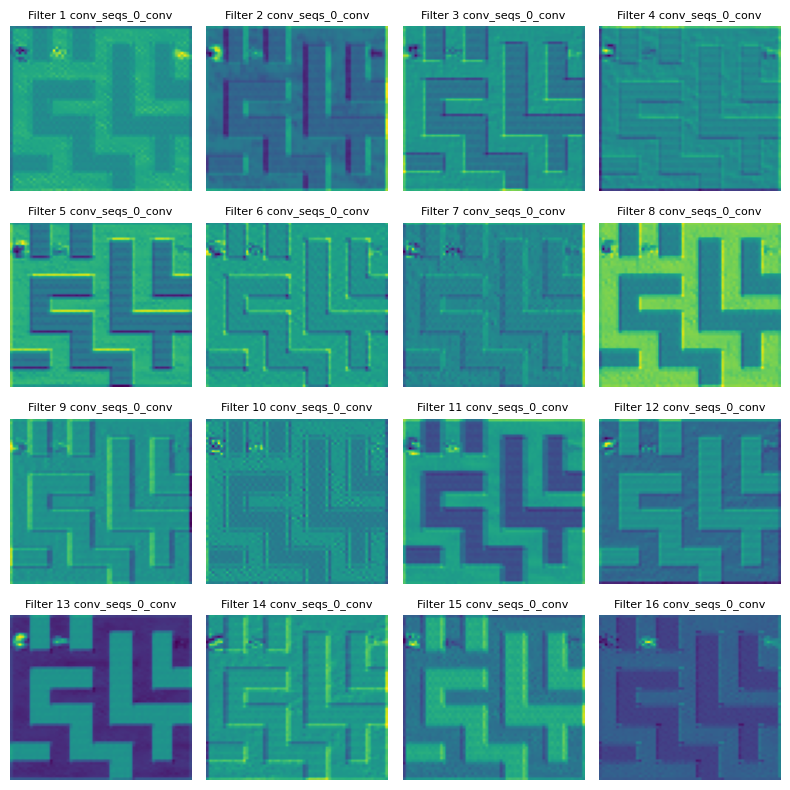

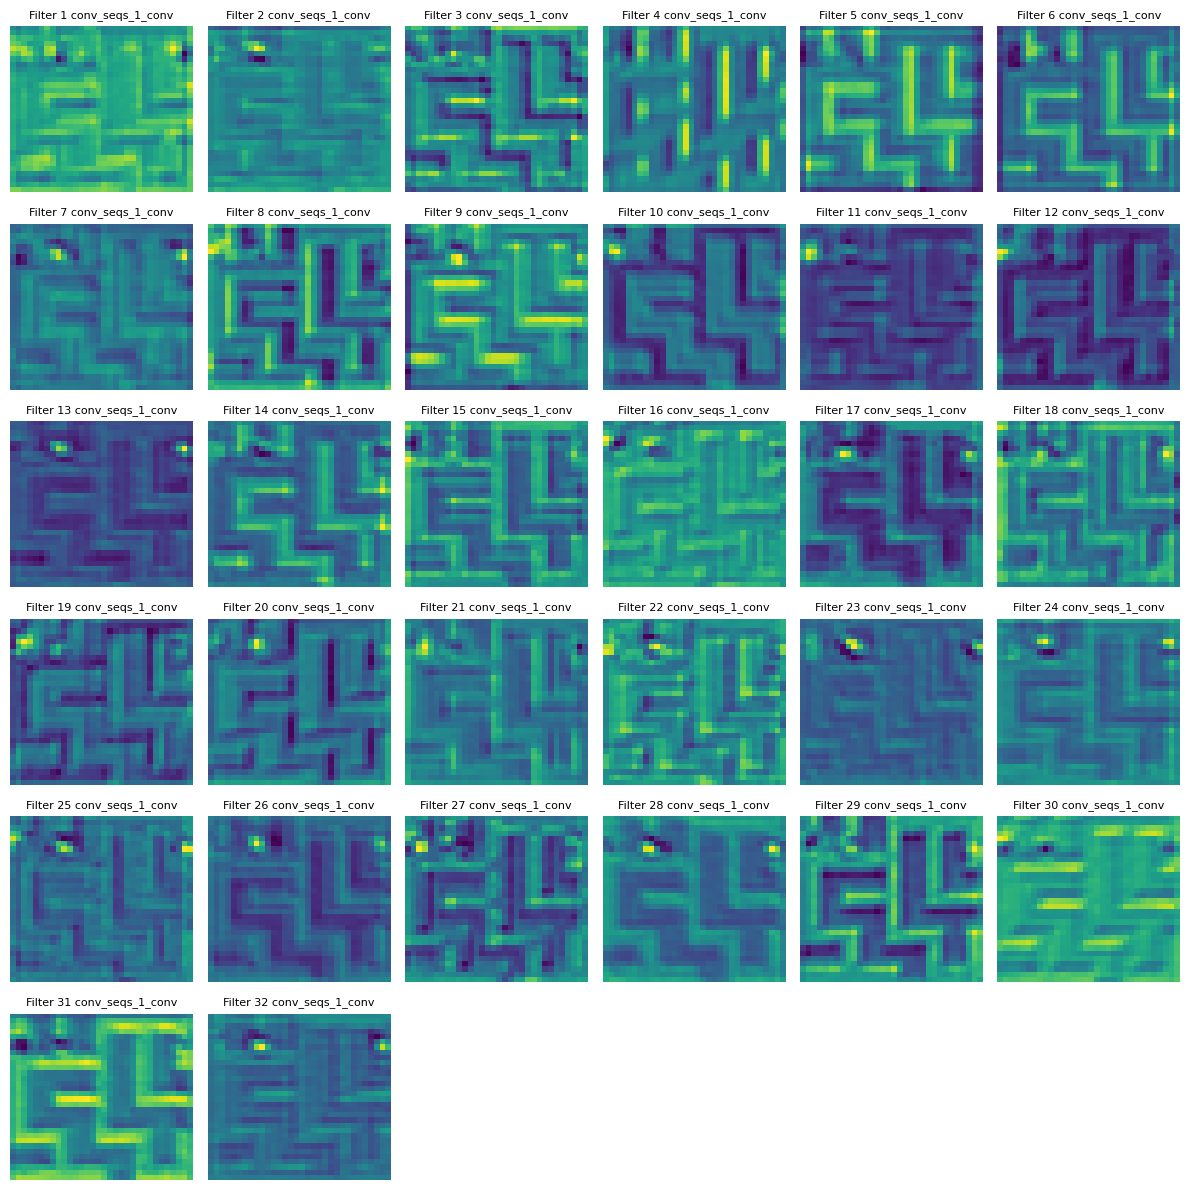

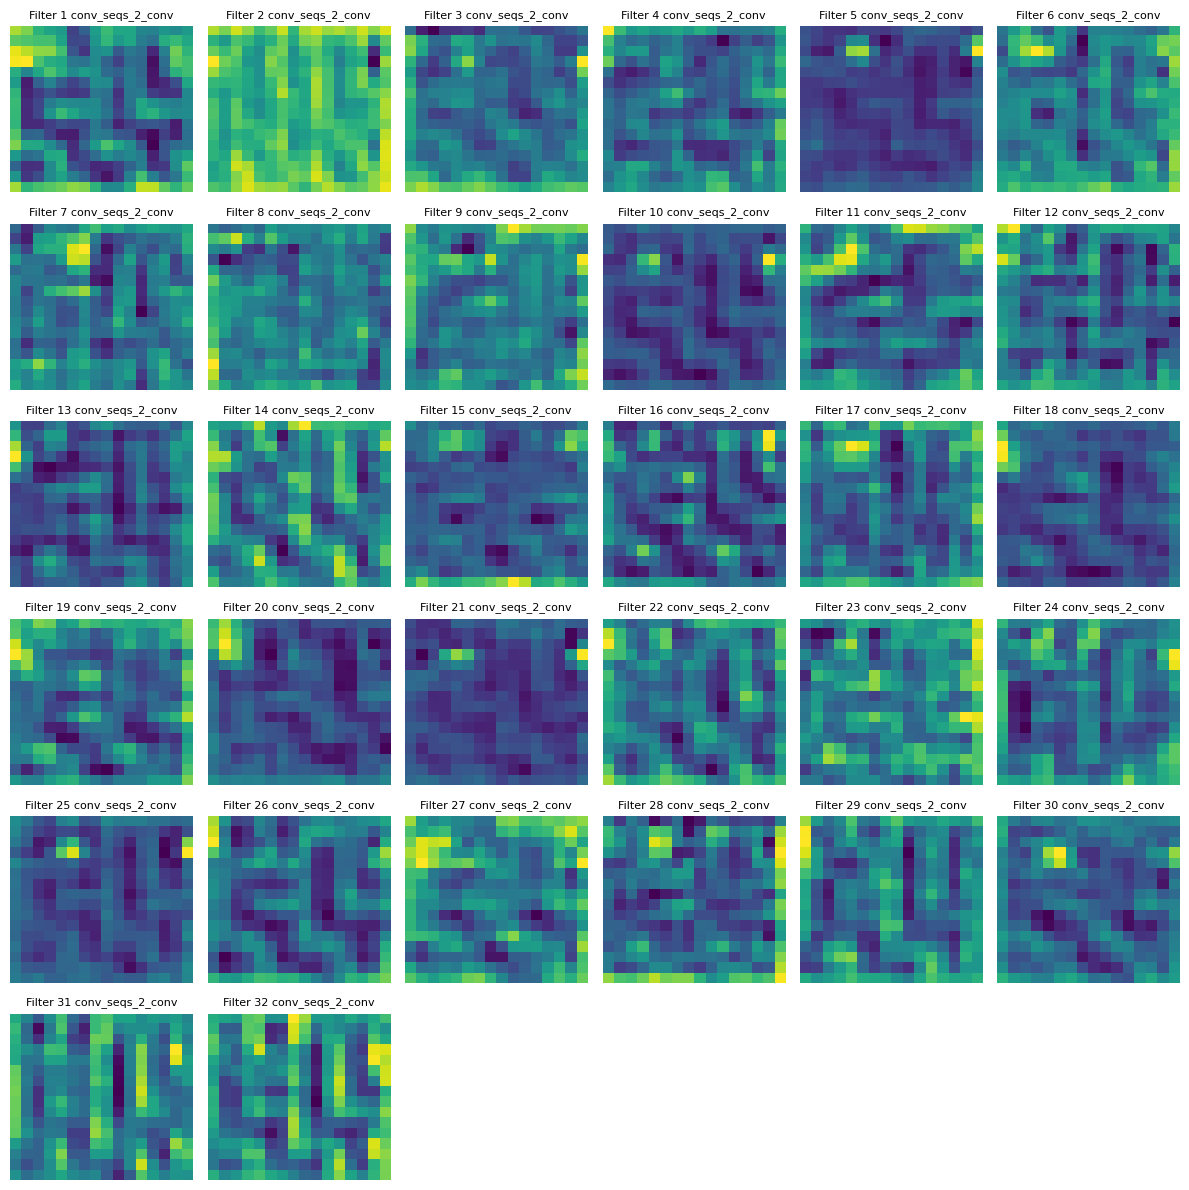

In [ ]:
helpers.plot_activations_for_layers(gem_only_activations, ["conv_seqs_0_conv", "conv_seqs_1_conv", "conv_seqs_2_conv"] )

# Interpretable model activations

In [ ]:
from src.policies_impala import ImpalaCNN
# model = helpers.load_model(ImpalaCNN,"../model_1501.0_interpretable.pt")
model = helpers.load_model(ImpalaCNN, "../model_501_copper_wave.pt" )
interp_model_activations =  ModelActivations(model)
interpretable_model_layer_paths = helpers.get_model_layer_names(model)
output2, player_gem_activations_interp = interp_model_activations.run_with_cache(helpers.observation_to_rgb(obs), interpretable_model_layer_paths)
output2, unmodified_activations_interp = interp_model_activations.run_with_cache(helpers.observation_to_rgb( unchanged_obs), interpretable_model_layer_paths)

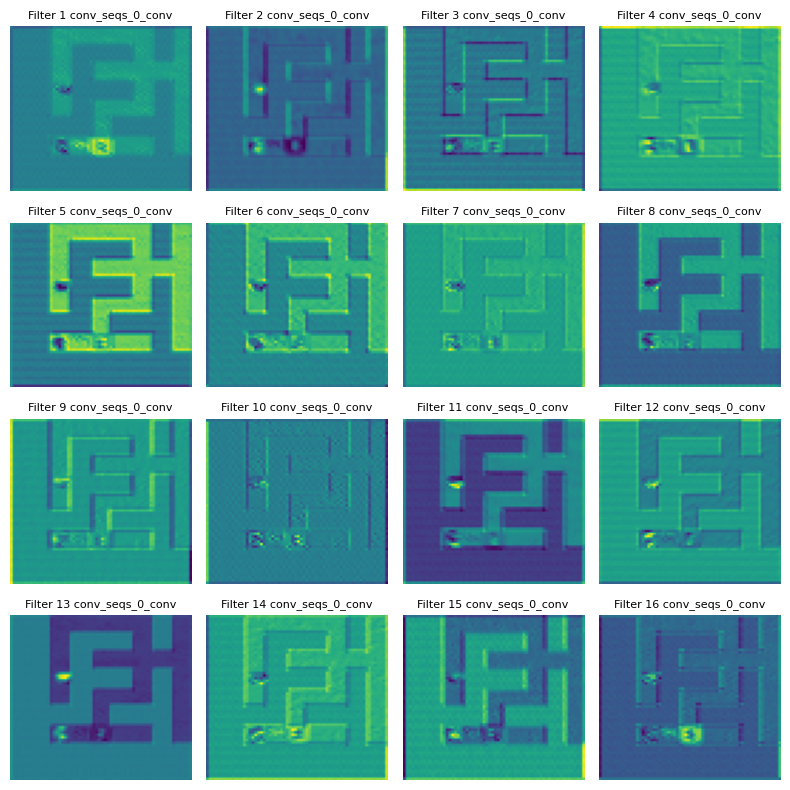

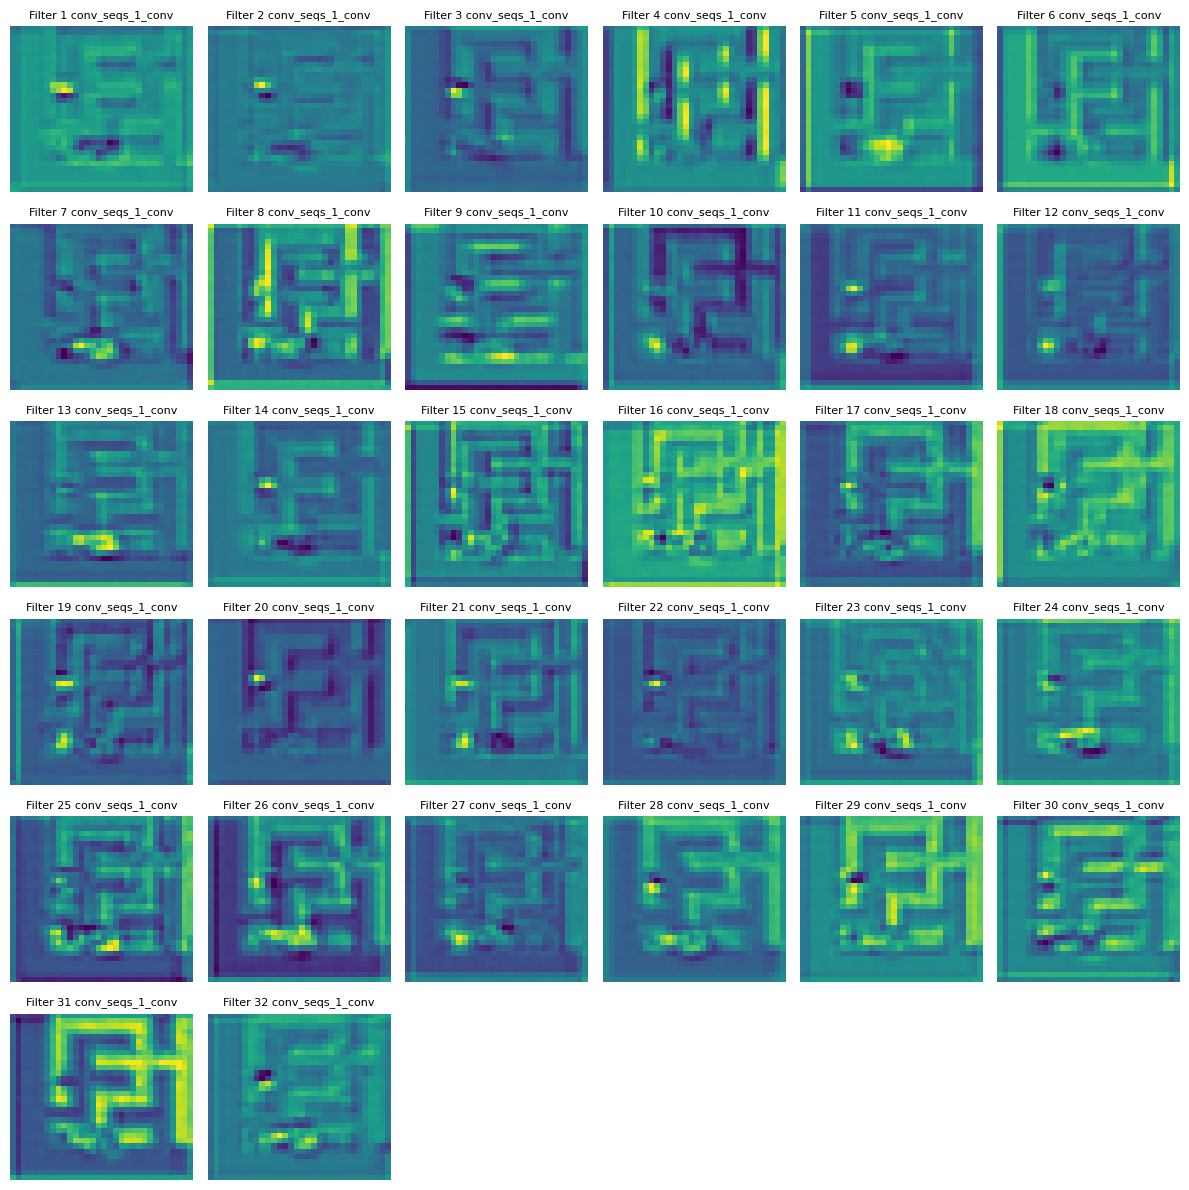

In [ ]:
helpers.plot_activations_for_layers(unmodified_activations_interp, ["conv_seqs_0_conv", "conv_seqs_1_conv"] )

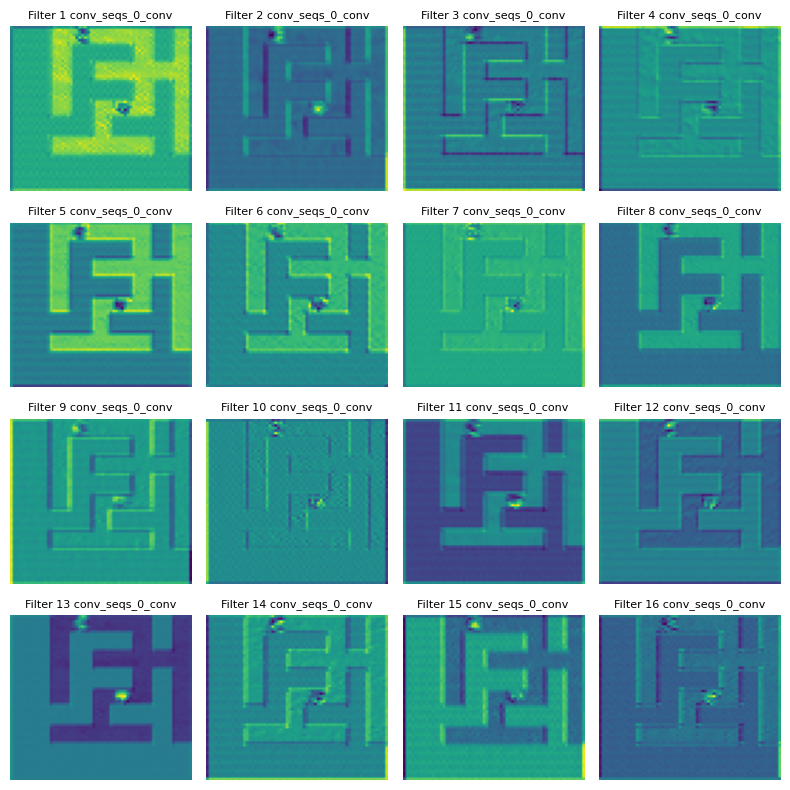

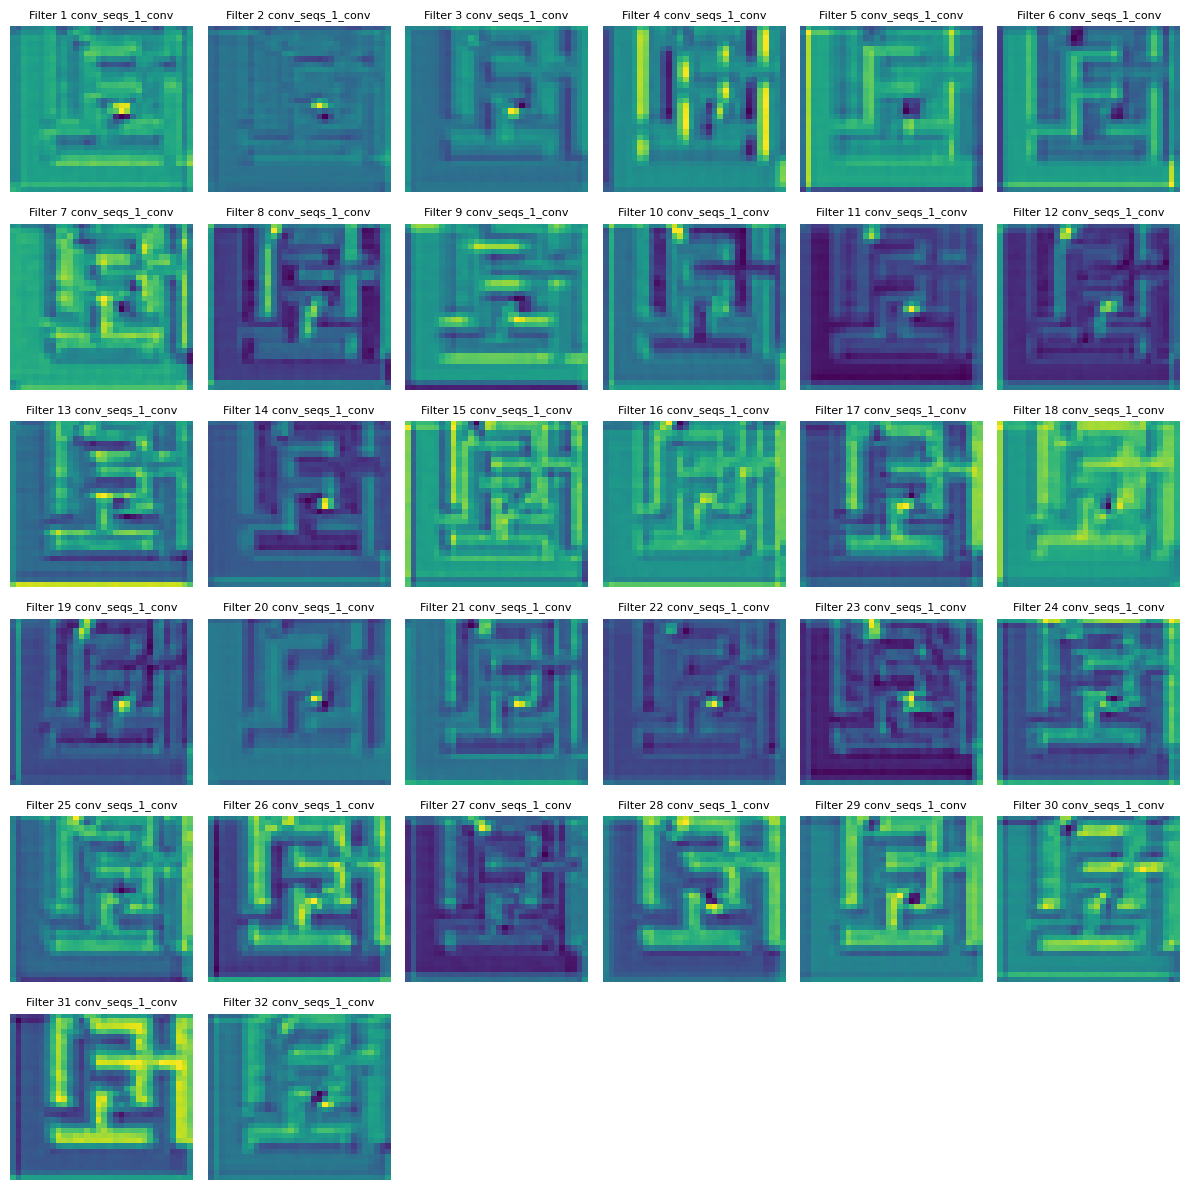

In [ ]:
helpers.plot_activations_for_layers(player_gem_activations_interp, ["conv_seqs_0_conv", "conv_seqs_1_conv"] )


In [ ]:
venv = heist.create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=num_levels)
state = heist.state_from_venv(venv, 0)

full_grid = state.full_grid(with_mouse=False)
entities = state.state_vals["ents"]
legal_mouse_positions = heist.get_legal_mouse_positions(full_grid, entities)

unchanged_obs= venv.reset()

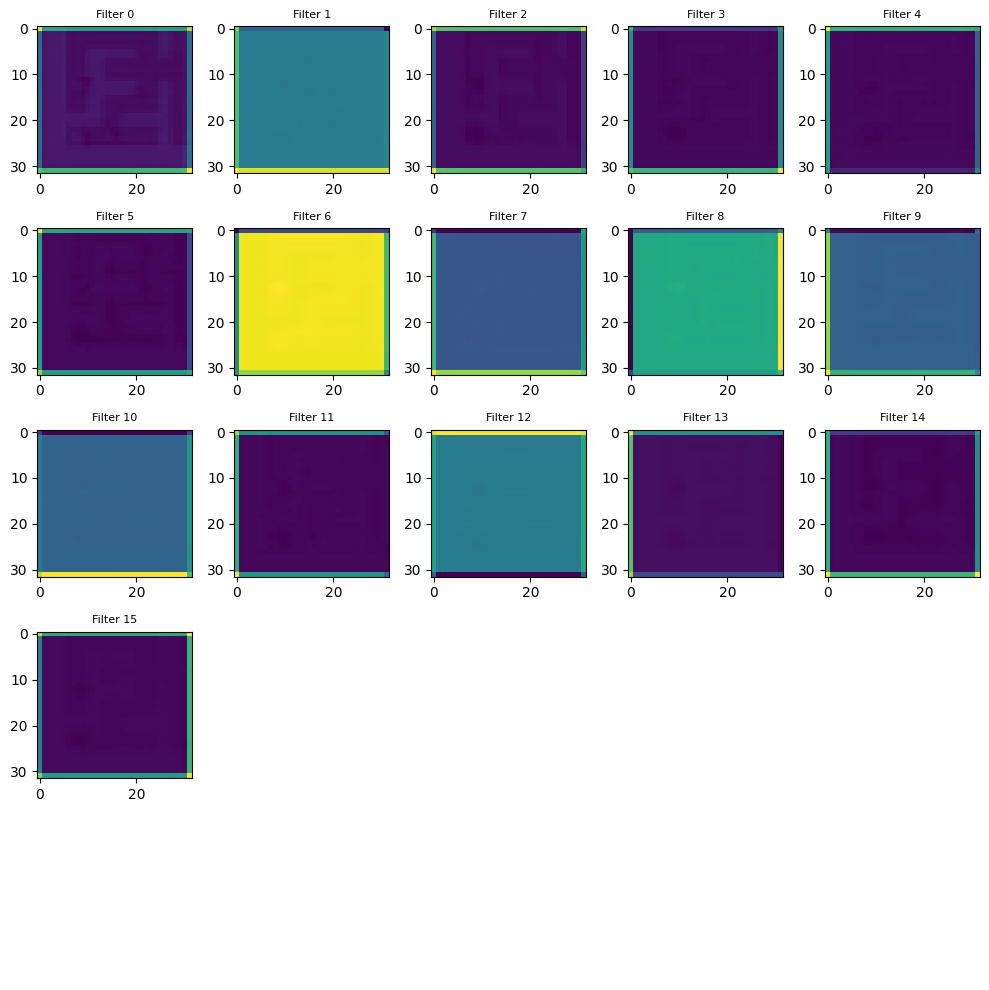

In [ ]:
venv = heist.create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=num_levels)
state = heist.state_from_venv(venv, 0)
normal_obs = venv.reset()
output2, normal_activations = model_activations.run_with_cache(normal_obs, layer_paths)
helpers.plot_layer_activations_dynamic_grid(normal_activations, "conv_seqs_0_res_block0_conv0")

In [ ]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        # Initialize a placeholder for processed output
        processed_output = []
        
        for item in output:
            # Check if the item is a tensor and detach it
            if isinstance(item, torch.Tensor):
                processed_output.append(item.detach())
            # If the item is a Categorical, you might want to extract its logits or probs
            elif isinstance(item, torch.distributions.Categorical):
                processed_output.append(item.logits.detach())
            else:
                # Handle other types as necessary
                processed_output.append(item)
        
        # Save the processed output in the activations dictionary
        activations[name] = tuple(processed_output)
    return hook



# Define a function to recursively register hooks based on a path
def register_hook_by_path(model, path, name):
    elements = path.split('.')
    for i, element in enumerate(elements):
        if '[' in element:
            # Splitting at '[' and removing the closing ']' to get the index
            base, index = element.replace(']', '').split('[')
            index = int(index)  # Convert index to integer
            model = getattr(model, base)[index]
        else:
            model = getattr(model, element)
        # If we are at the last element, register the hook
        if i == len(elements) - 1:
            model.register_forward_hook(get_activation(name))

# List of layer paths to hook, based on your initial list
layer_paths = [
    'conv_seqs.0.conv',
    'conv_seqs.0.res_block0.conv0',
    'conv_seqs.0.res_block0.conv1',
    'conv_seqs.0.res_block1.conv0',
    'conv_seqs.0.res_block1.conv1',
    'conv_seqs.1.conv',
    'conv_seqs.1.res_block0.conv0',
    'conv_seqs.1.res_block0.conv1',
    'conv_seqs.1.res_block1.conv0',
    'conv_seqs.1.res_block1.conv1',
    'conv_seqs.2.conv',
    'conv_seqs.2.res_block0.conv0',
    'conv_seqs.2.res_block0.conv1',
    'conv_seqs.2.res_block1.conv0',
    'conv_seqs.2.res_block1.conv1',
    # Add other layers as needed
]


# Register hooks for each path
for path in layer_paths:
    register_hook_by_path(model, path, path.replace('.', '_'))


observation = torch.tensor(normal_obs, dtype=torch.float32)


# if observation.shape == torch.Size([3, 64, 64]):
observation = observation.permute(0,3, 2, 1)  # Switch dimensions to (64, 64, 3)

output = model(observation)


In [ ]:
observation_test = torch.tensor(observations[0], dtype=torch.float32).unsqueeze(0)
observation_test.shape

torch.Size([1, 64, 64, 3])

In [ ]:

def run_episode_and_save_as_gif(env, model, filepath='../gifs/run.gif', save_gif=False, episode_timeout=400, is_procgen_env=False):

    observations = []
    observation = env.reset()
    done = False
    total_reward = 0
    frames=[]
    
    
    activations = {}
    # observation = colour_swap(observation)
    count = 0
    while not done:
        if save_gif:
            frames.append(env.render(mode='rgb_array'))  
        observation= np.squeeze(observation)
        observation =np.transpose(observation, (1,2,0))
        converted_obs = helpers.observation_to_rgb(observation)
        action = helpers.generate_action(model, converted_obs, is_procgen_env) 
        observation, reward, done, info = env.step(action)
        # observation = colour_swap(observation)
        total_reward += reward
        observations.append(converted_obs)
        count +=1
        if count >= episode_timeout:
            break

    if save_gif:
        imageio.mimsave(filepath, frames, fps=30) 

    return total_reward, frames, observations

env_name = "procgen:procgen-heist-v0"  

env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 

model = helpers.load_model()

save_gif_option = False  
for episode in range(10):
    venv = heist.create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=4)
    # env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 
    env = heist.create_venv(1,0,5)

    total_reward, frames, observations = run_episode_and_save_as_gif(env, model, filepath=f'episode_mod_2_{episode+1}_procgen2.gif', save_gif=save_gif_option, is_procgen_env=True)


[8]
[2]
[2]
[1]
[1]
[2]
[2]
[2]
[1]
[2]
[2]
[2]
[5]
[8]
Episode 1 finished with total reward: [10.]
[0]
[3]
[0]
[0]
[5]
[6]
[0]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[0]
[0]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[0]
[2]
[2]
Episode 2 finished with total reward: [10.]
[0]
[0]
[0]
[8]
[0]
[8]
[0]
[8]
[0]
[6]
[8]
[0]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[6]
[0]
[0]
[6]
[2]
[8]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[0]
[2]
[2]
Episode 3 finished with total reward: [10.]
[8]
[2]
[2]
[2]
[1]
[2]
[2]
[2]
[1]
[2]
[2]
[2]
[2]
[8]
Episode 4 finished with total reward: [10.]
[7]
[6]
[6]
[6]
[6]
[7]
[7]
[7]
[8]
[6]
[6]
[6]
[6]
[0]
[0]
[0]
[8]
[8]
[8]
[8]
[2]
[2]
[2]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[2]
[2]
[14]
[2]
[2]
[2]
[2]
[8]
[8]
Episode 5 finished with total reward: [10.]
[6]
[6]
[6]
[7]
[7]
[6]
[7]
[0]
[7]
[6]
[6]
[6]
[7]
[6]
[0]
[6]
[0]
[0]
[0]
[12]
[8]
[8]
[8]
[8]
[1]
[2]
[1]
[2]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[2]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[2]
[2]
[2]
[8]
[8]
[8]
Episode 6 finished wit

KeyboardInterrupt: 

## Procgen env notes
The above experiments confirm that the model is now working on the procgen venv once we convert the values to the right scale and below demonstrate that the activations are looking as we expect. 



In [ ]:
normal_activations.keys()

dict_keys(['conv_seqs_0_conv', 'conv_seqs_0_res_block0_conv0', 'conv_seqs_0_res_block0_conv1', 'conv_seqs_0_res_block1_conv0', 'conv_seqs_0_res_block1_conv1', 'conv_seqs_1_conv', 'conv_seqs_1_res_block0_conv0', 'conv_seqs_1_res_block0_conv1', 'conv_seqs_1_res_block1_conv0', 'conv_seqs_1_res_block1_conv1', 'conv_seqs_2_conv', 'conv_seqs_2_res_block0_conv0', 'conv_seqs_2_res_block0_conv1', 'conv_seqs_2_res_block1_conv0', 'conv_seqs_2_res_block1_conv1'])

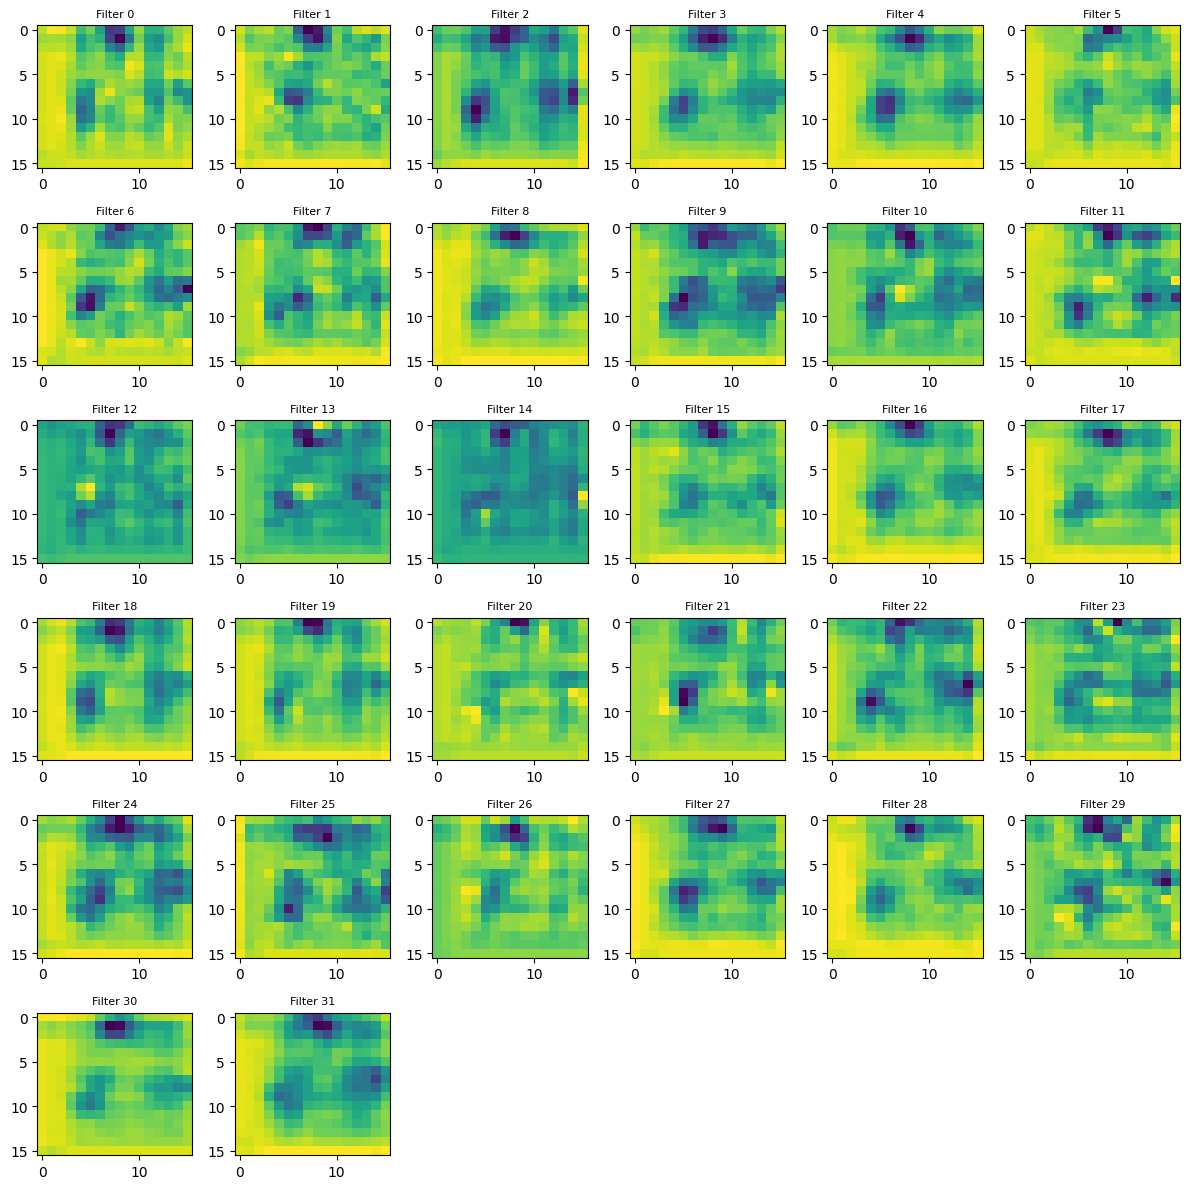

In [ ]:
helpers.plot_layer_activations_dynamic_grid(normal_activations, "conv_seqs_1_res_block0_conv0")

## Exploring key interactions without goals
To discover how the agent operates without a final goal we set up an environment with no final goal present. We can then have it run through the episode as normal and look at the gif of its performance as well as the initial activations.


In [ ]:
# num_levels = 5
# venv = heist.create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=num_levels)
# state = heist.state_from_venv(venv, 0)

# full_grid = state.full_grid(with_mouse=False)
# entities = state.state_vals["ents"]
# legal_mouse_positions = heist.get_legal_mouse_positions(full_grid, entities)

unchanged_obs= venv.reset()


state.remove_all_entities()

x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
entities = state.state_vals["ents"]
state.set_key_position(0,x,y) 
entities = state.state_vals["ents"]
x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
state.set_mouse_pos(x,y)
state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    obs = venv.reset()

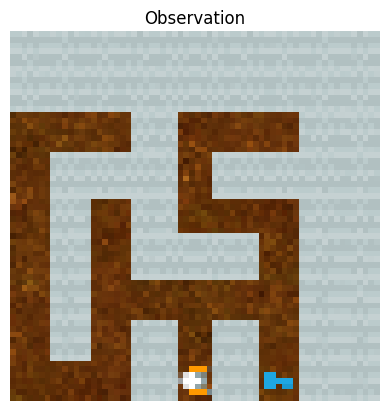

In [ ]:
helpers.plot_single_observation(obs.squeeze().transpose(1,2,0))

In [ ]:
entities = state.state_vals["ents"]
x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
state.set_gem_position(x,y)

state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    obs = venv.reset()

In [ ]:
venv[0]

TypeError: 'ScaledFloatFrame' object is not subscriptable

In [ ]:
save_gif_option = True  

model = helpers.load_model()

total_reward, frames, observations = run_episode_and_save_as_gif(venv, model, filepath=f'episode_0_key.gif', save_gif=save_gif_option, episode_timeout=150)

In [ ]:
layer_paths = [
    'conv_seqs.0.conv',
    'conv_seqs.0.res_block0.conv0',
    'conv_seqs.0.res_block0.conv1',
    'conv_seqs.0.res_block1.conv0',
    'conv_seqs.0.res_block1.conv1',
    'conv_seqs.1.conv',
    'conv_seqs.1.res_block0.conv0',
    'conv_seqs.1.res_block0.conv1',
    'conv_seqs.1.res_block1.conv0',
    'conv_seqs.1.res_block1.conv1',
    'conv_seqs.2.conv',
    'conv_seqs.2.res_block0.conv0',
    'conv_seqs.2.res_block0.conv1',
    'conv_seqs.2.res_block1.conv0',
    'conv_seqs.2.res_block1.conv1',
    # Add other layers as needed
]


model_activations = ModelActivations(model)

output2, normal_activations = model_activations.run_with_cache(observations[0], layer_paths)


torch.Size([64, 64, 3])


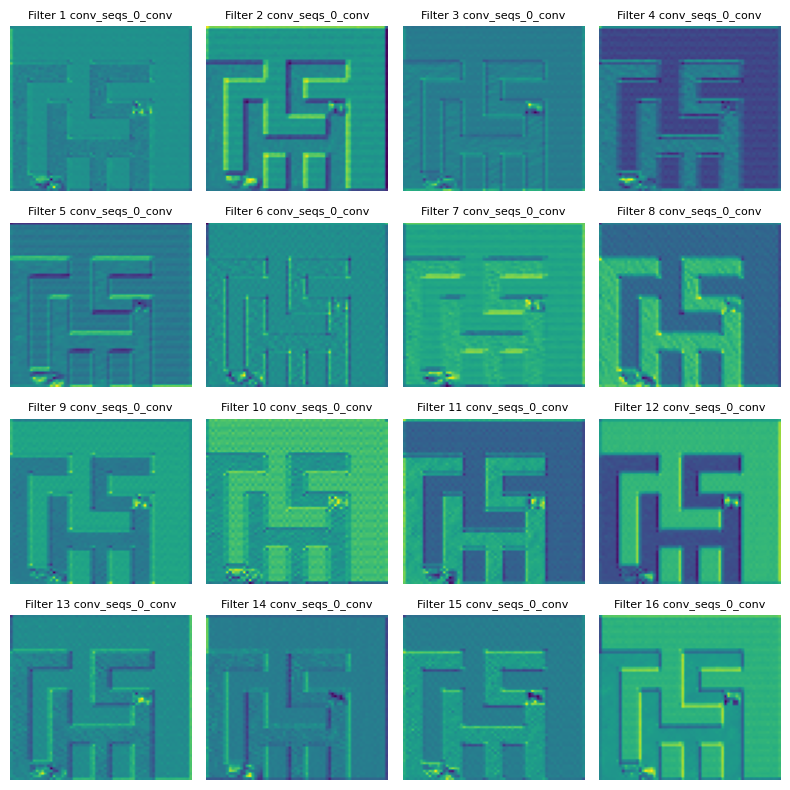

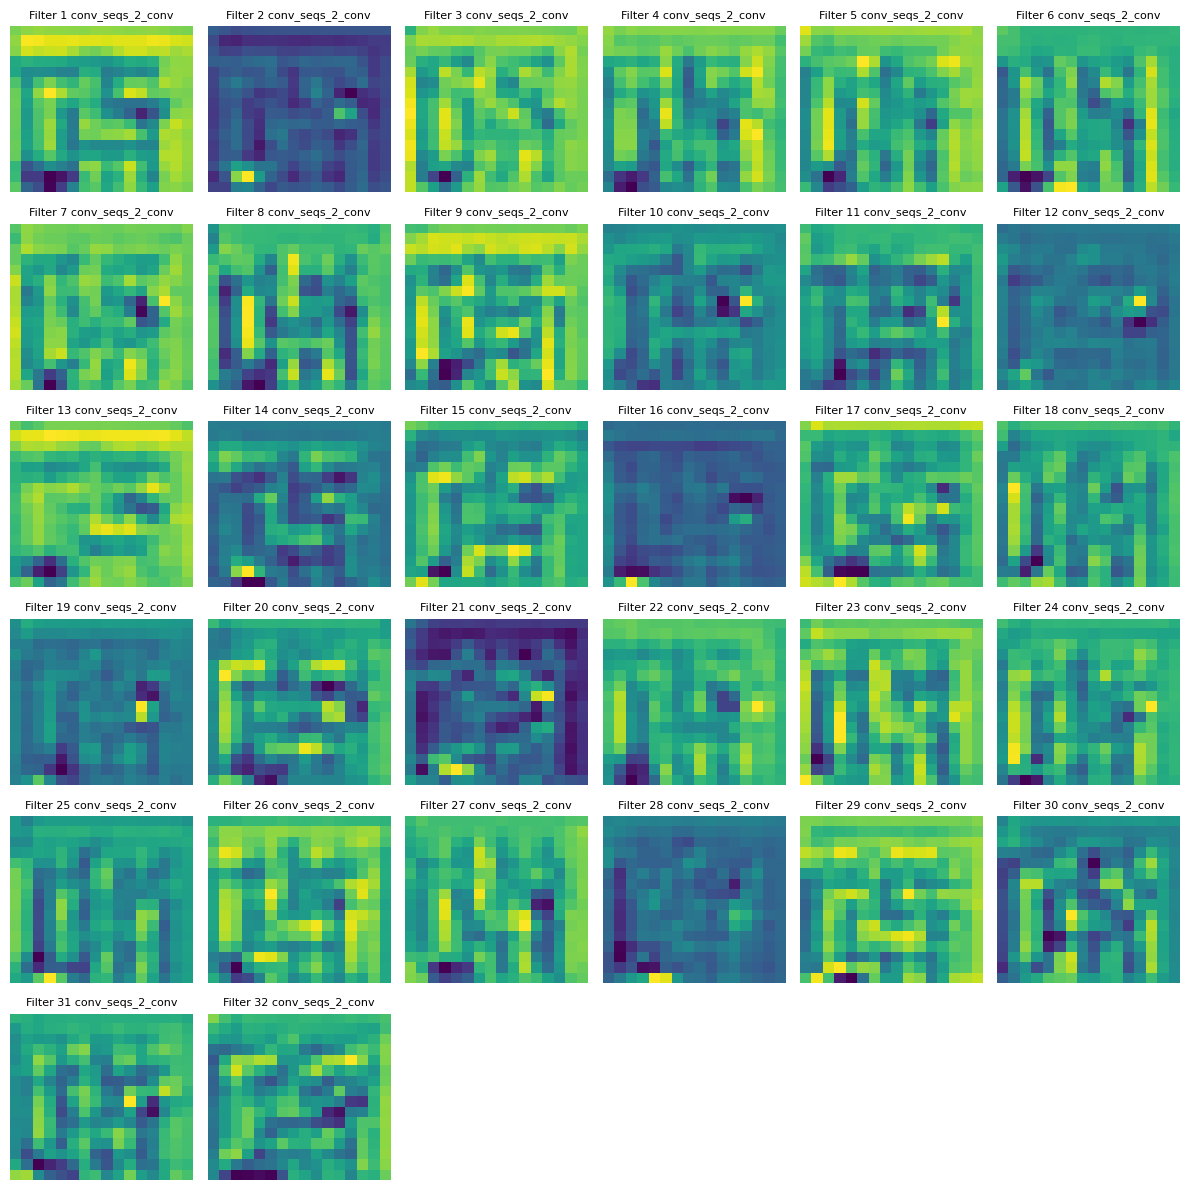

In [ ]:
helpers.plot_activations_for_layers(normal_activations, ['conv_seqs_0_conv', 'conv_seqs_2_conv'])

## Comparing activation differences between gem and blue key


In [ ]:
num_levels = 5
venv = heist.create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=num_levels)
state = heist.state_from_venv(venv, 0)

full_grid = state.full_grid(with_mouse=False)
entities = state.state_vals["ents"]
legal_mouse_positions = heist.get_legal_mouse_positions(full_grid, entities)

unchanged_obs= venv.reset()


state.remove_all_entities()

entities = state.state_vals["ents"]
target_x, target_y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
state.set_key_position(0,target_x,target_y) 
entities = state.state_vals["ents"]
x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
state.set_mouse_pos(x,y)
state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    obs = venv.reset()

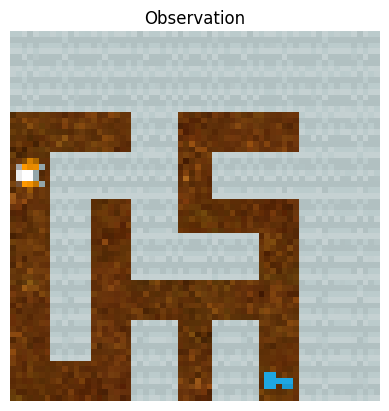

In [ ]:
# obs = venv.reset()
helpers.plot_single_observation(obs.squeeze().transpose(1,2,0))


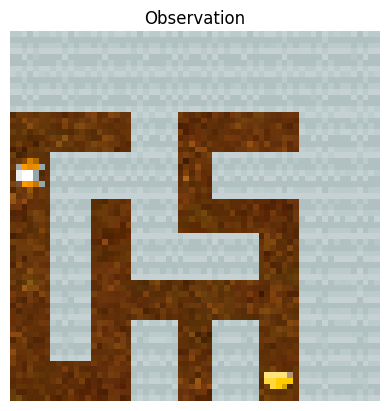

In [ ]:
state.remove_all_entities()
state.set_mouse_pos(x,y)
state.set_gem_position(target_x,target_y)
state_bytes = state.state_bytes
if state_bytes is not None:
    venv2 = venv
    venv2.env.callmethod("set_state", [state_bytes])
    obs2 = venv2.reset()

helpers.plot_single_observation(obs2.squeeze().transpose(1,2,0))

In [ ]:

output, key_activations = model_activations.run_with_cache(helpers.observation_to_rgb(obs.squeeze().transpose(1,2,0)), layer_paths)
output, gem_activations = model_activations.run_with_cache(helpers.observation_to_rgb(obs2.squeeze().transpose(1,2,0)), layer_paths)


torch.Size([64, 64, 3])
torch.Size([64, 64, 3])


In [ ]:
obs.squeeze().transpose(1,2,0).shape

(64, 64, 3)

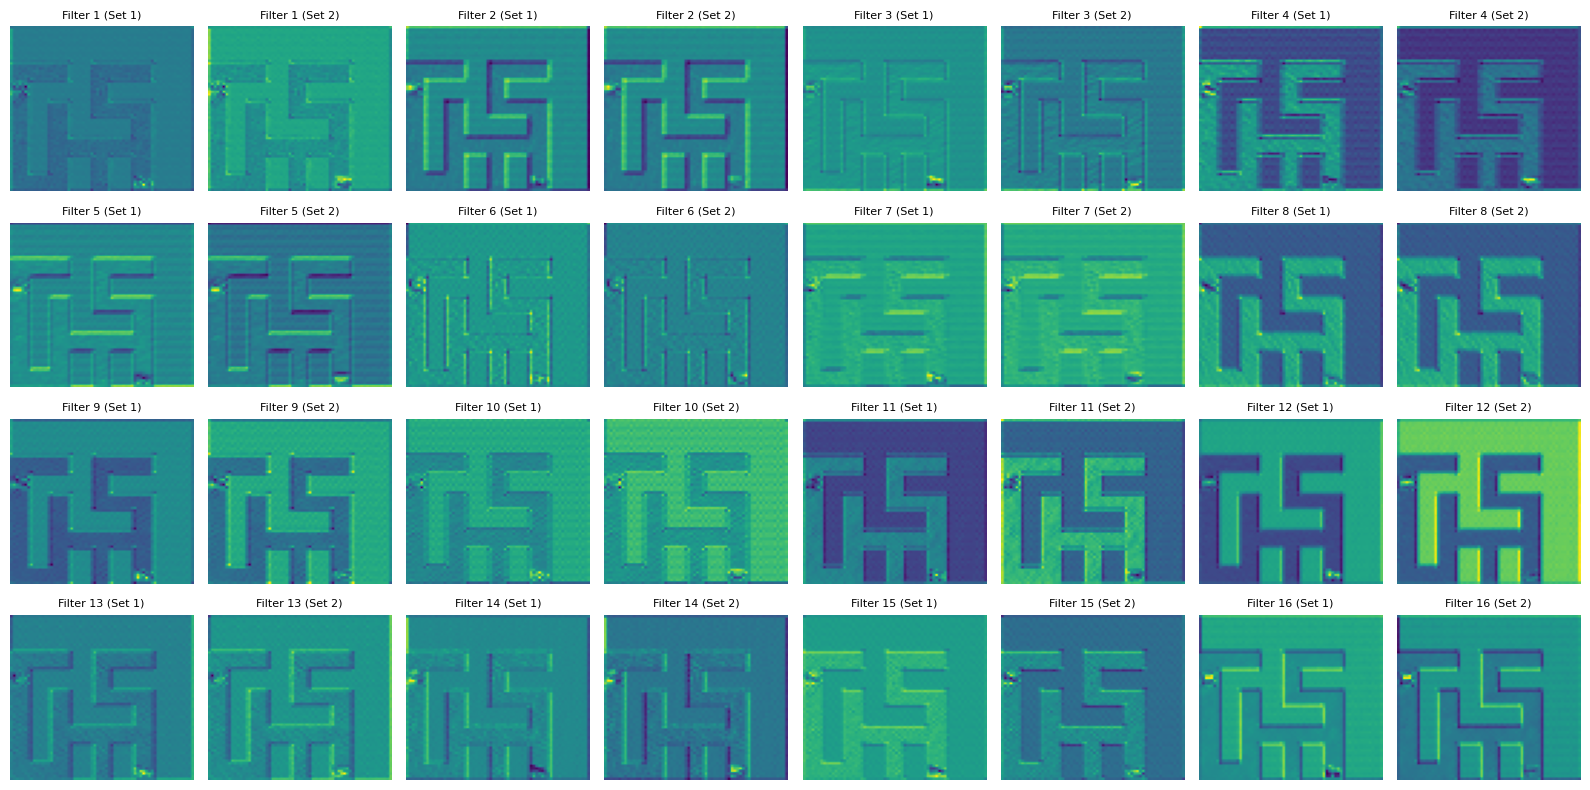

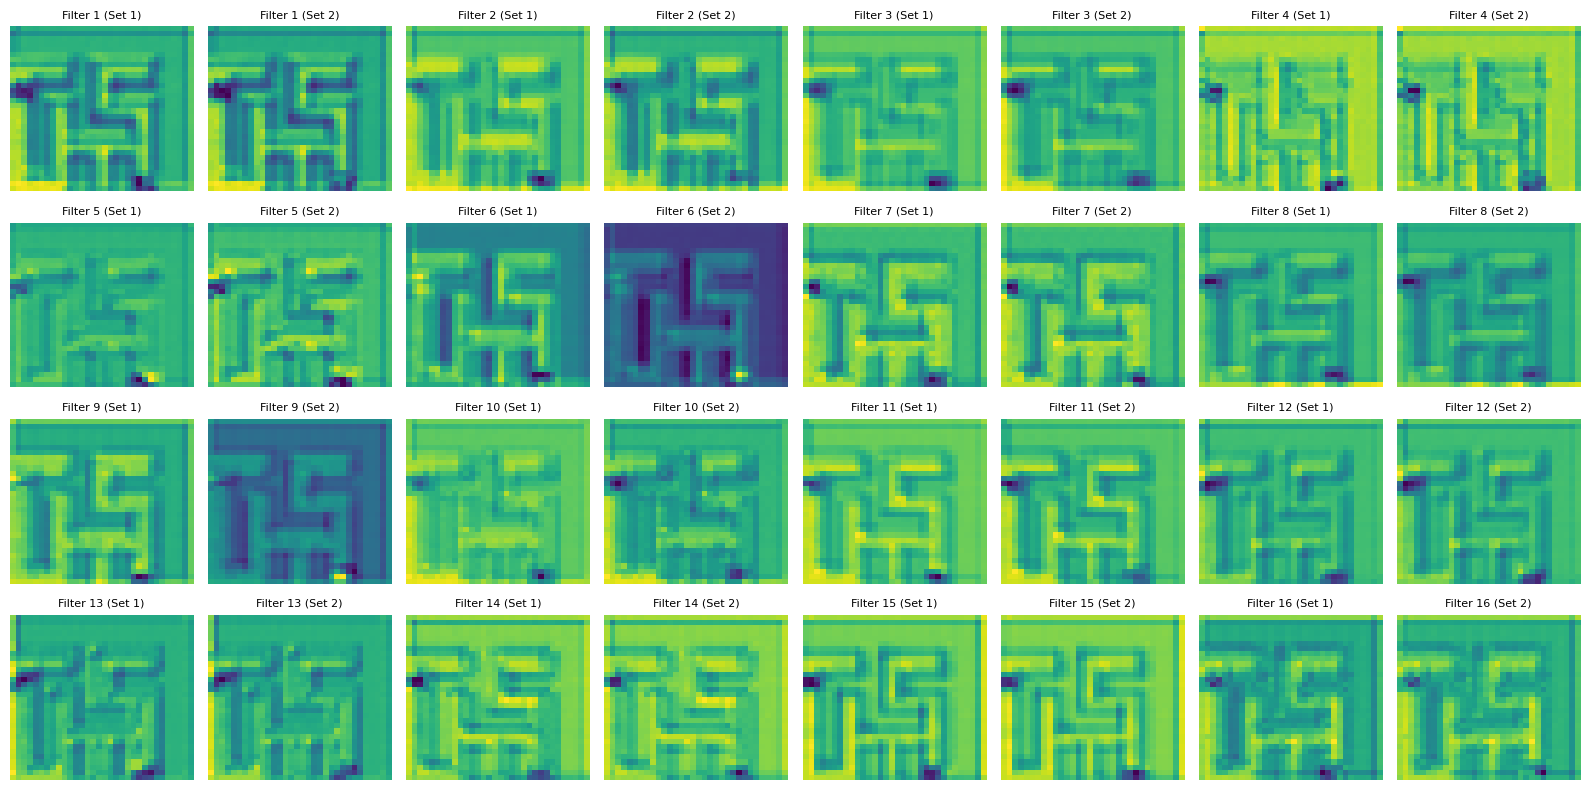

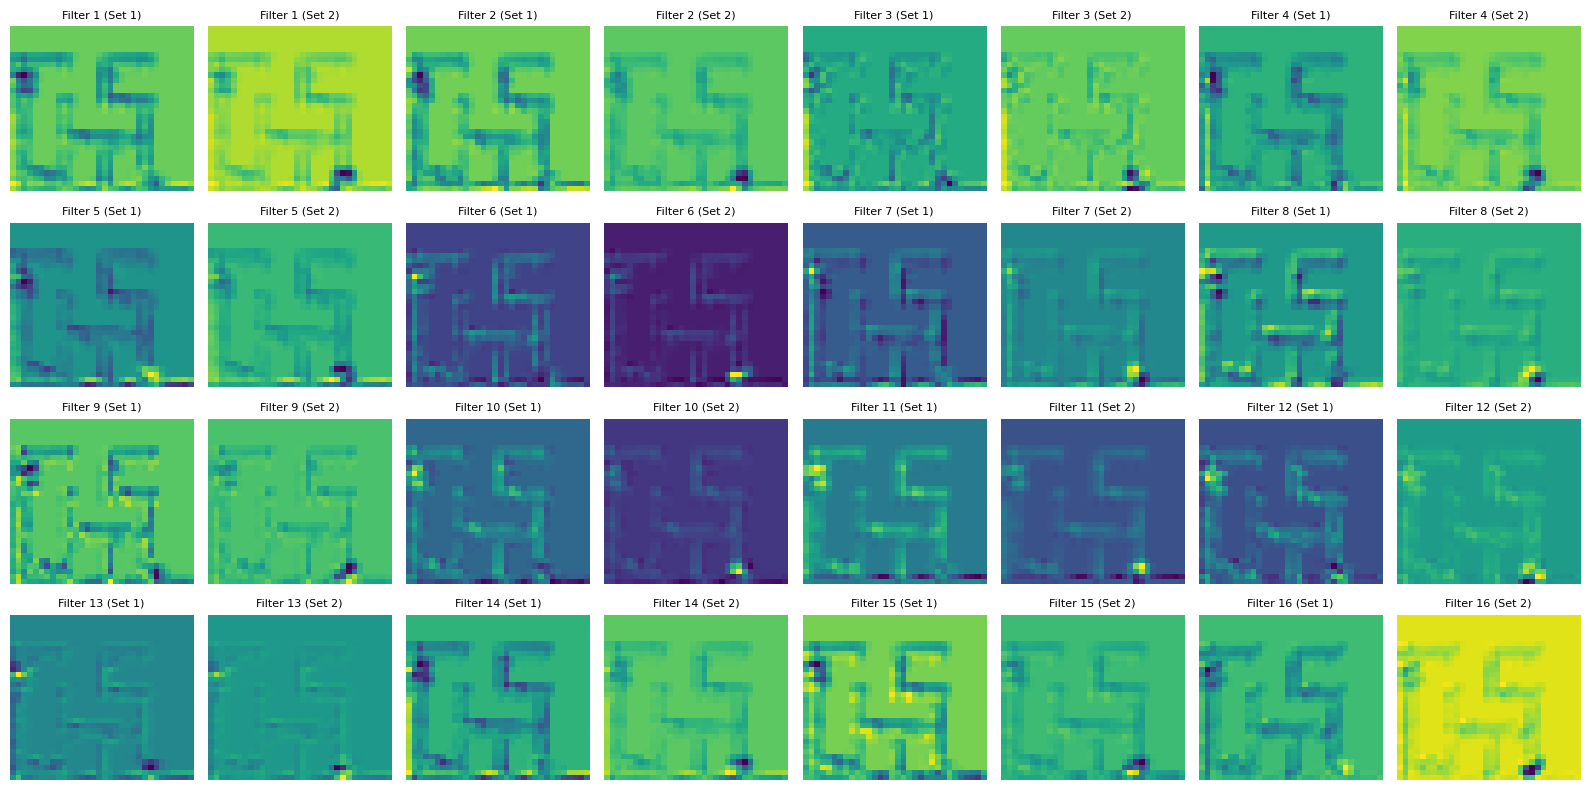

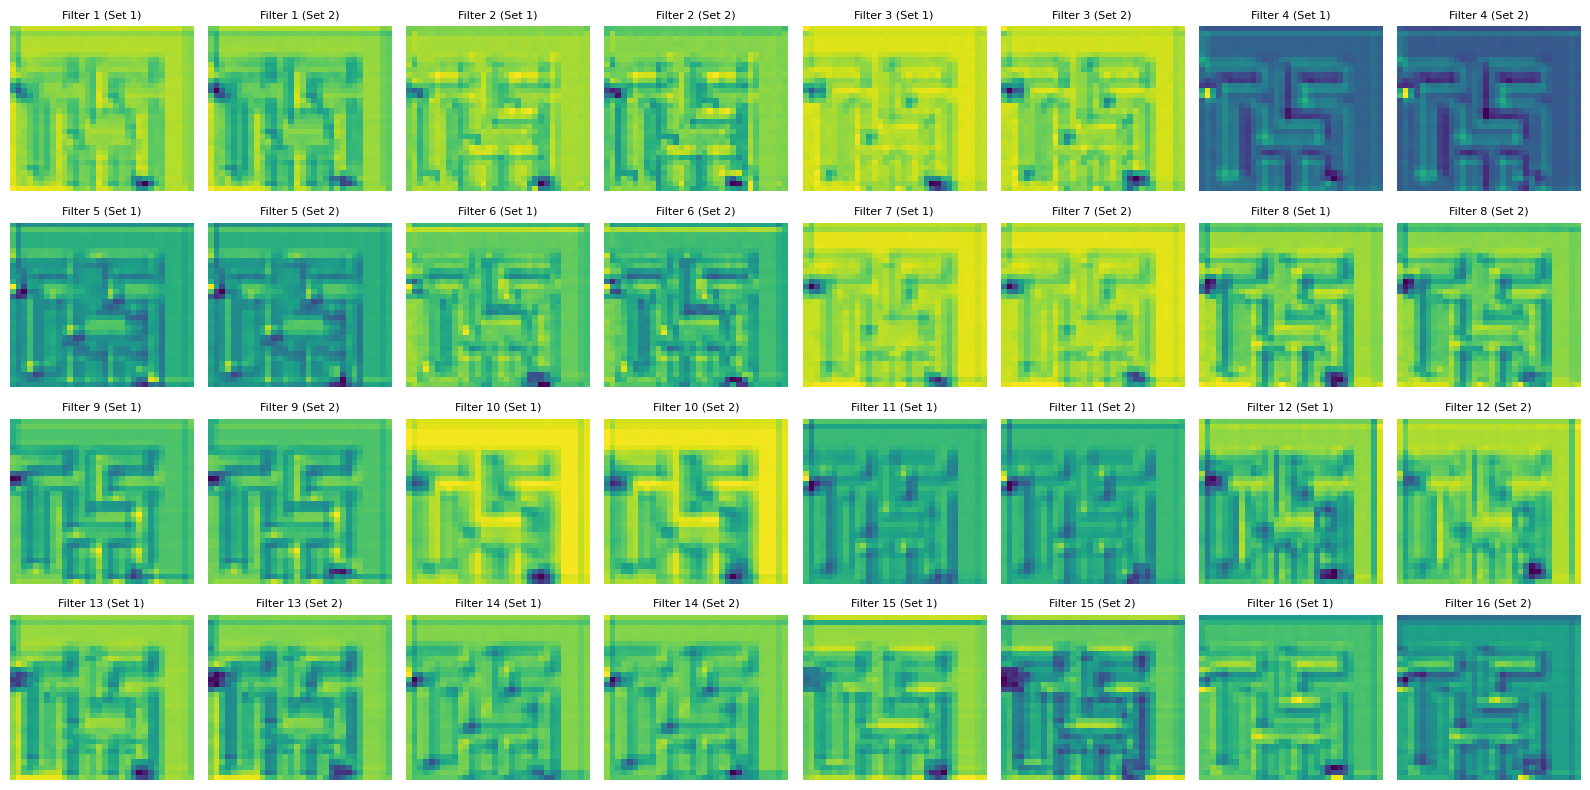

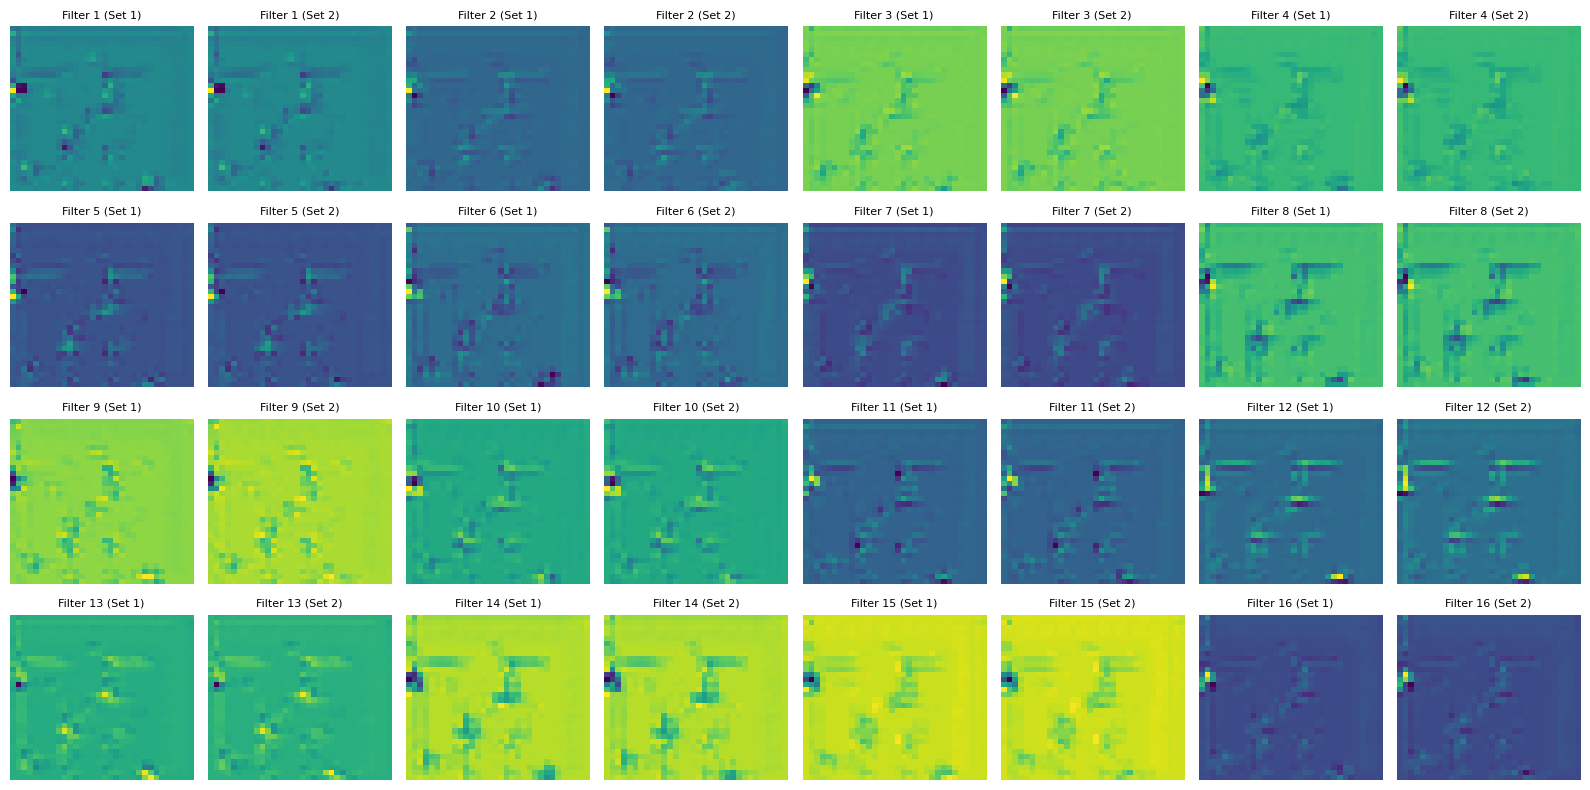

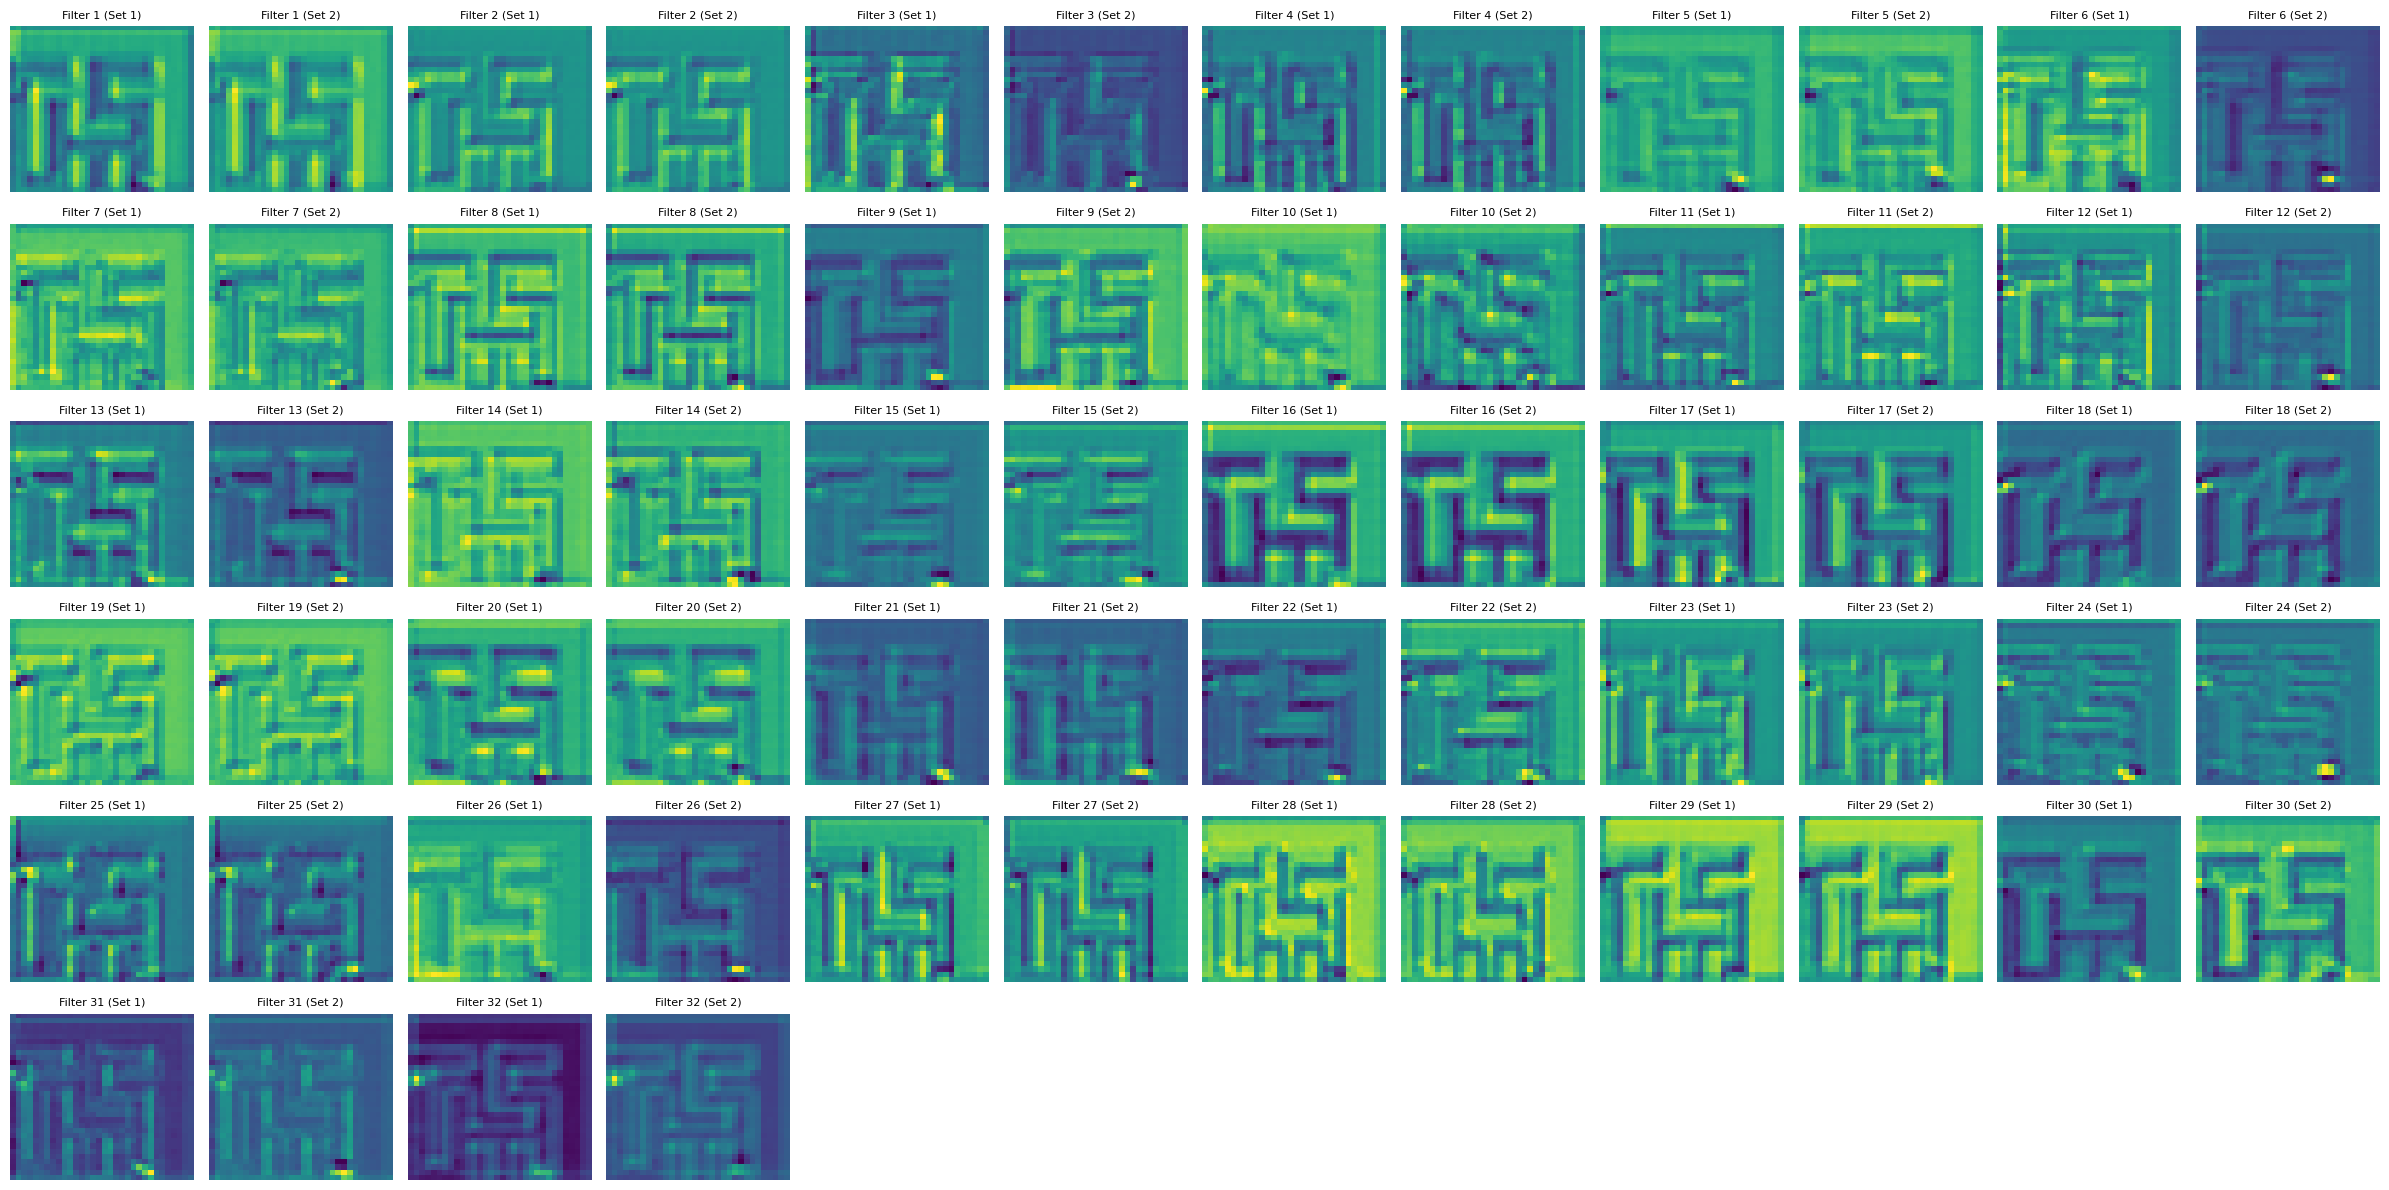

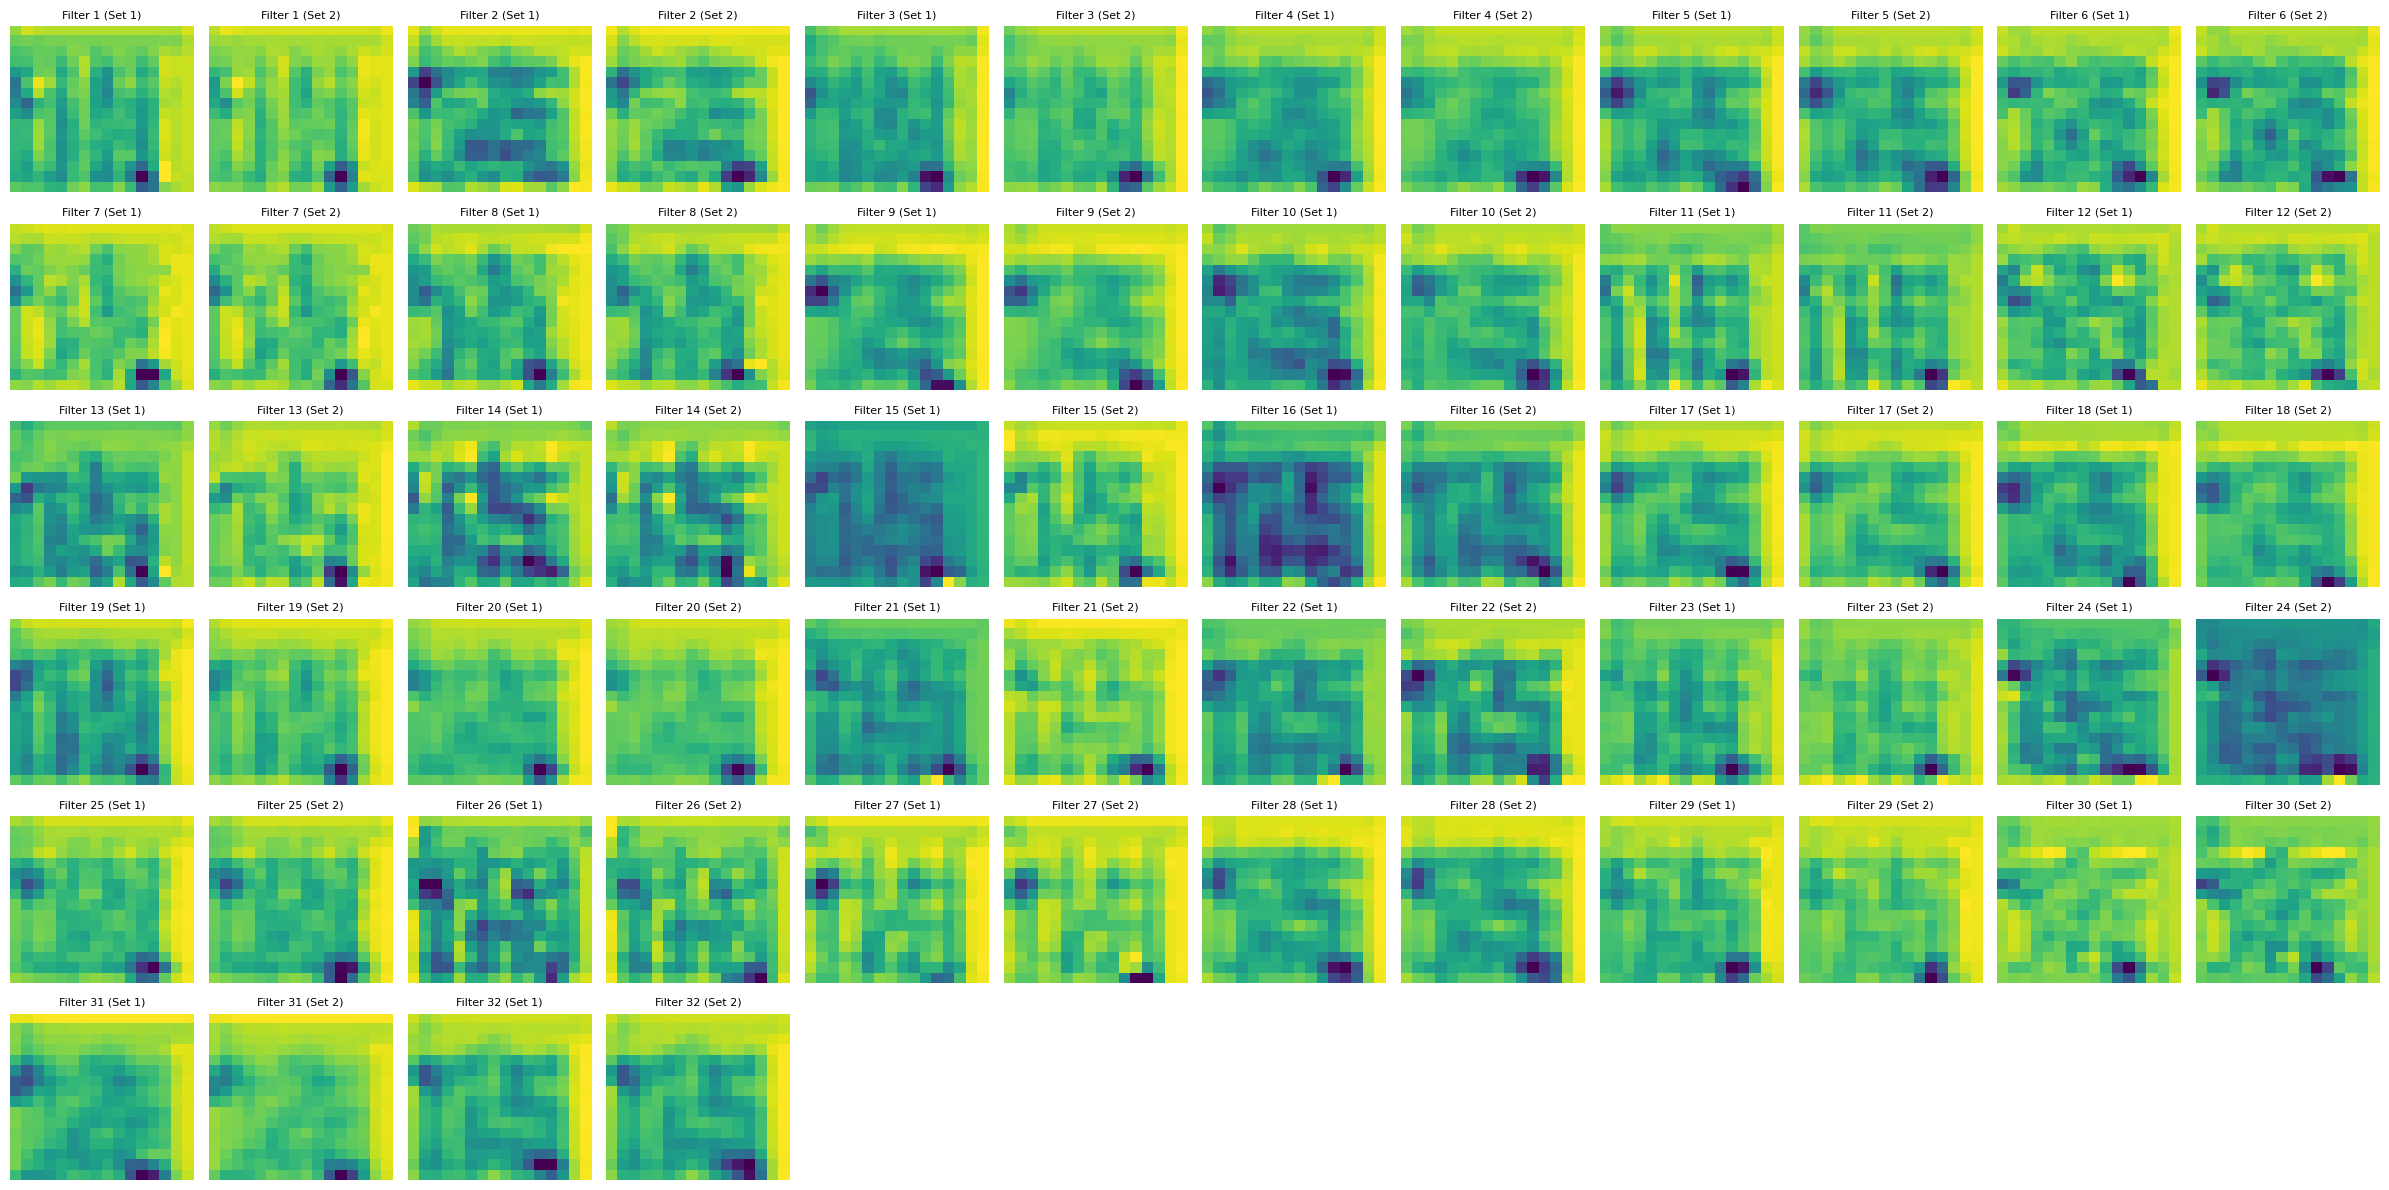

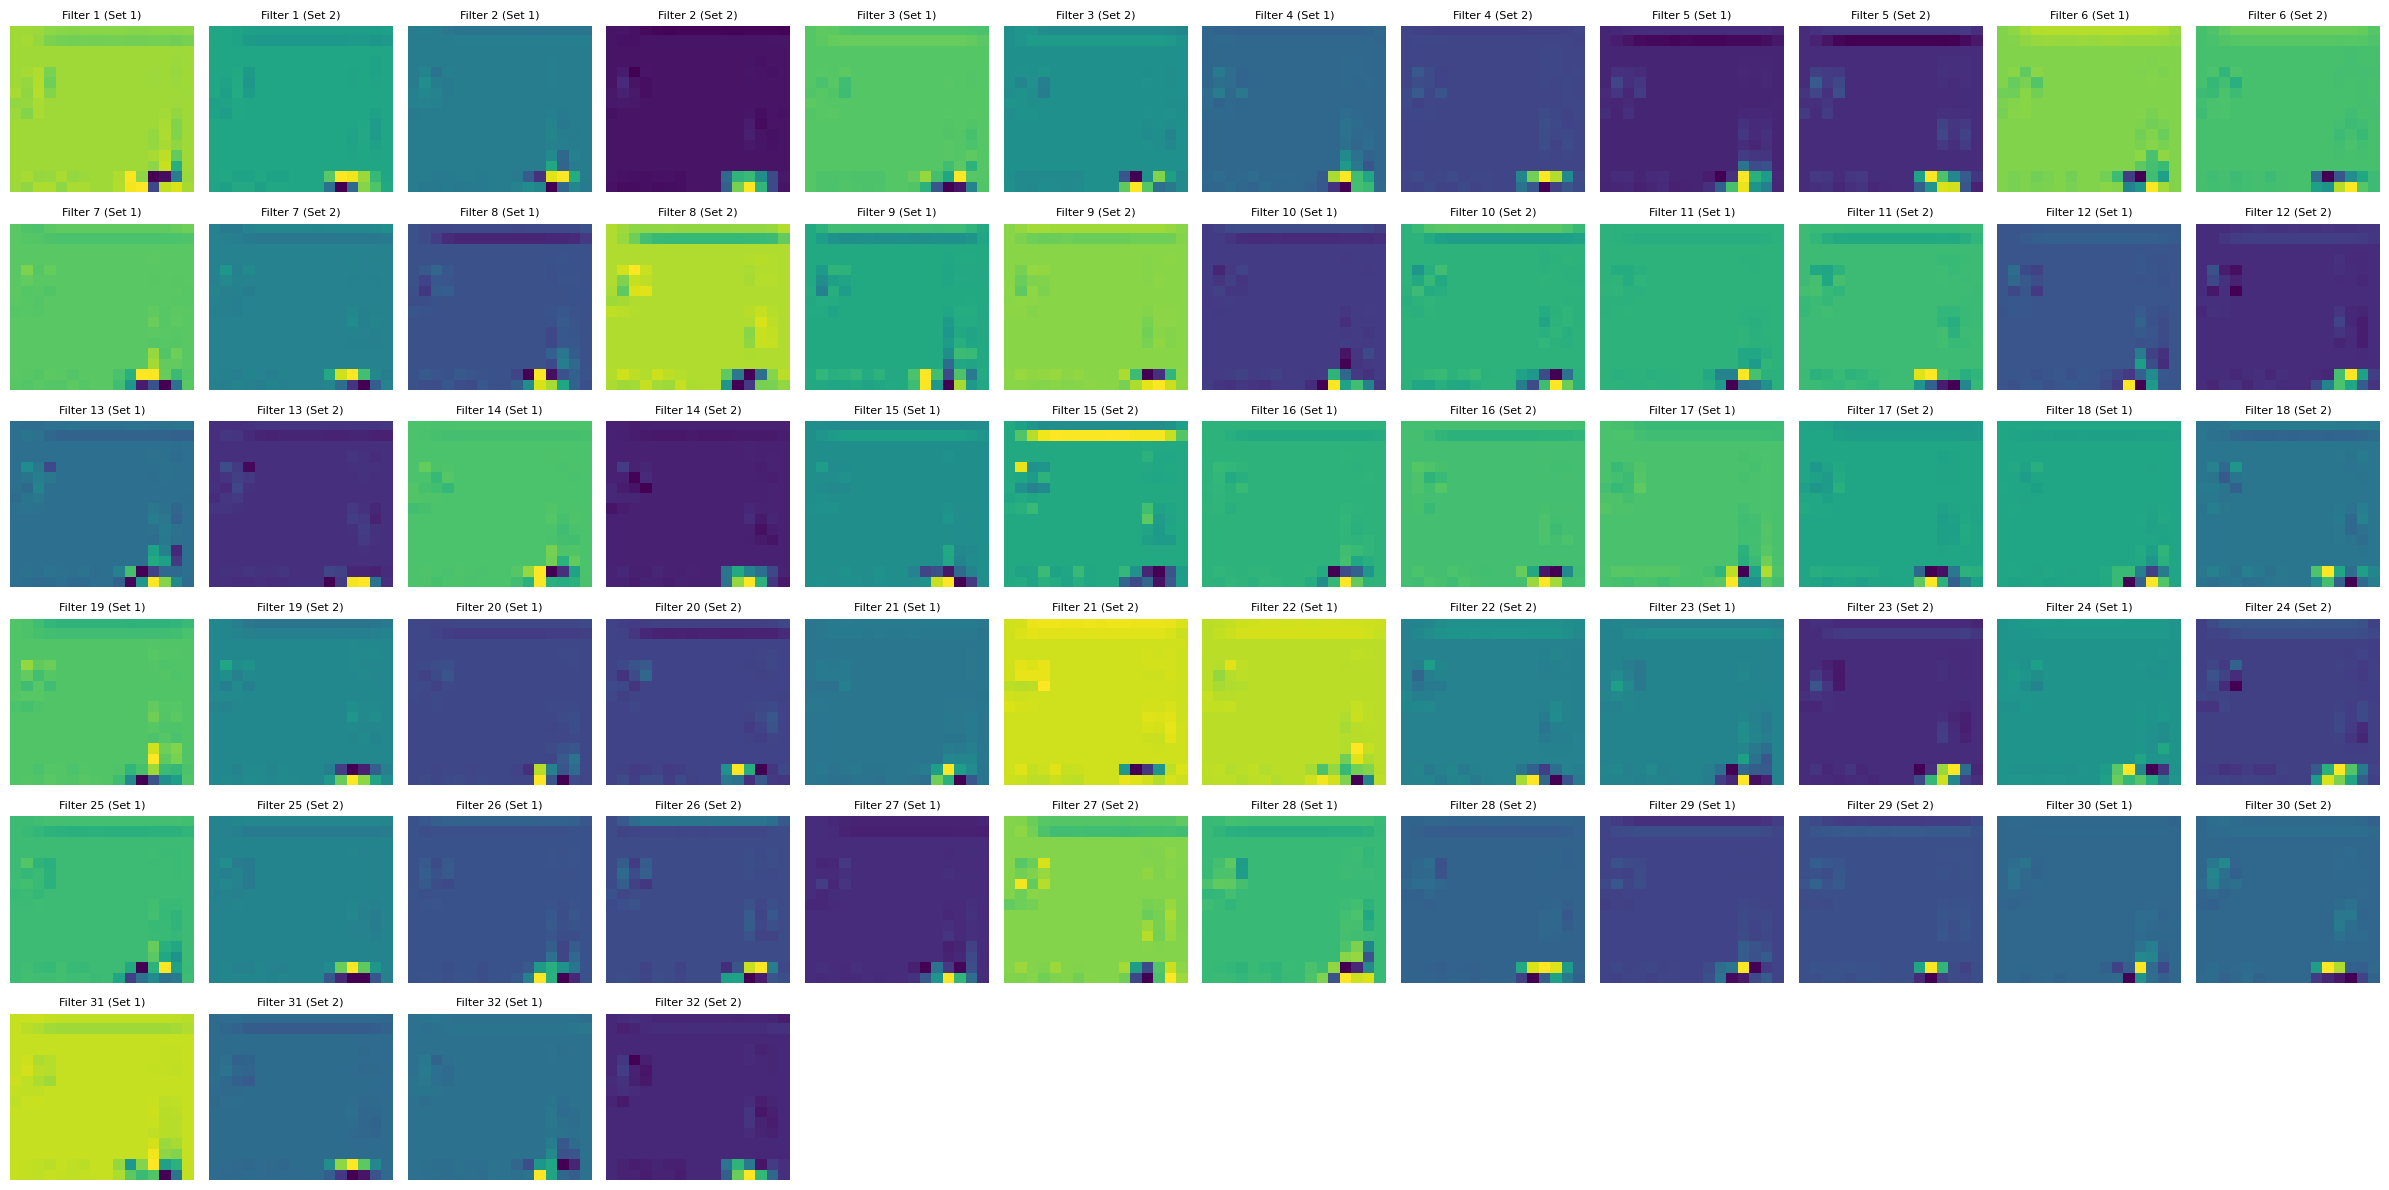

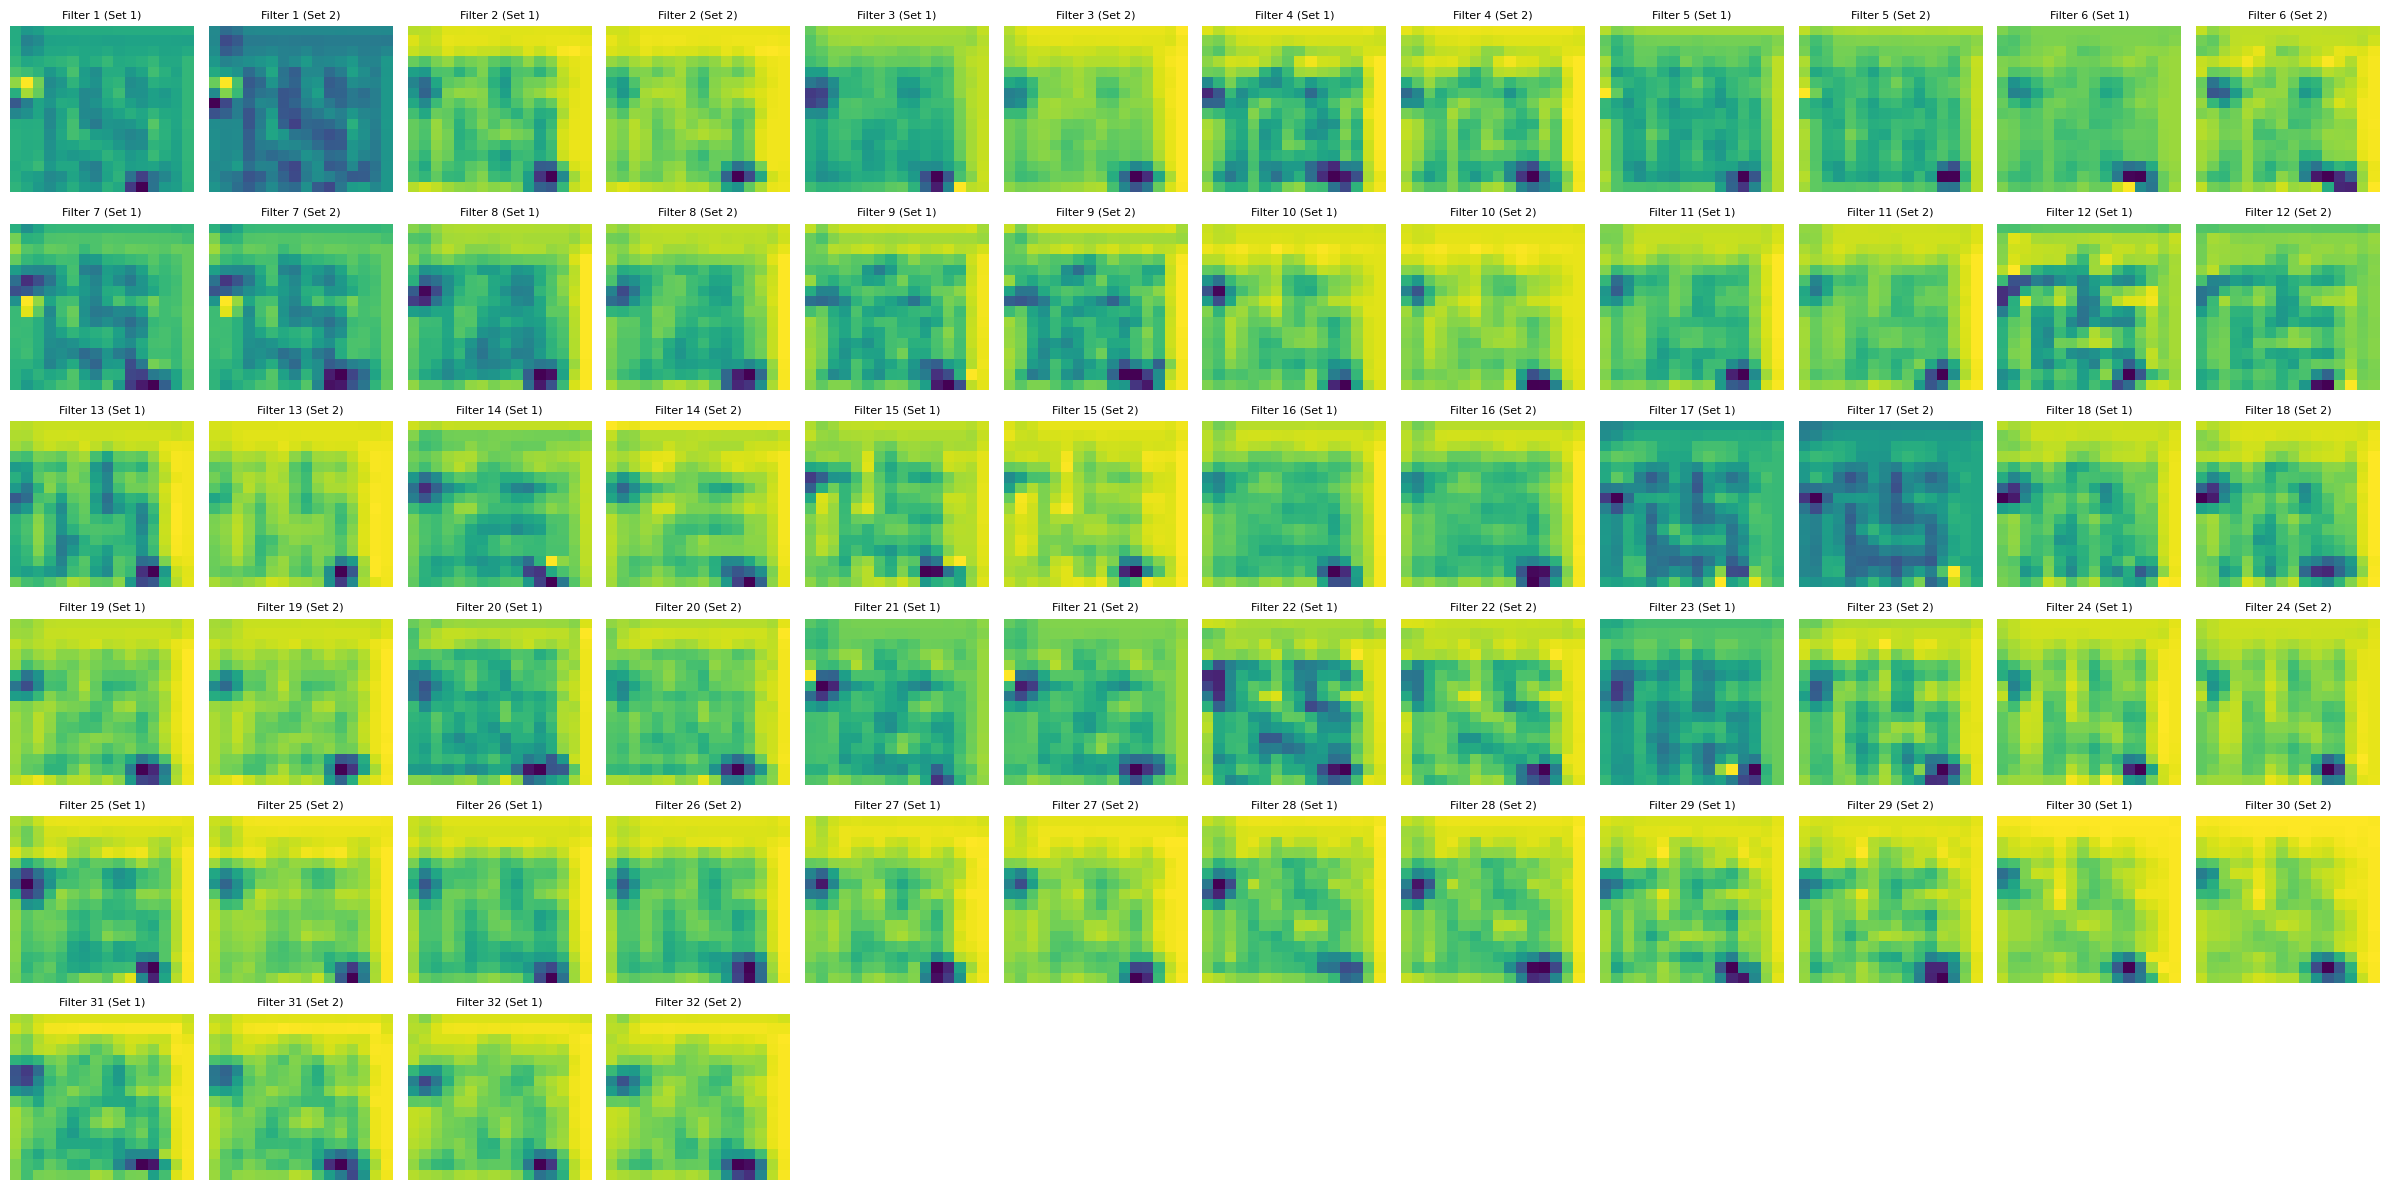

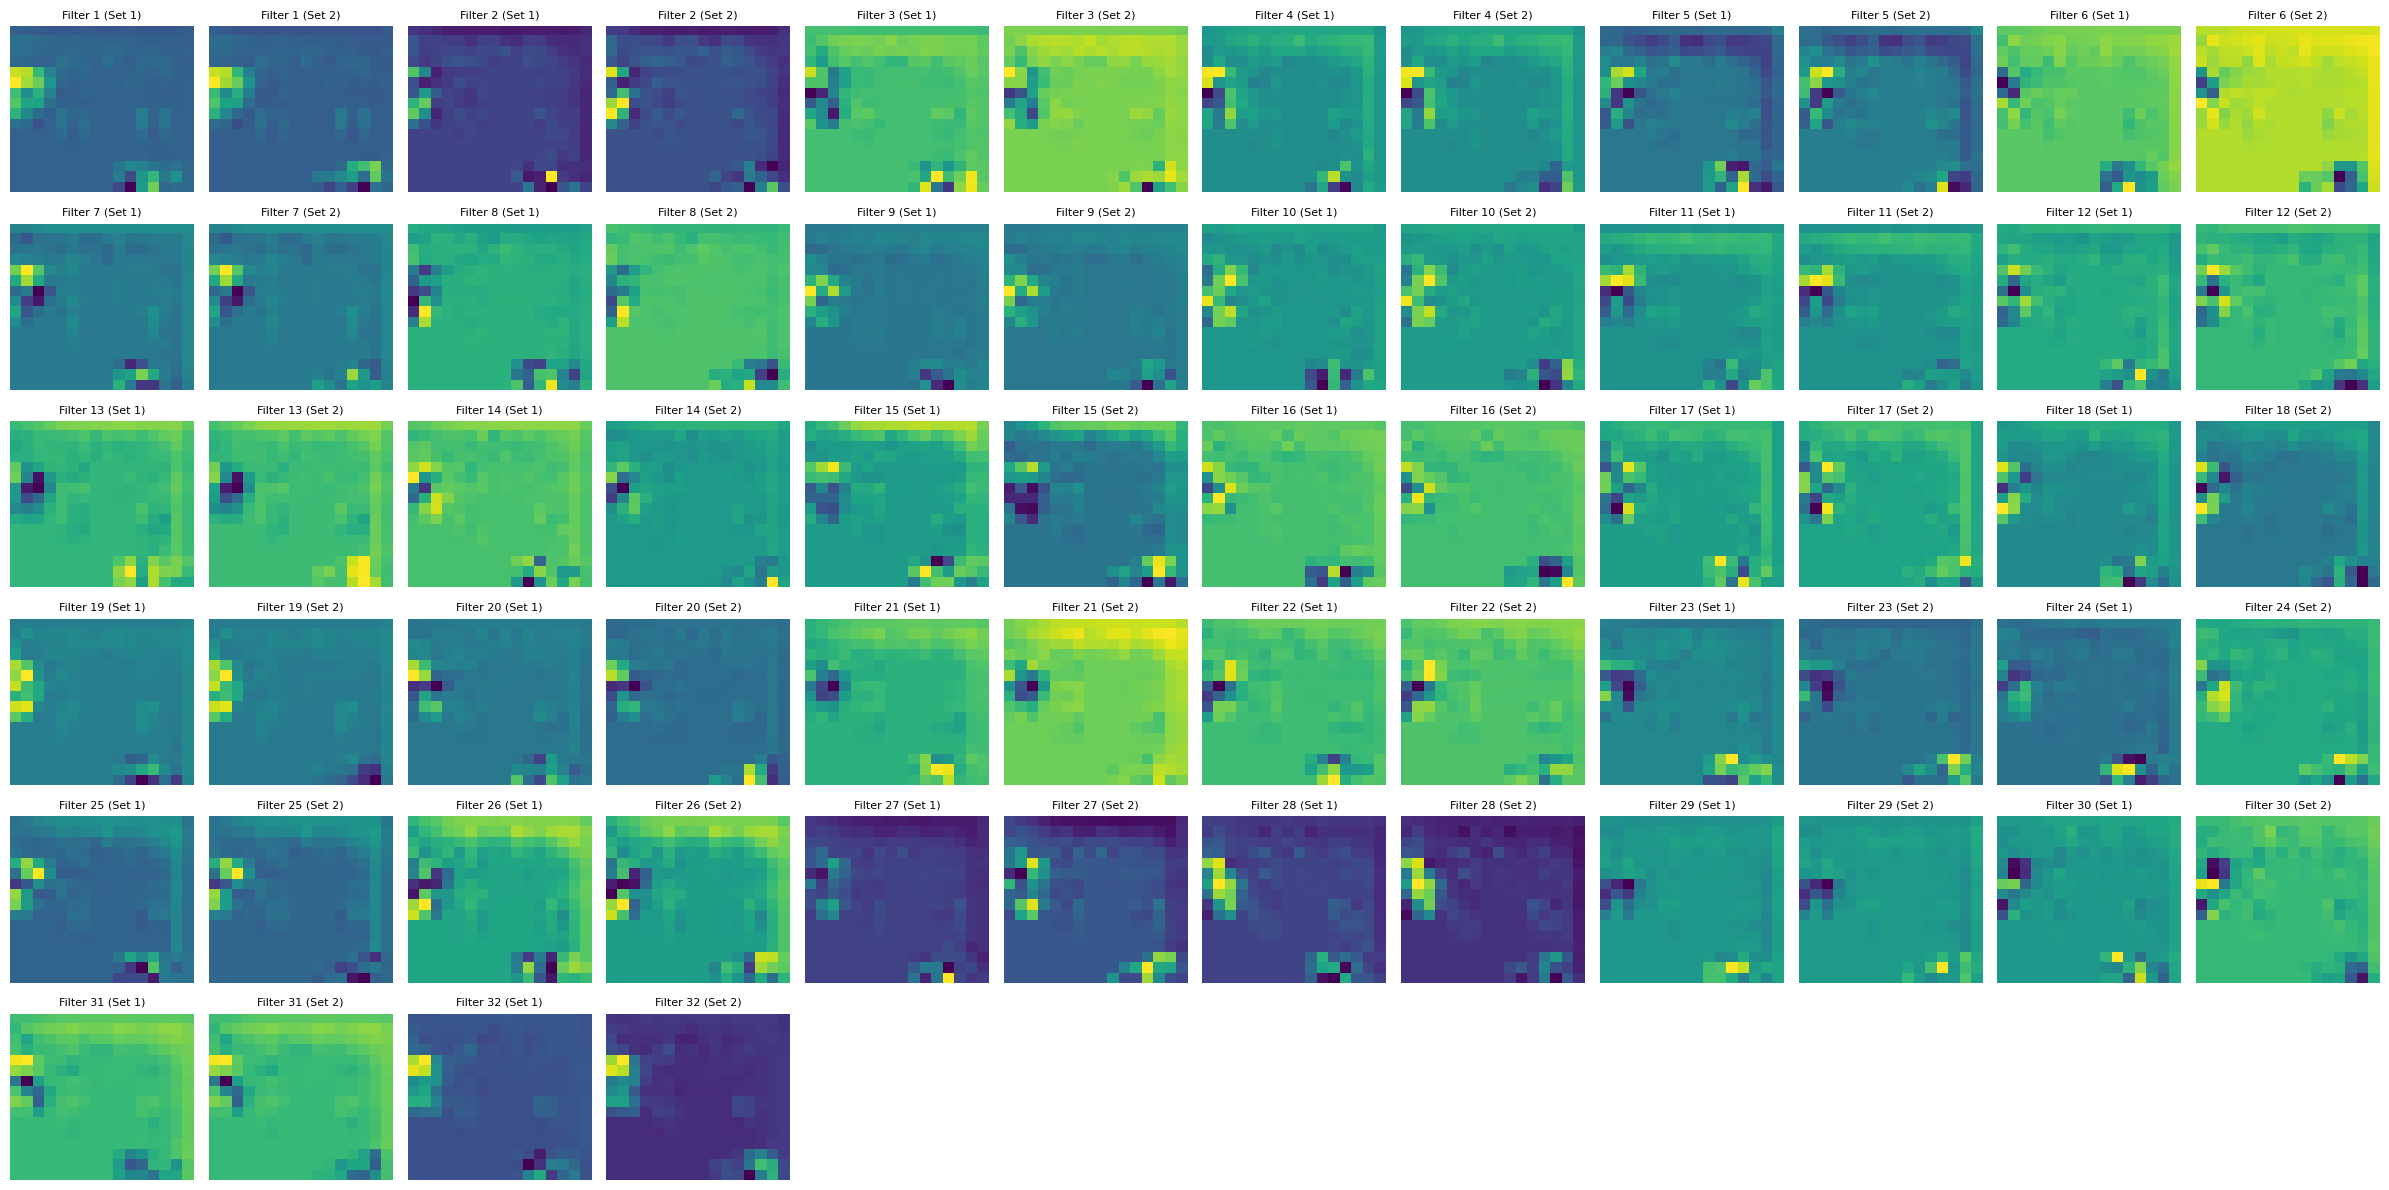

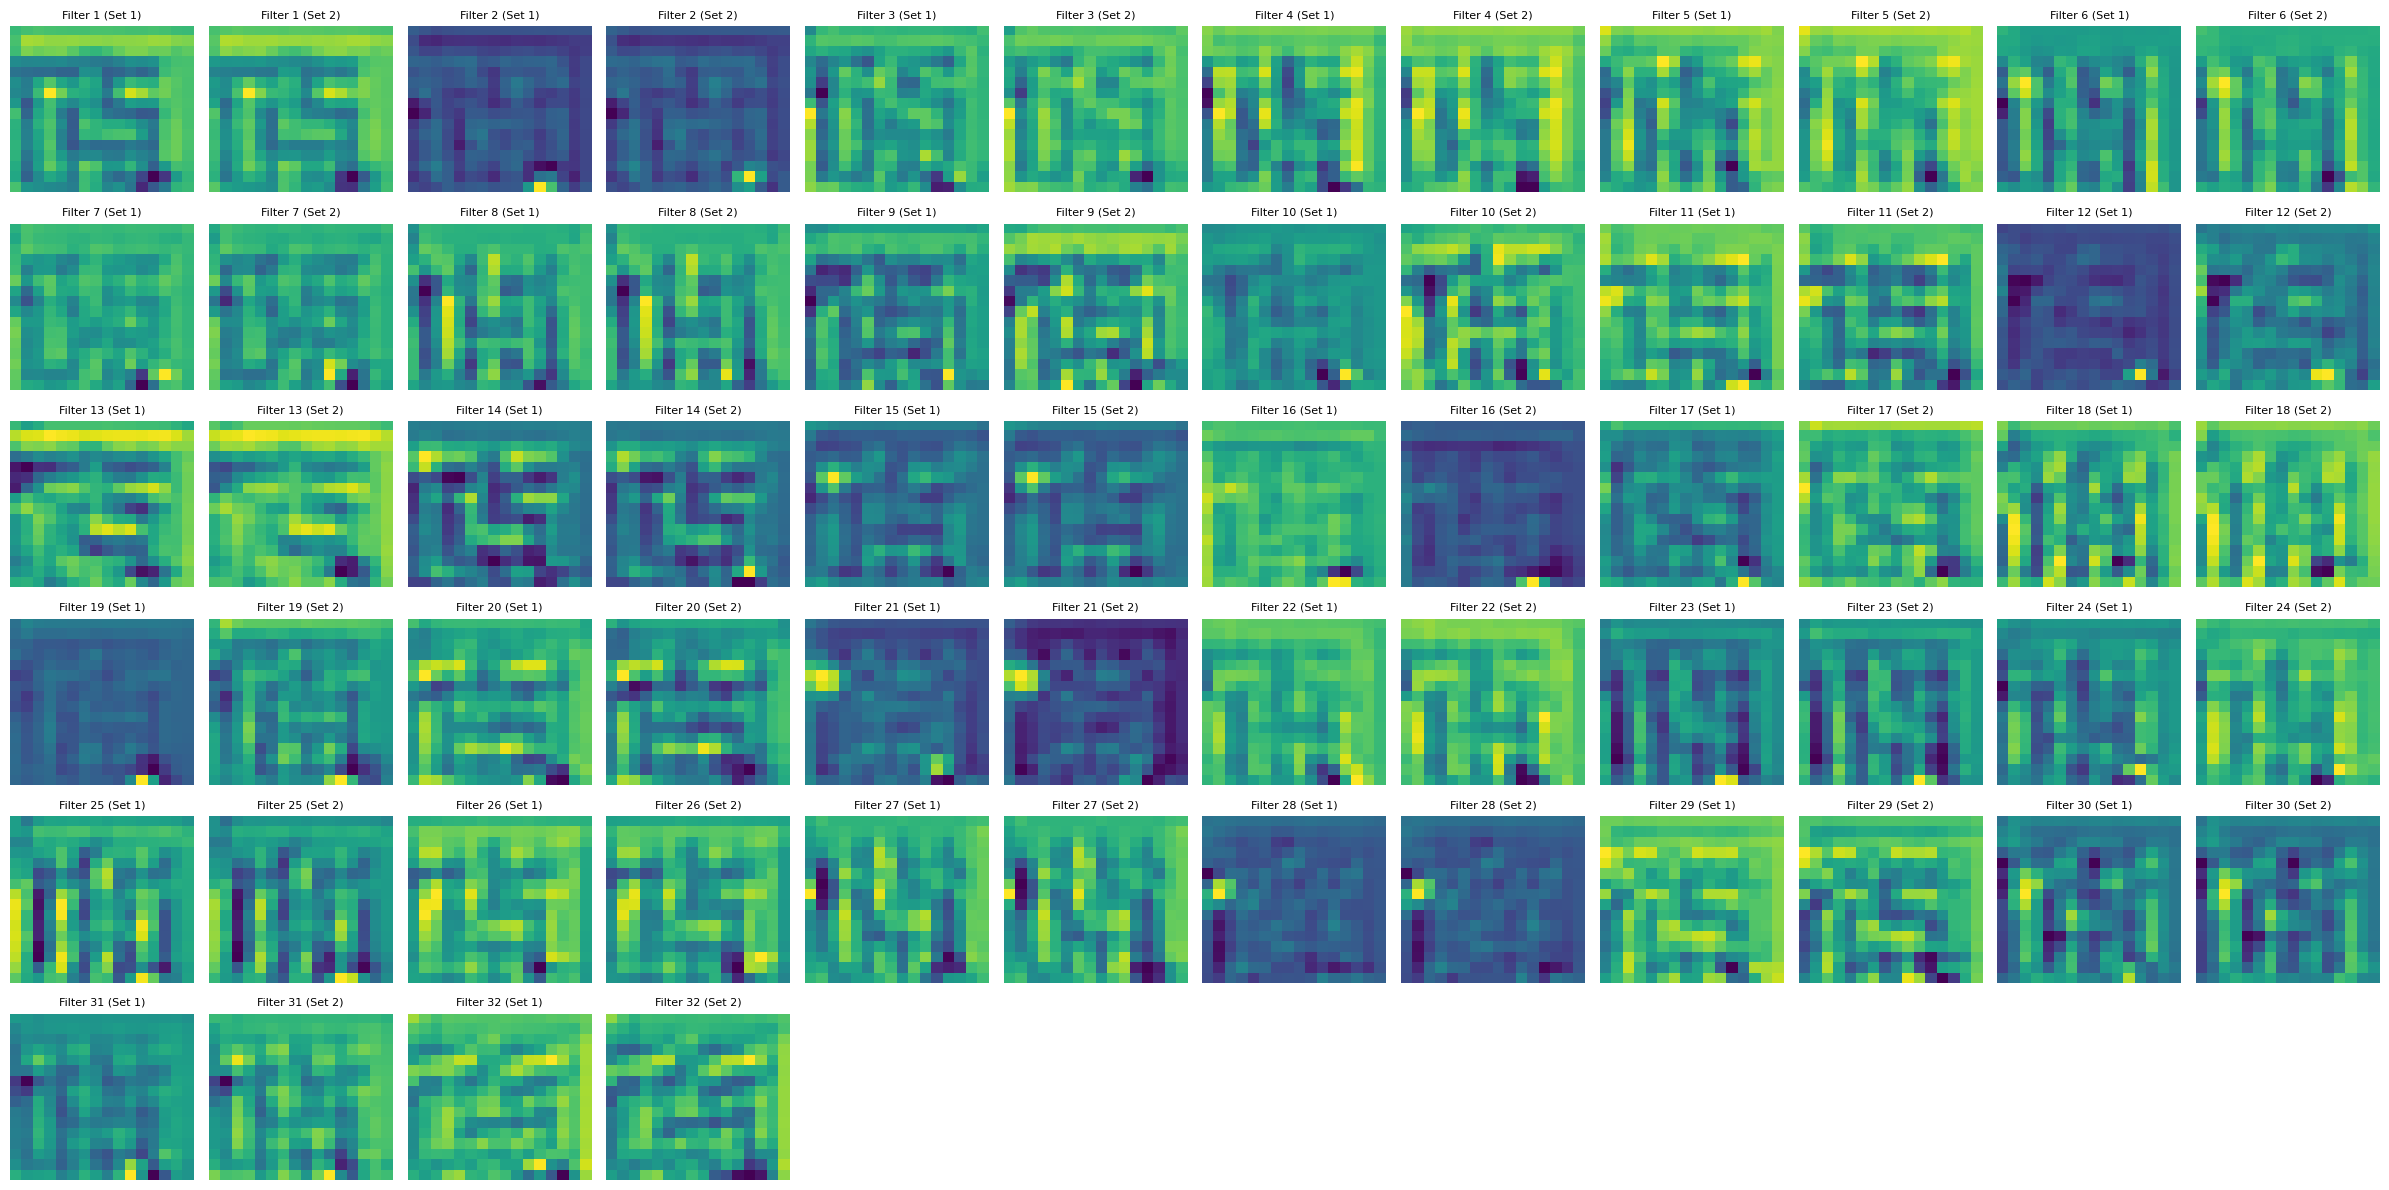

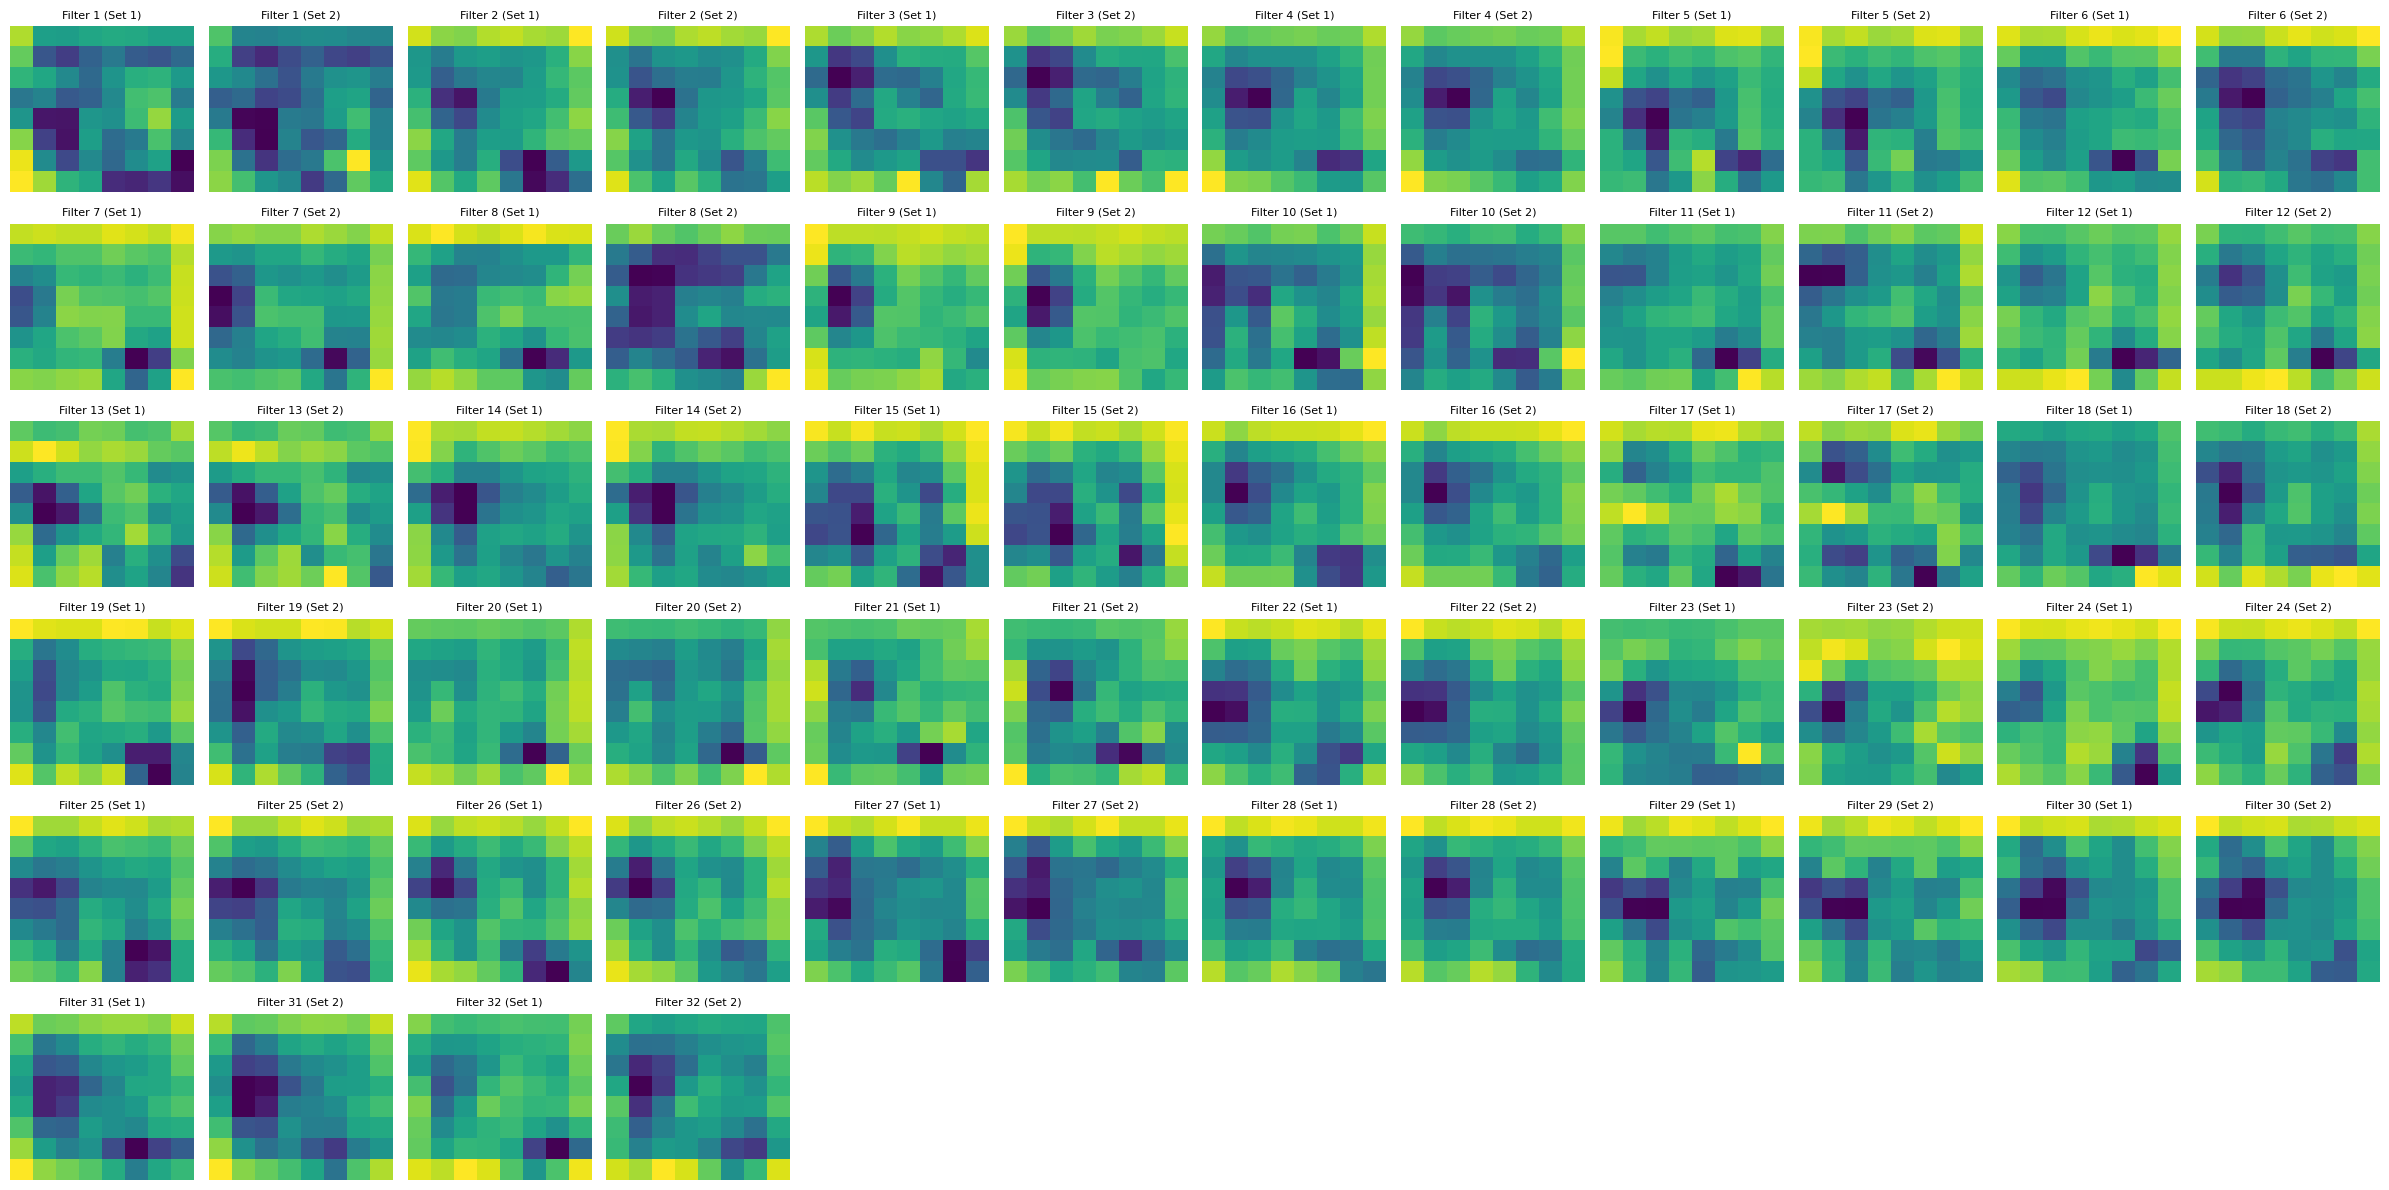

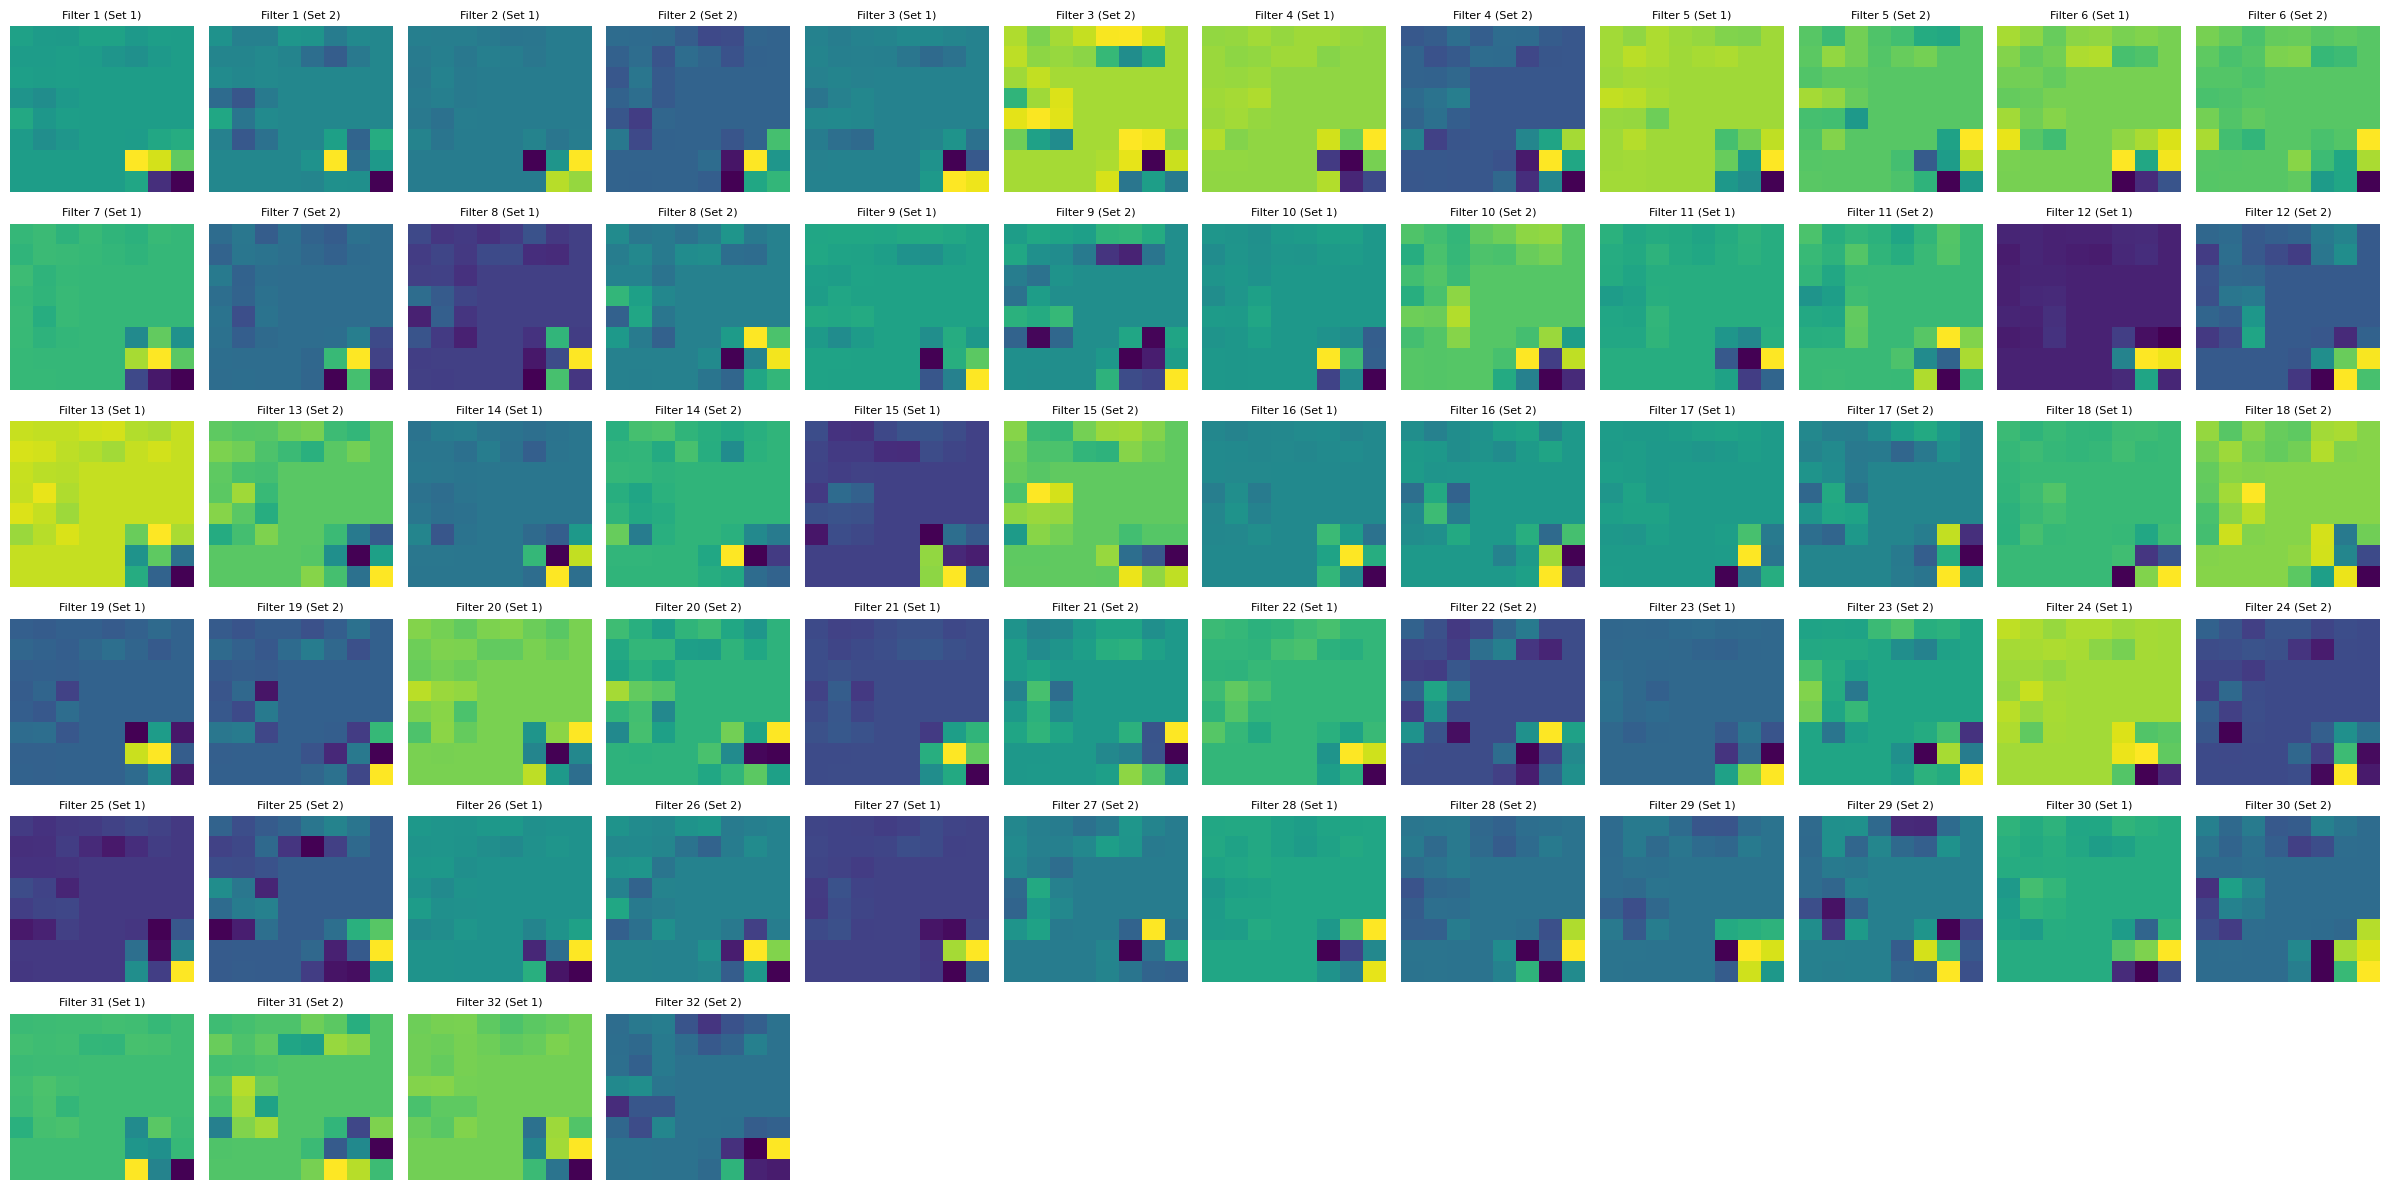

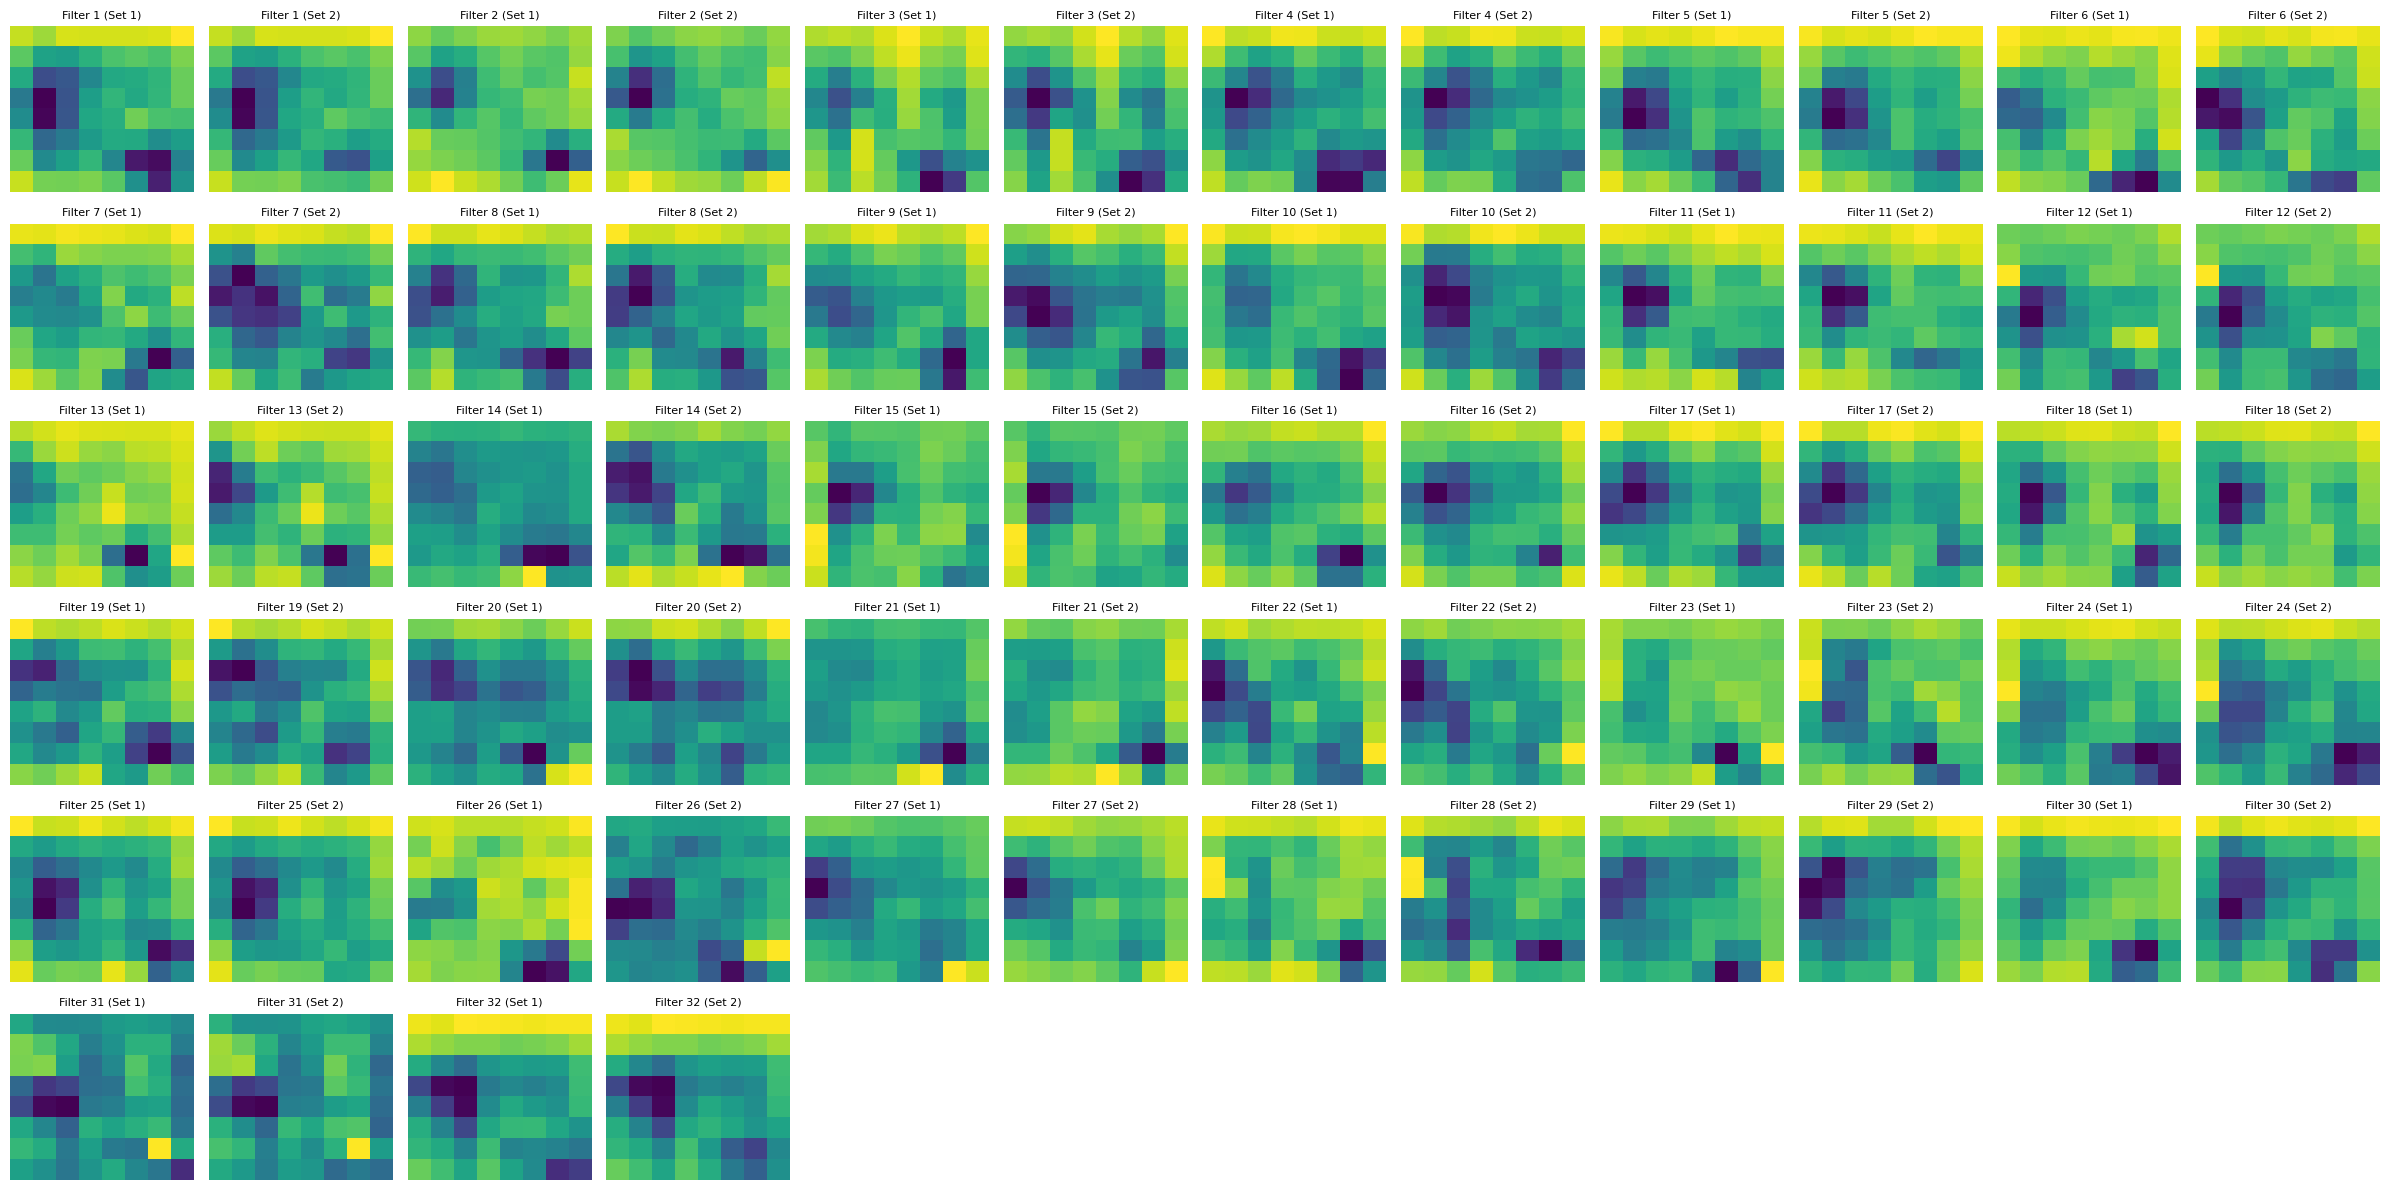

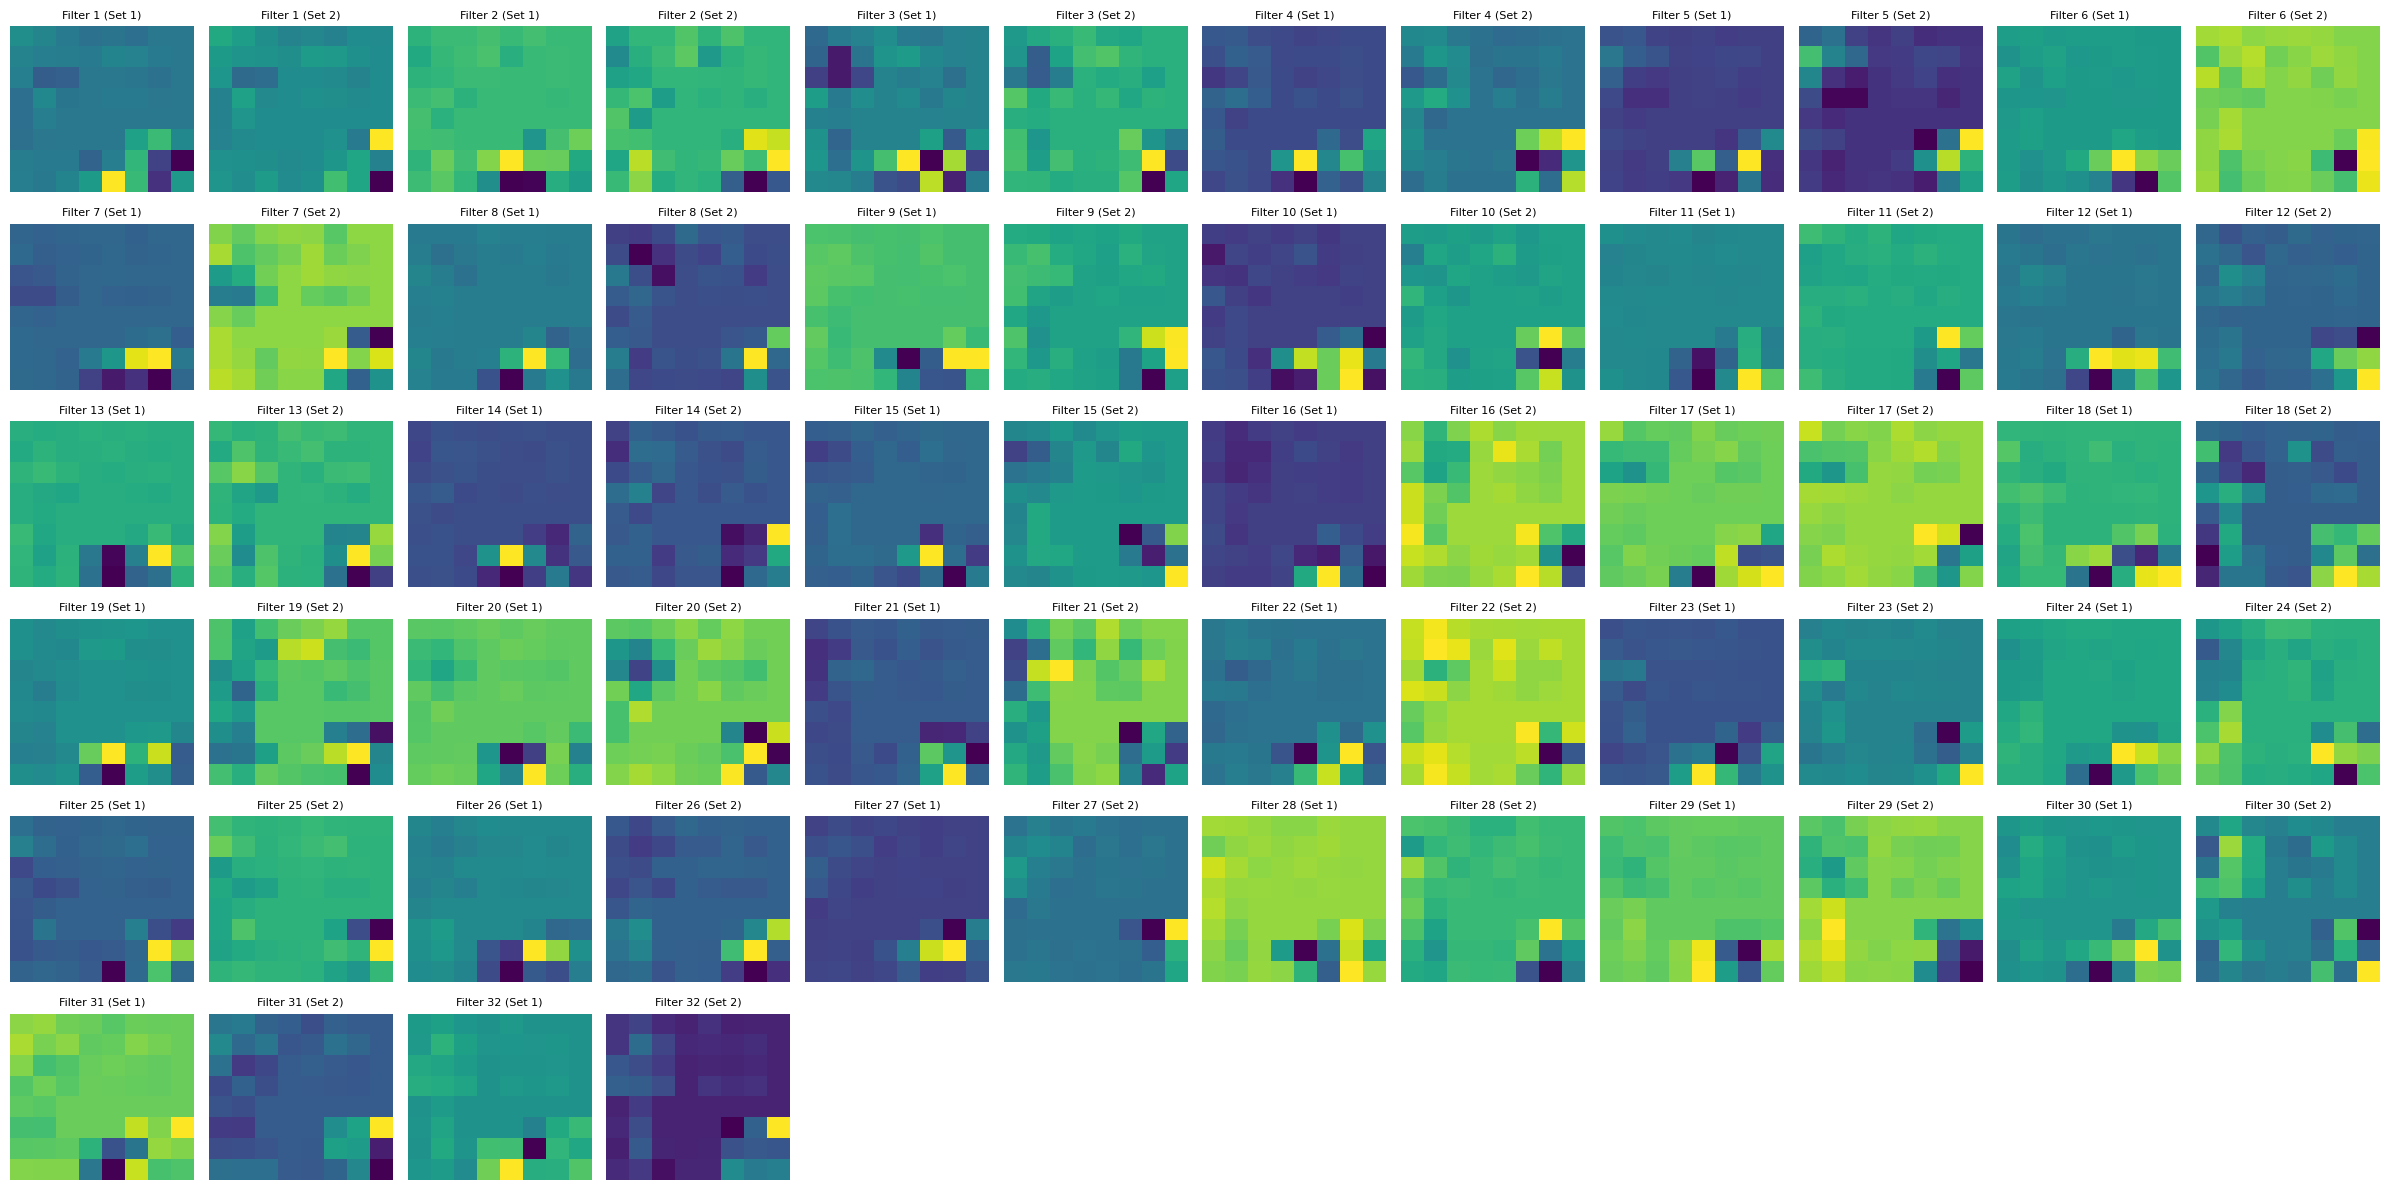

In [ ]:
all_layers = ['conv_seqs_0_conv', 'conv_seqs_0_res_block0_conv0', 'conv_seqs_0_res_block0_conv1', 'conv_seqs_0_res_block1_conv0', 'conv_seqs_0_res_block1_conv1', 'conv_seqs_1_conv', 'conv_seqs_1_res_block0_conv0', 'conv_seqs_1_res_block0_conv1', 'conv_seqs_1_res_block1_conv0', 'conv_seqs_1_res_block1_conv1', 'conv_seqs_2_conv', 'conv_seqs_2_res_block0_conv0', 'conv_seqs_2_res_block0_conv1', 'conv_seqs_2_res_block1_conv0', 'conv_seqs_2_res_block1_conv1']

helpers.plot_activations_for_layers_side_by_side(key_activations, gem_activations,helpers.rename_paths(layer_paths))

torch.Size([16, 64, 64])
Key: conv_seqs_0_conv has non-zero differences.
torch.Size([16, 32, 32])
Key: conv_seqs_0_res_block0_conv0 has non-zero differences.
torch.Size([16, 32, 32])
Key: conv_seqs_0_res_block0_conv1 has non-zero differences.
torch.Size([16, 32, 32])
Key: conv_seqs_0_res_block1_conv0 has non-zero differences.
torch.Size([16, 32, 32])
Key: conv_seqs_0_res_block1_conv1 has non-zero differences.
torch.Size([32, 32, 32])
Key: conv_seqs_1_conv has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_1_res_block0_conv0 has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_1_res_block0_conv1 has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_1_res_block1_conv0 has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_1_res_block1_conv1 has non-zero differences.
torch.Size([32, 16, 16])
Key: conv_seqs_2_conv has non-zero differences.
torch.Size([32, 8, 8])
Key: conv_seqs_2_res_block0_conv0 has non-zero differences.
torch.Size([32, 8,

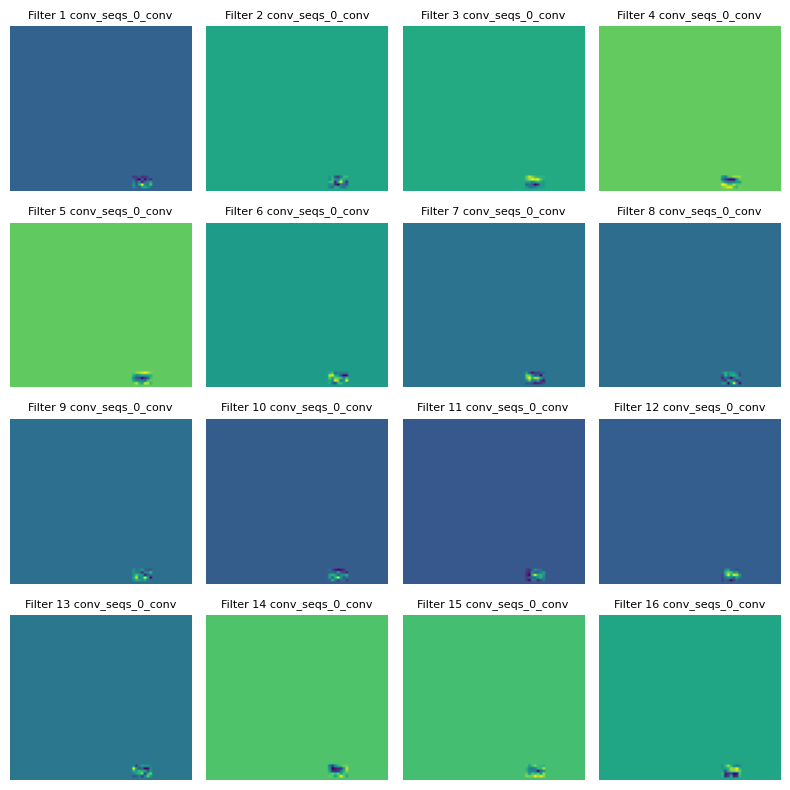

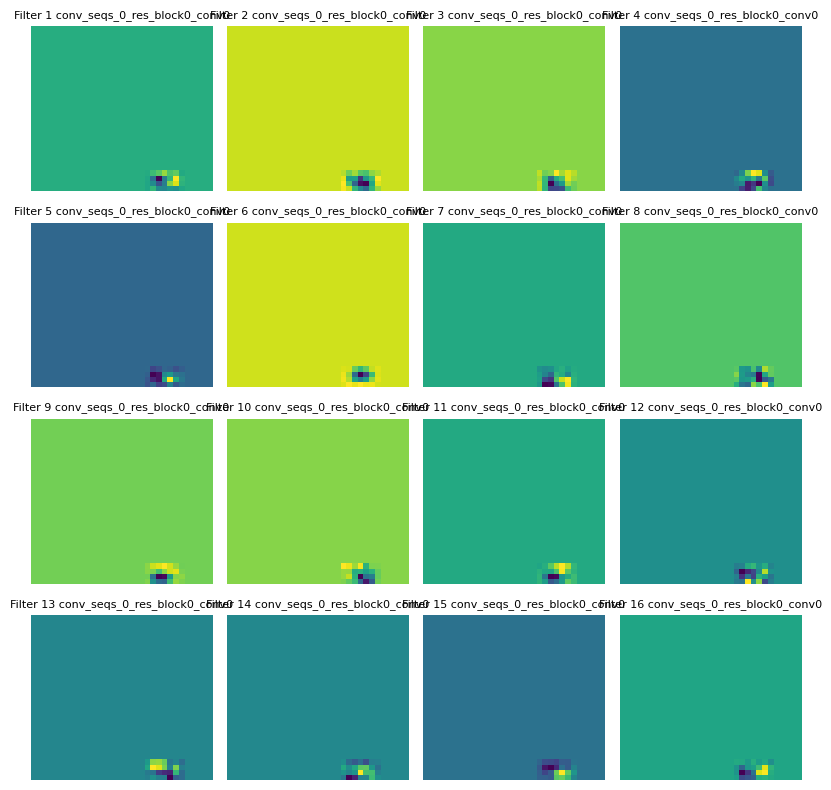

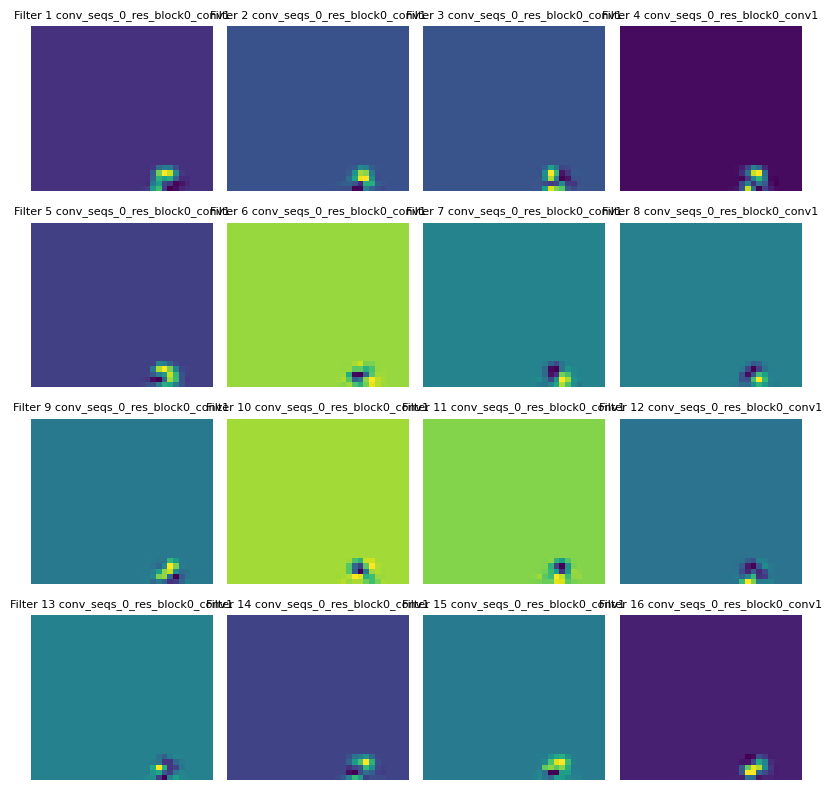

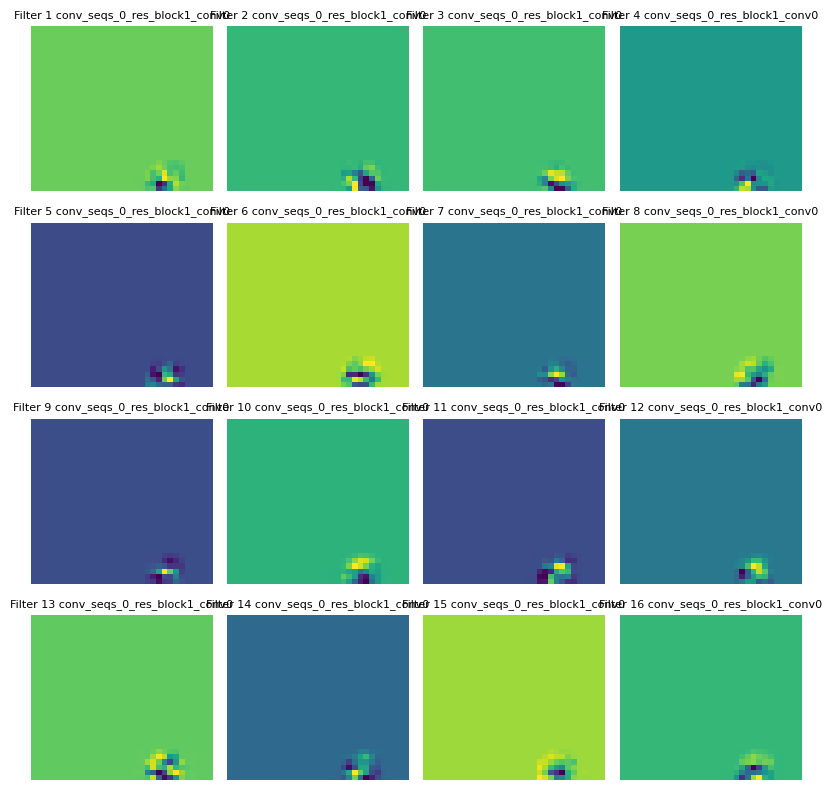

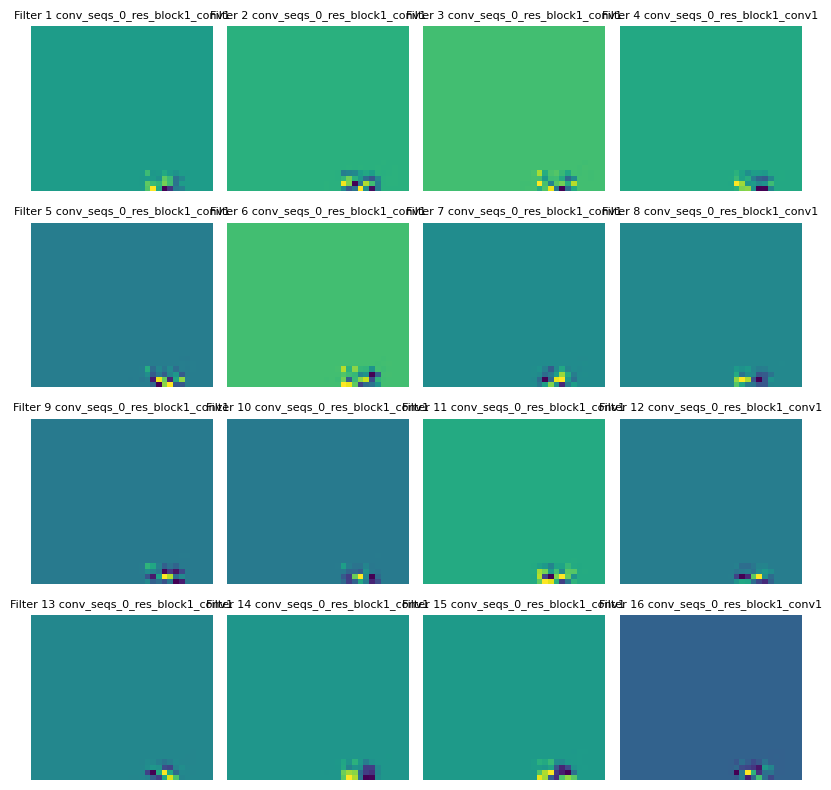

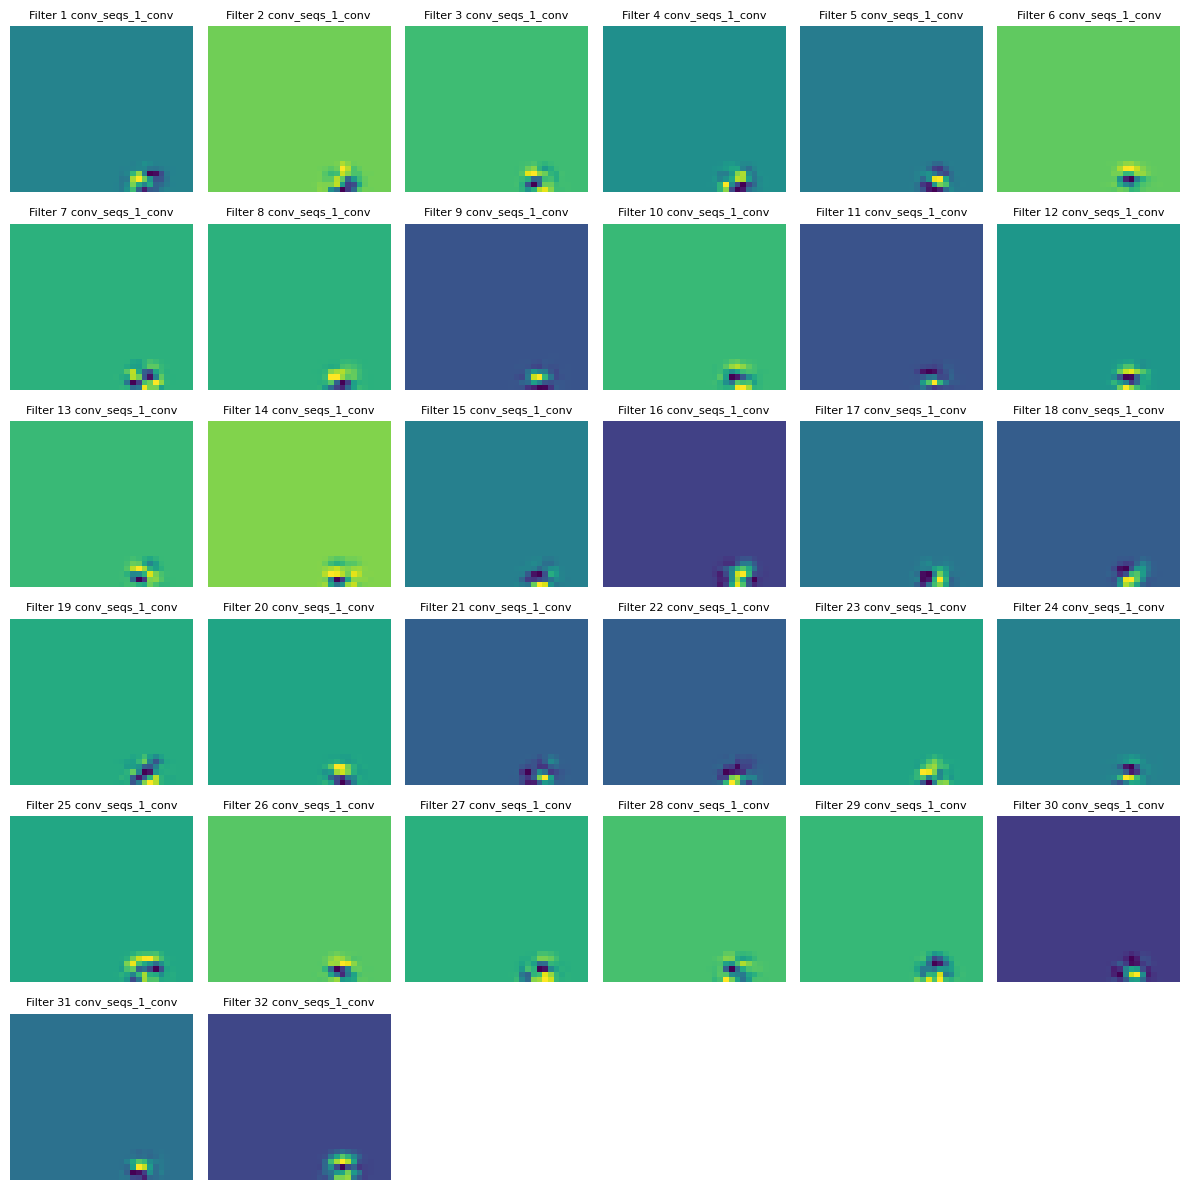

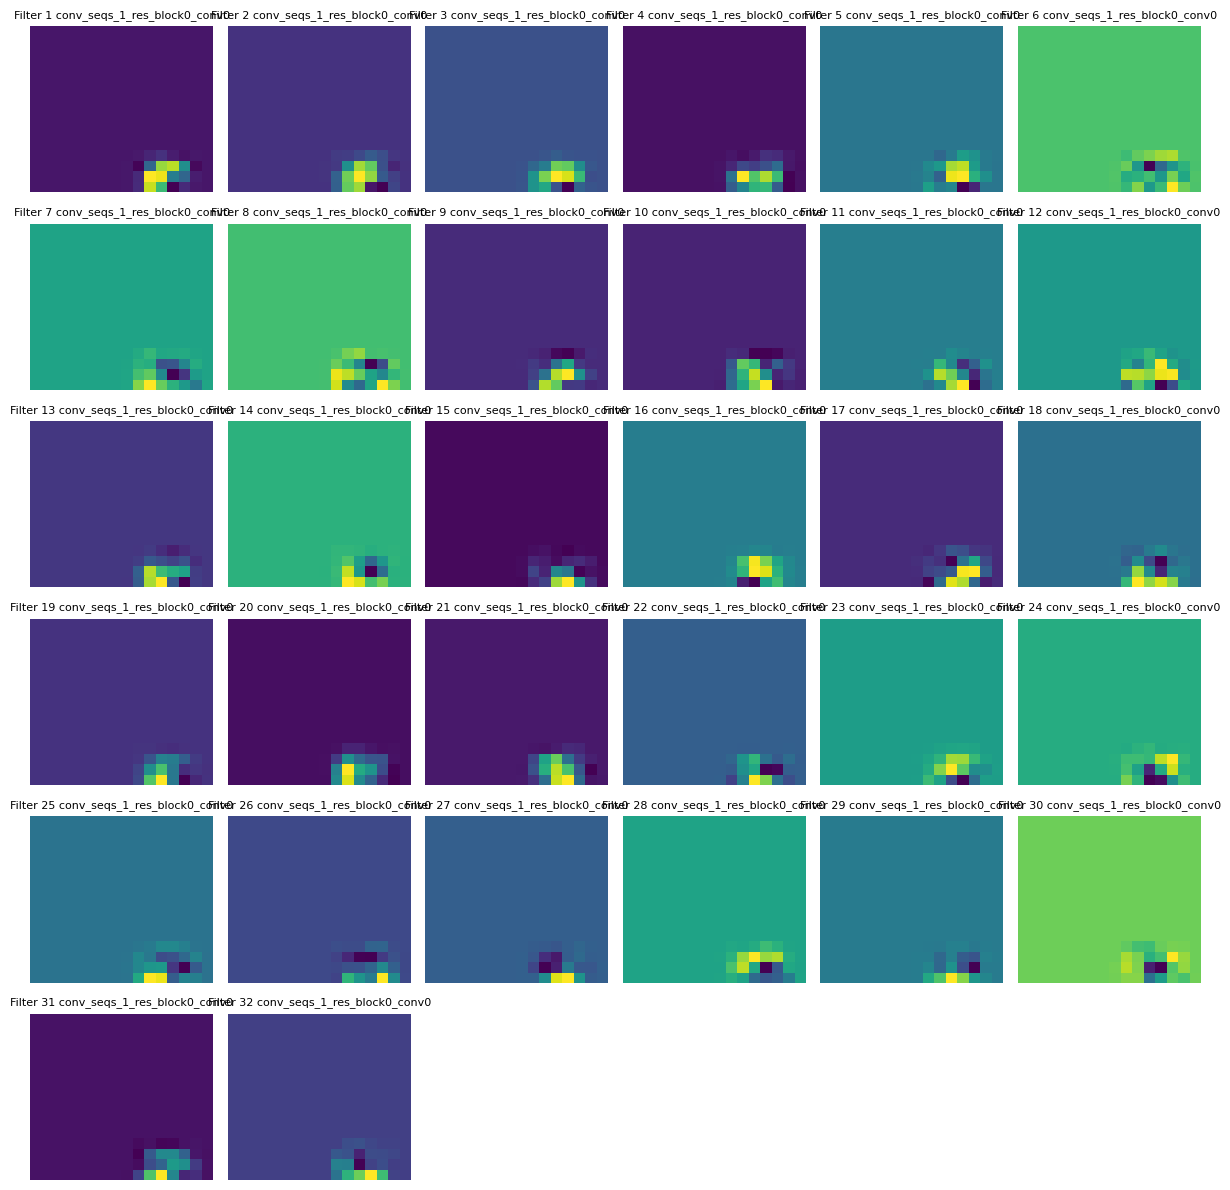

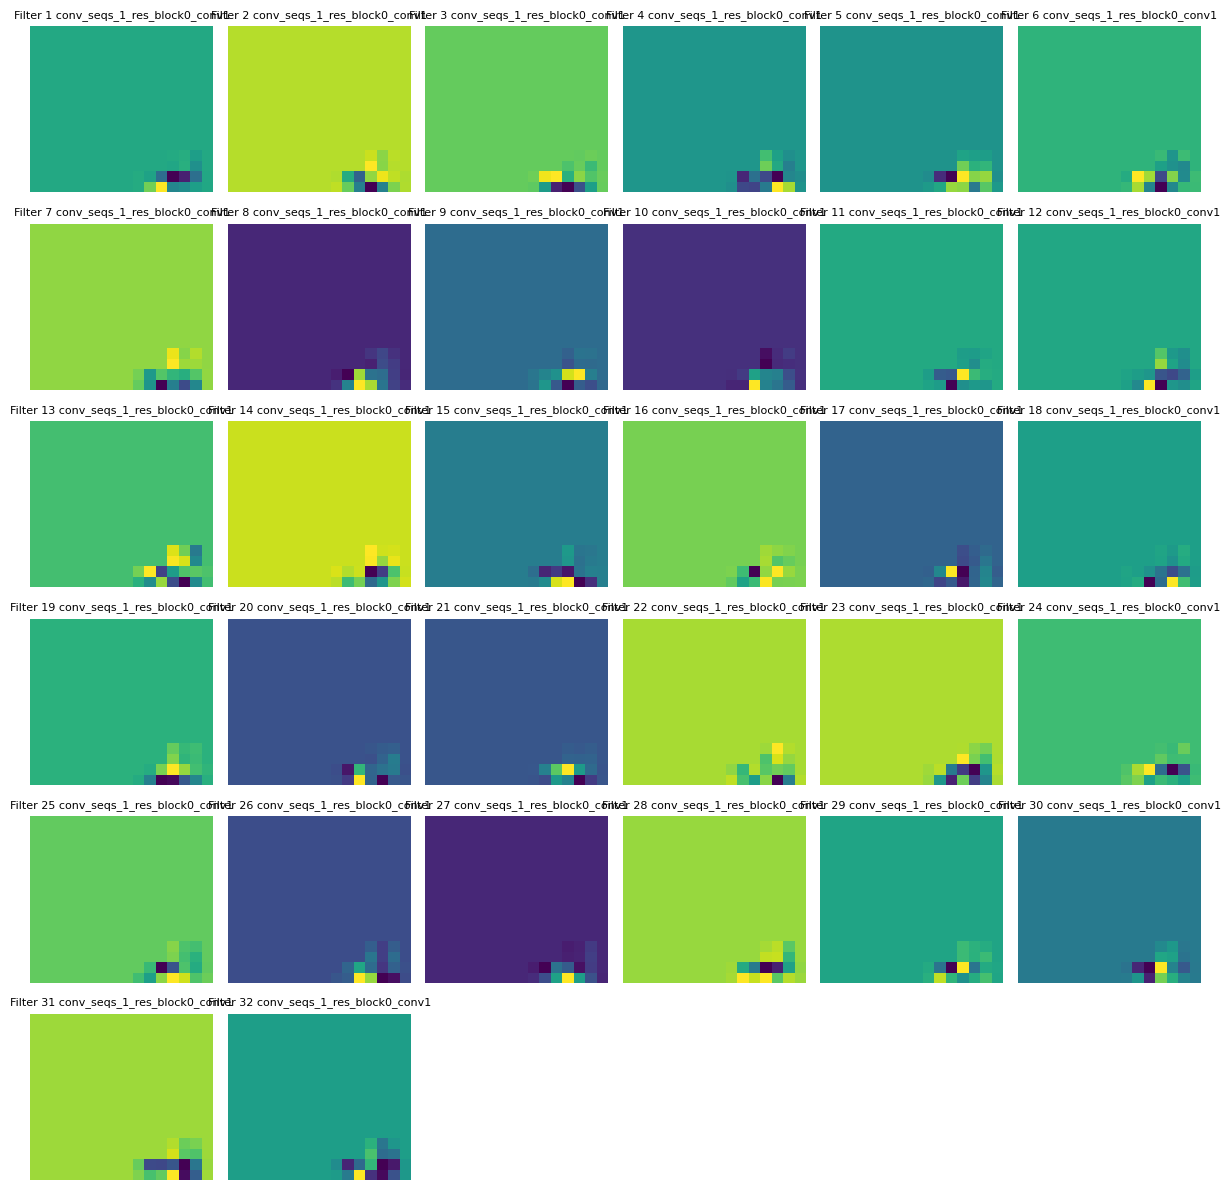

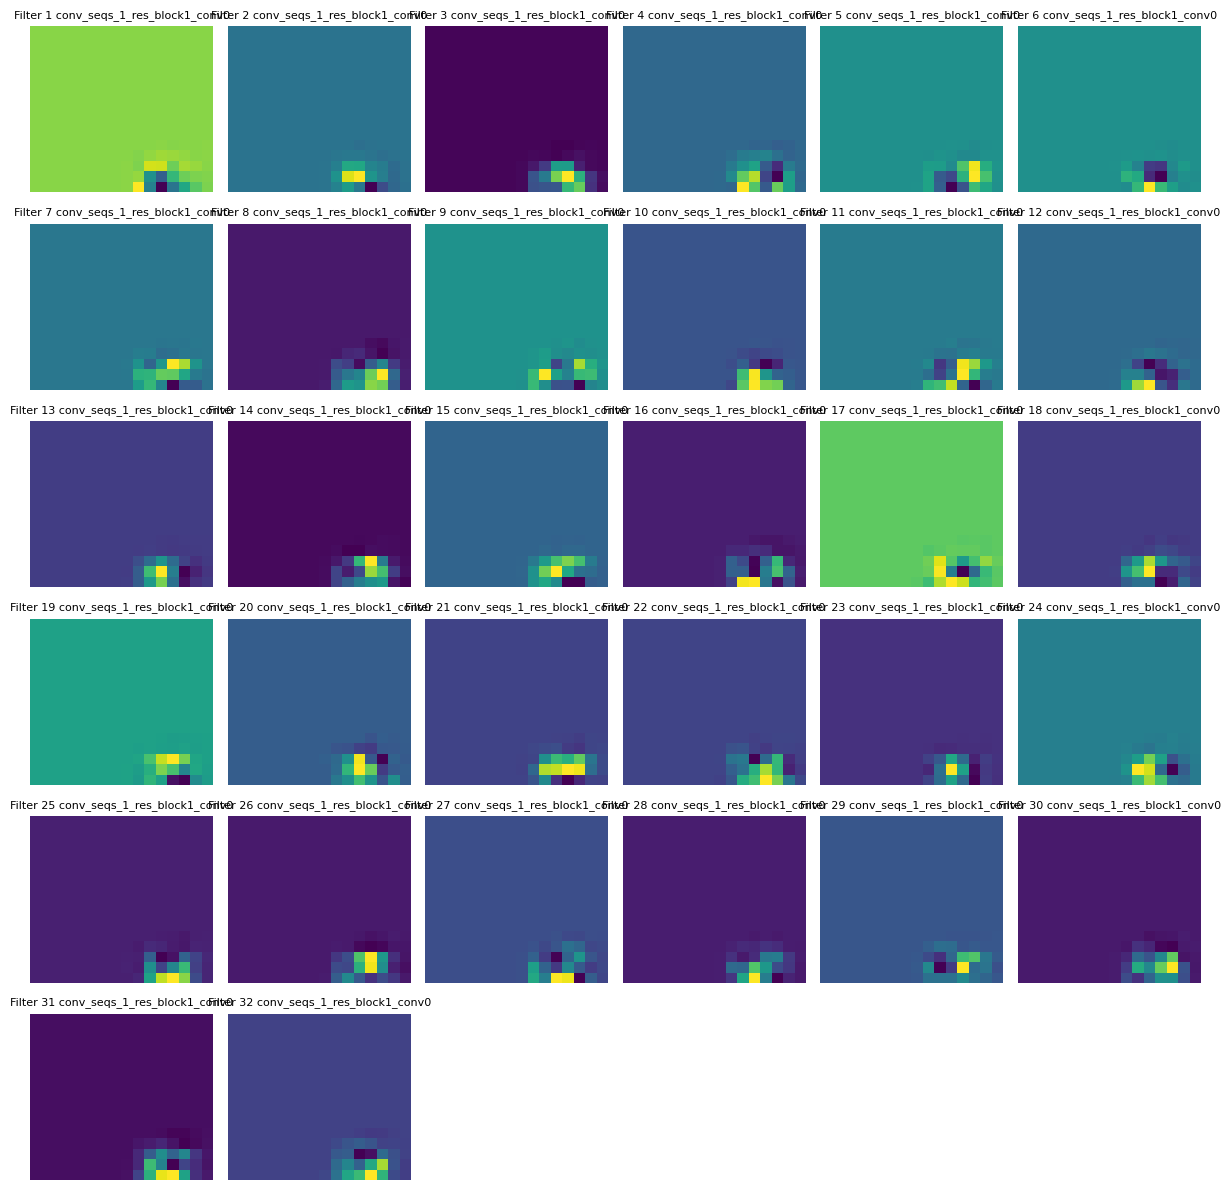

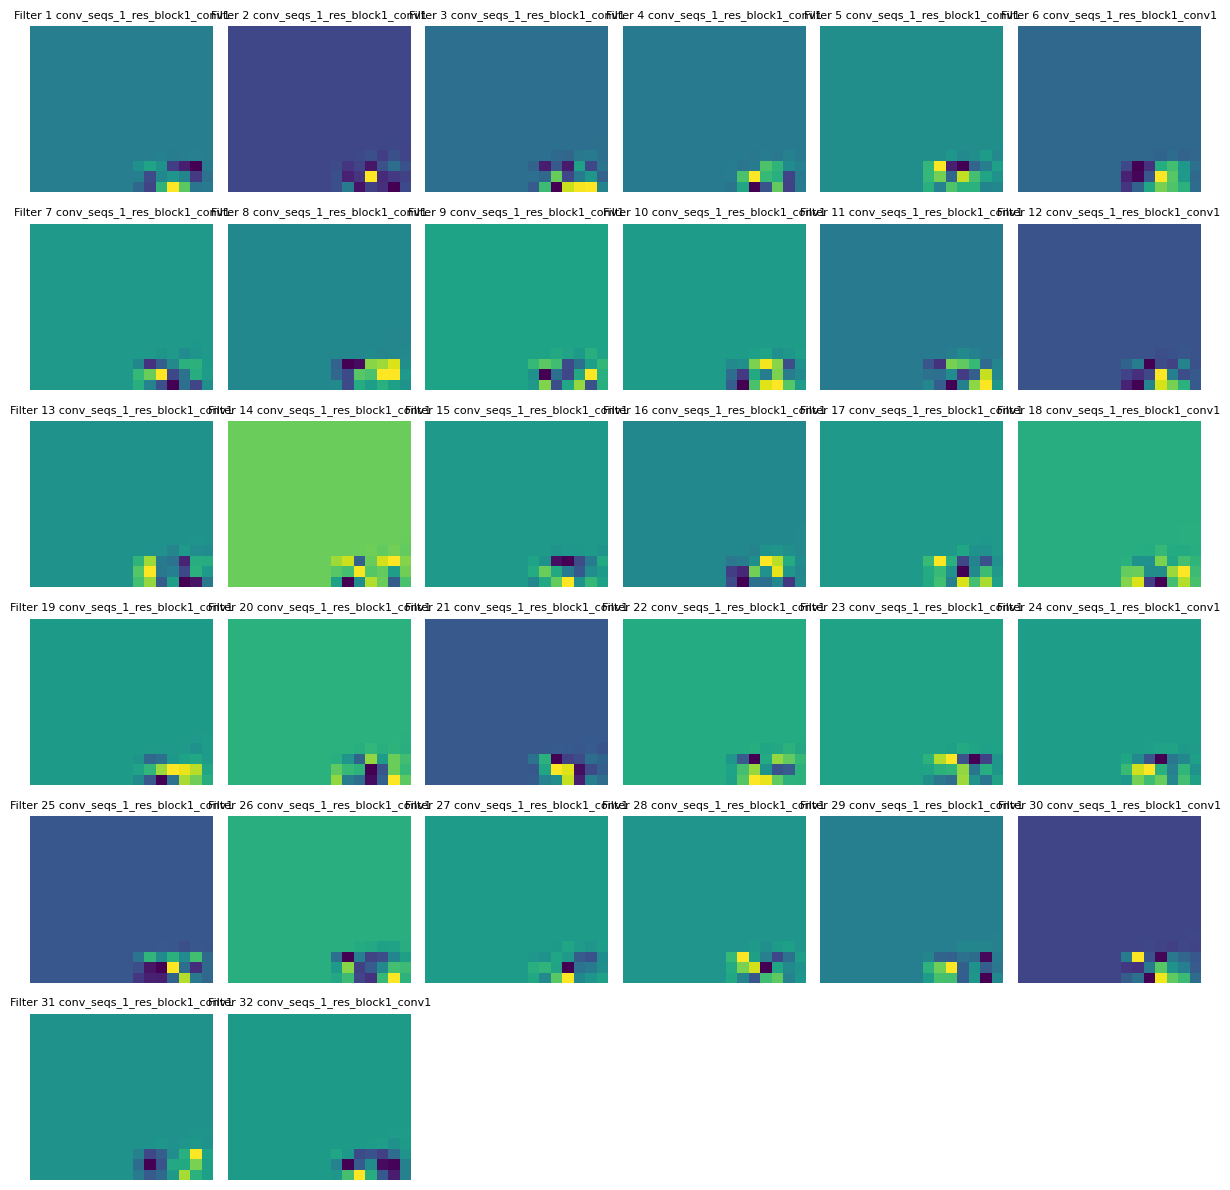

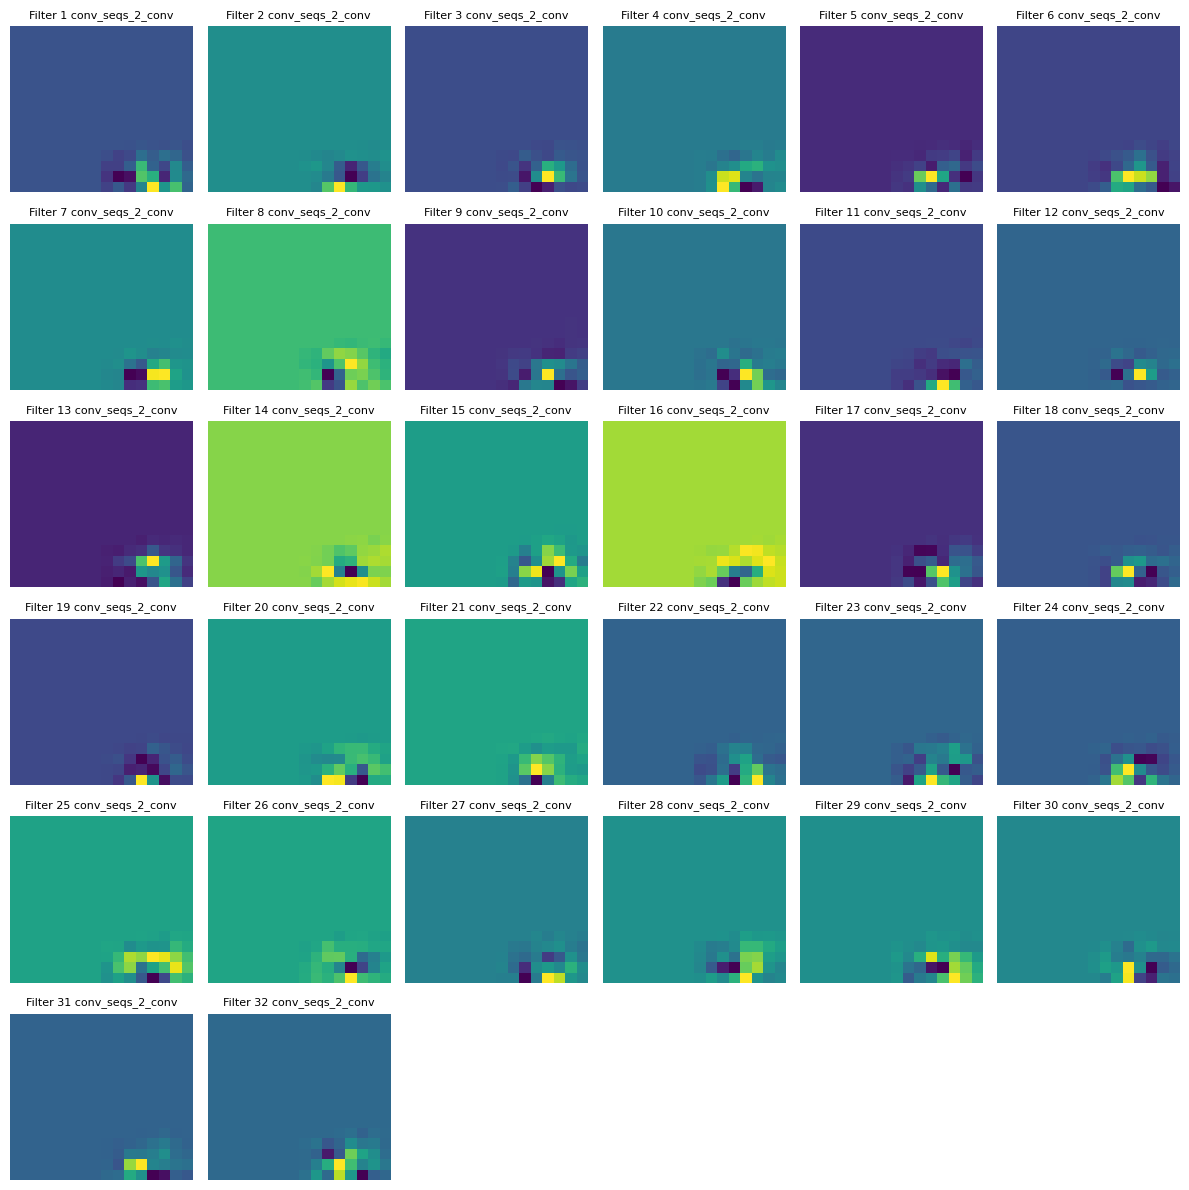

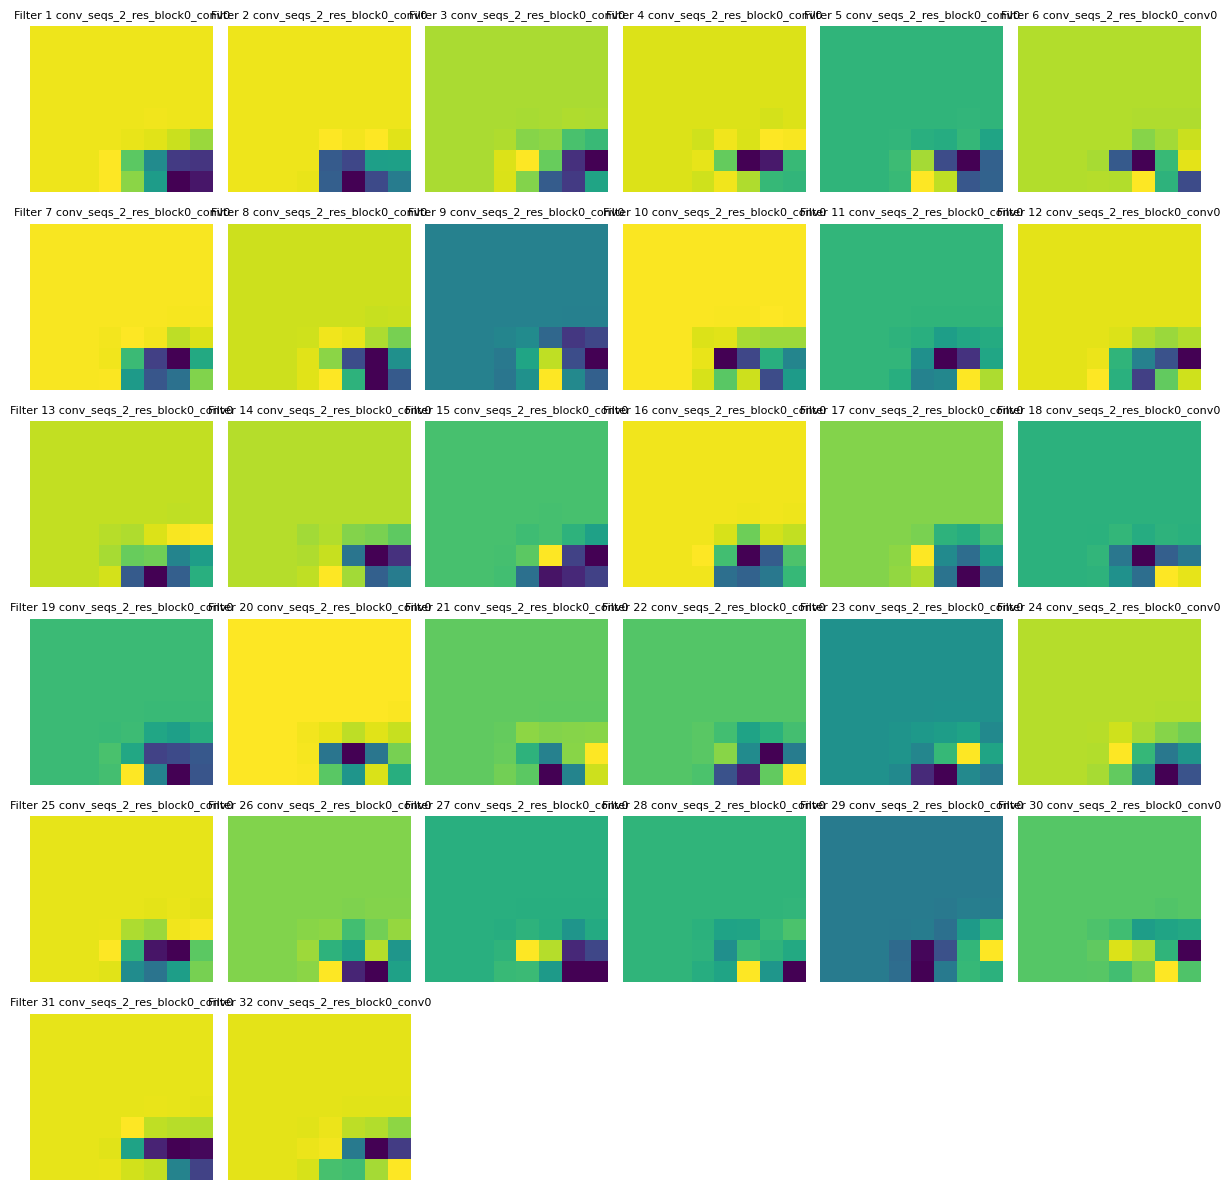

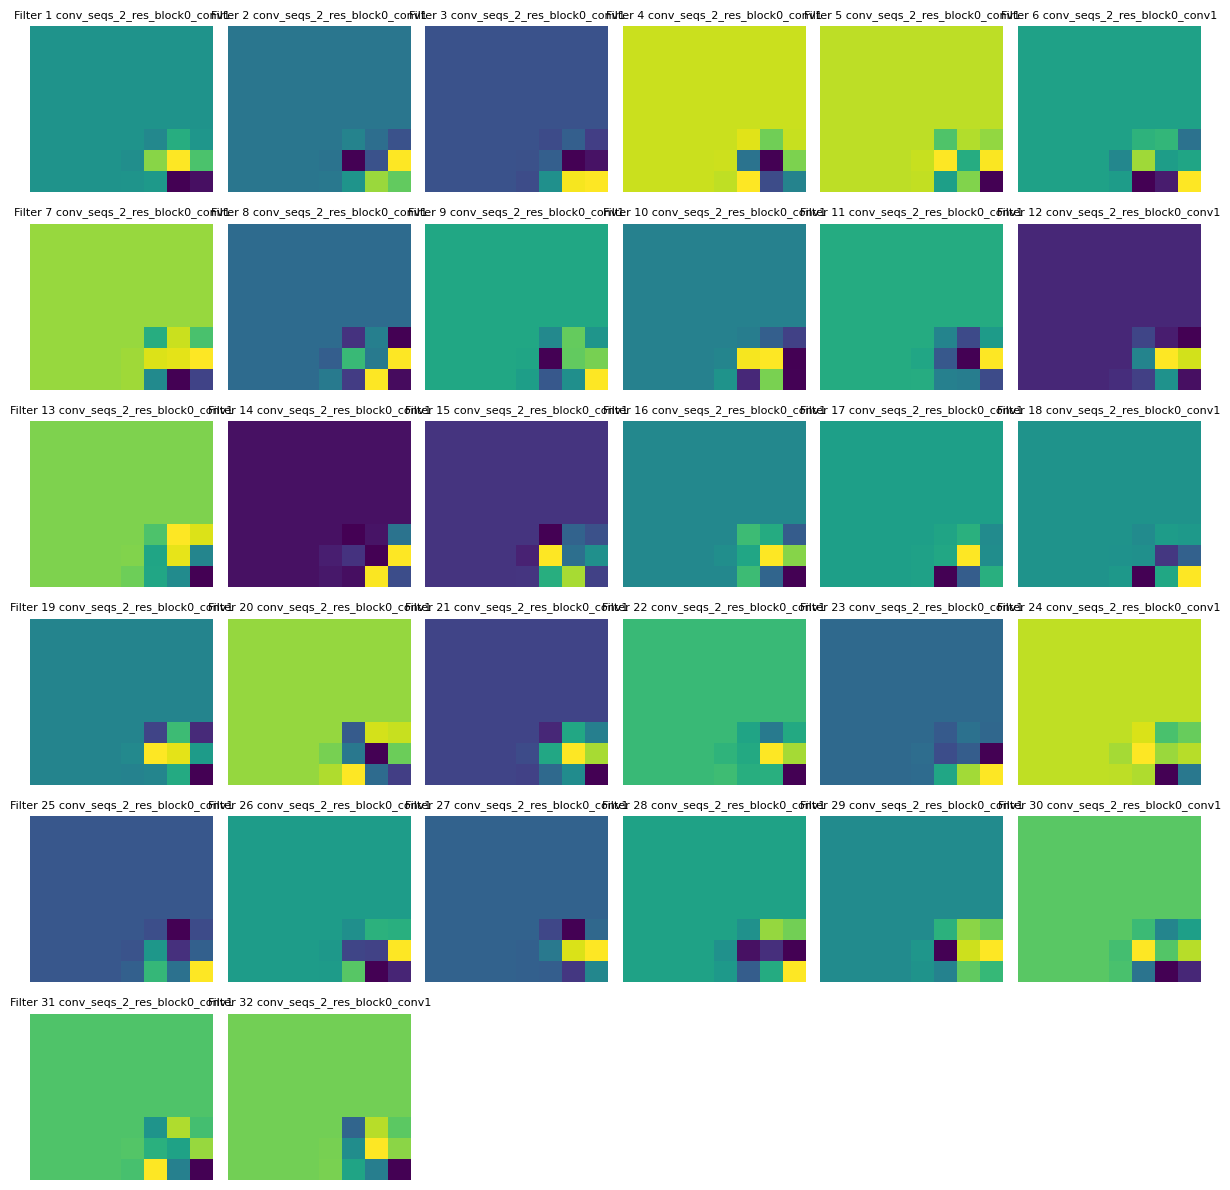

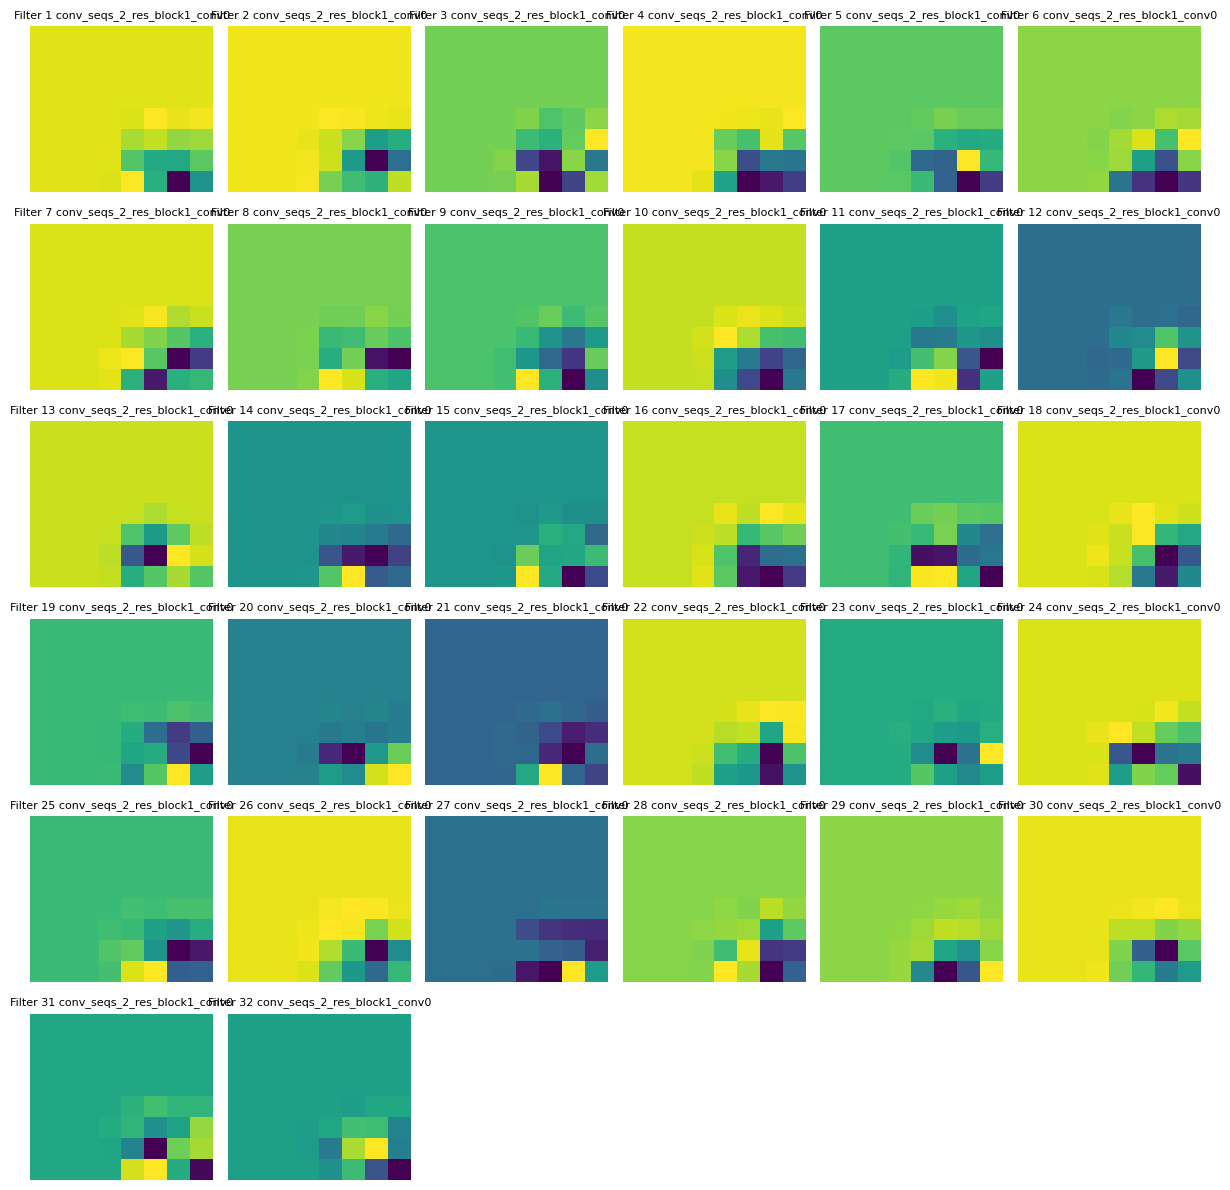

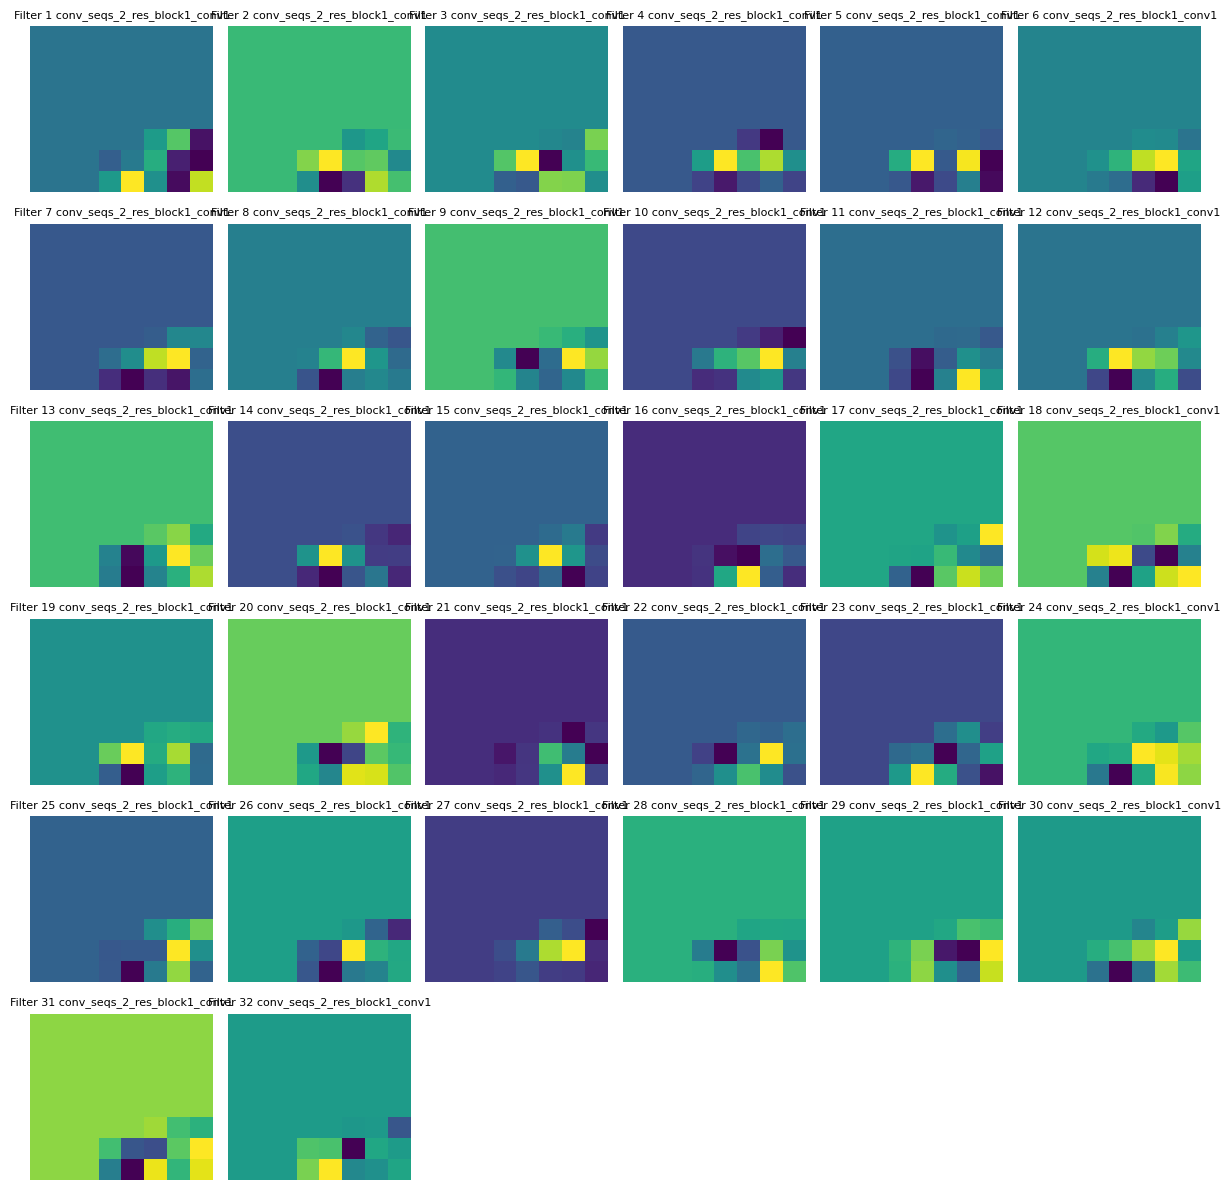

In [ ]:
key_gem_differences = helpers.compute_activation_differences(gem_activations,key_activations)
helpers.plot_activations_for_layers(key_gem_differences, all_layers)


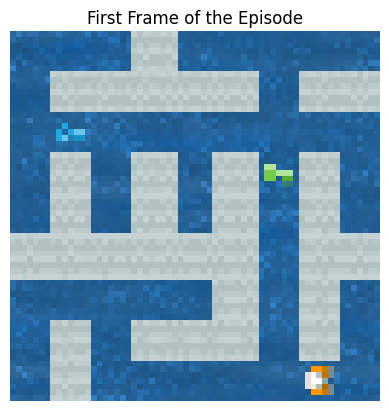

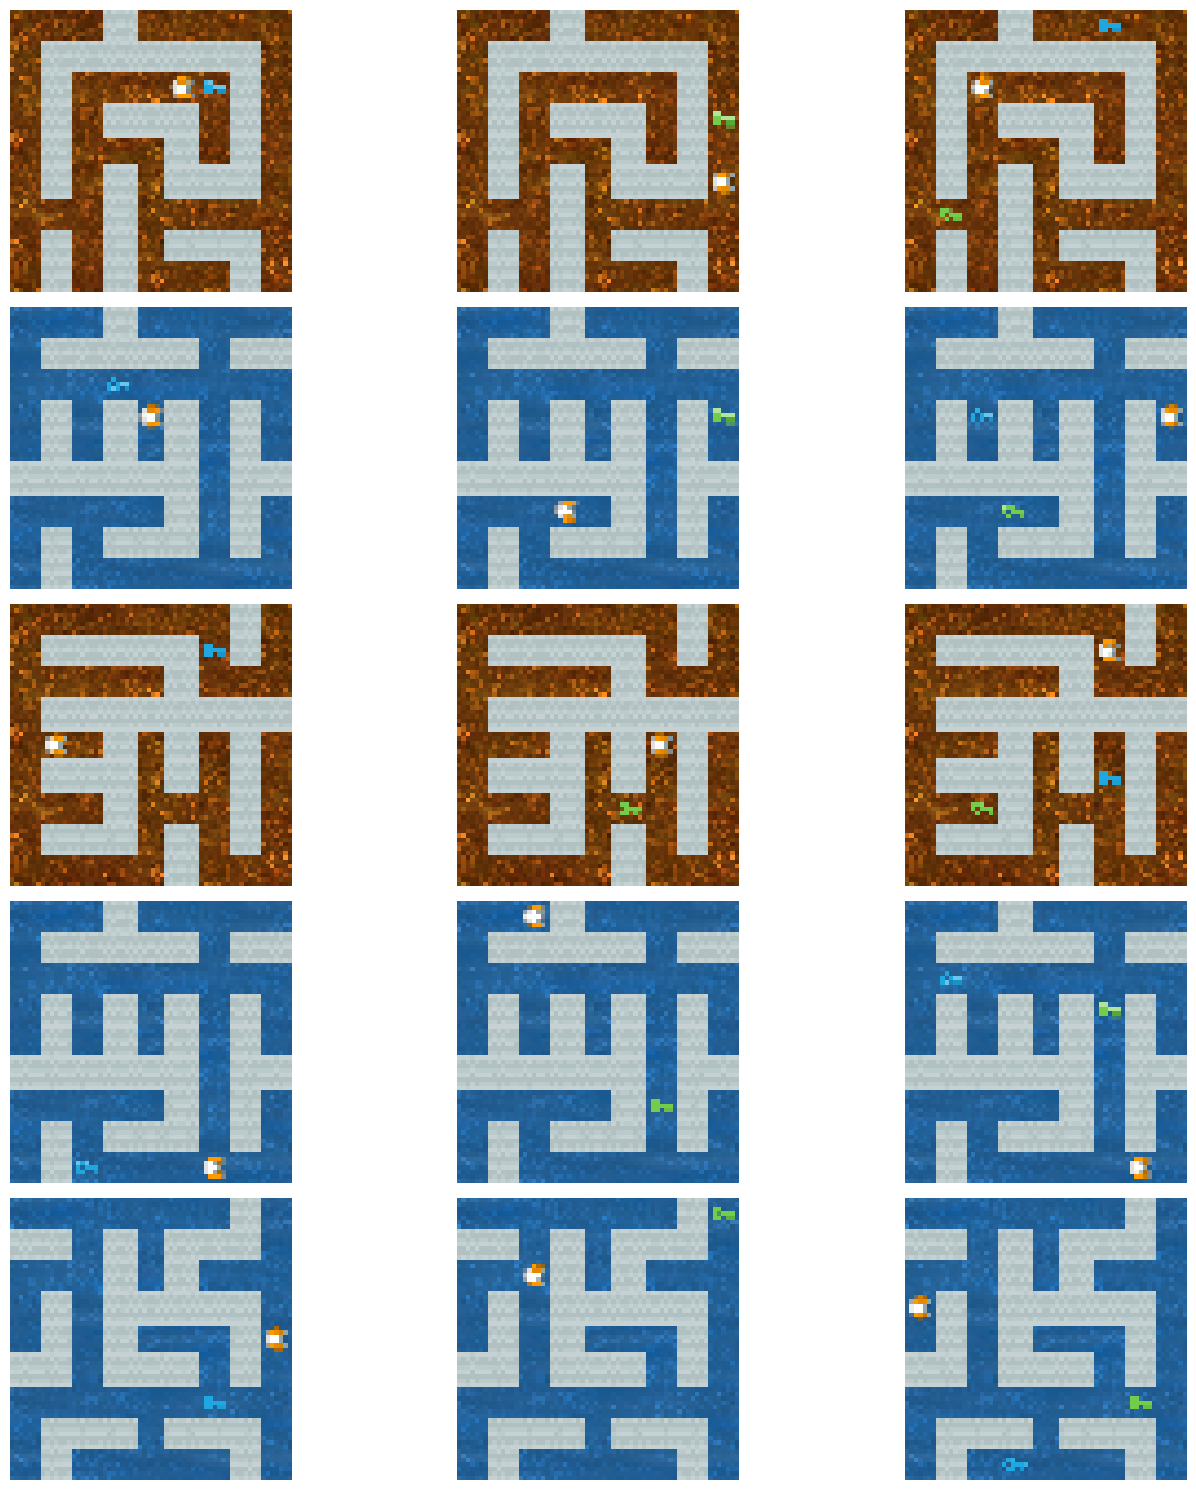

In [ ]:
num_samples = 5
num_levels = 100
key_color_combinations = [['blue'], ['green'], ['blue', 'green']]
observations_list = heist.create_key_states(key_color_combinations, num_samples, num_levels)


plt.imshow(observations_list[3][2].transpose(1, 2, 0))
plt.title("First Frame of the Episode")
plt.axis('off')
plt.show()



import itertools
fig, axs = plt.subplots(5, 3, figsize=(15, 15))  # Adjusted to create a 5x3 grid
for (i, j), obs in zip(itertools.product(range(5), range(3)), itertools.chain.from_iterable(observations_list)):
    axs[i, j].imshow(obs.transpose(1, 2, 0))
    # axs[i, j].set_title(f"Sample {j+1}, Obs {i+1}")
    axs[i, j].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
obs_list = heist.create_gem_states(5)

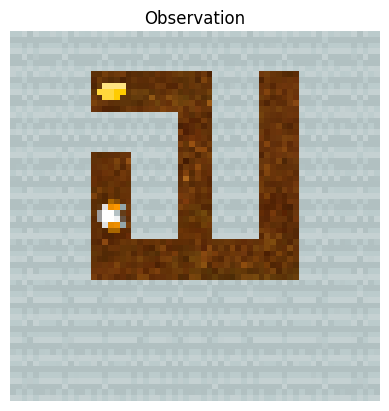

In [ ]:
helpers.plot_single_observation(obs_list[2].transpose(1, 2, 0))

# Train Linear probe

In [112]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import src.probing as probing


In [ ]:
def create_activation_dataset(dataset, model, layer_paths):
    activation_dataset = {
        "gem": [],
        "blue_key": [],
        "green_key": [],
        "red_key": [],
        "blue_lock": [],
        "green_lock": [],
        "red_lock": []
    }

    for category in dataset:
        for obs in dataset[category]:
            obs_rgb = helpers.observation_to_rgb(obs)
            model_activations = ModelActivations(model)
            _, activations = model_activations.run_with_cache(obs_rgb, layer_paths)
            model_activations.clear_hooks()


            activation_dataset[category].append(activations)

    return activation_dataset


In [126]:
# Create classified dataset
classified_dataset = heist.create_classified_dataset(num_samples_per_category=900, num_levels=0)

# Load the model
model = helpers.load_model(model_path="../model_901.0.pt")

# Create activation dataset
activation_dataset = helpers.create_objective_activation_dataset(classified_dataset, model, ['hidden_fc', 'logits_fc', 'value_fc'])



In [135]:
category_results= probing.linear_probe_multiclass(activation_dataset, "logits_fc")
print(category_results["test_accuracy"])
print(category_results["classification_report"])

0.30317460317460315
              precision    recall  f1-score   support

         gem       0.36      0.55      0.43       166
    blue_key       0.30      0.36      0.33       179
   green_key       0.23      0.20      0.22       181
     red_key       0.35      0.39      0.37       187
   blue_lock       0.32      0.22      0.26       188
  green_lock       0.22      0.13      0.16       197
    red_lock       0.28      0.30      0.29       162

    accuracy                           0.30      1260
   macro avg       0.29      0.31      0.29      1260
weighted avg       0.29      0.30      0.29      1260



In [ ]:
def plot_class_precision(class_precision_dict):
    # Enhanced colors for a more solid look
    enhanced_colors = {
        'gem': '#ffd700',  # Gold for "gem"
        'blue_key': '#007bff',  # Strong blue
        'green_key': '#28a745',  # Strong green
        'red_key': '#dc3545',  # Strong red
        'blue_lock': '#0056b3',  # Deeper blue
        'green_lock': '#1e7e34',  # Deeper green
        'red_lock': '#b31b1b'  # Deeper red
    }

    # Plotting with enhanced colors
    fig, ax = plt.subplots(figsize=(10, 6))
    for class_name, precision in class_precision_dict.items():
        ax.bar(class_name, precision, color=enhanced_colors.get(class_name, 'gray'))  # Default to gray if no color specified

    ax.set_xlabel('Class')
    ax.set_ylabel('Precision')
    ax.set_title('Precision for Each Class with Enhanced Colors')
    plt.xticks(rotation=45)  # Rotate class labels for better visibility
    plt.show()


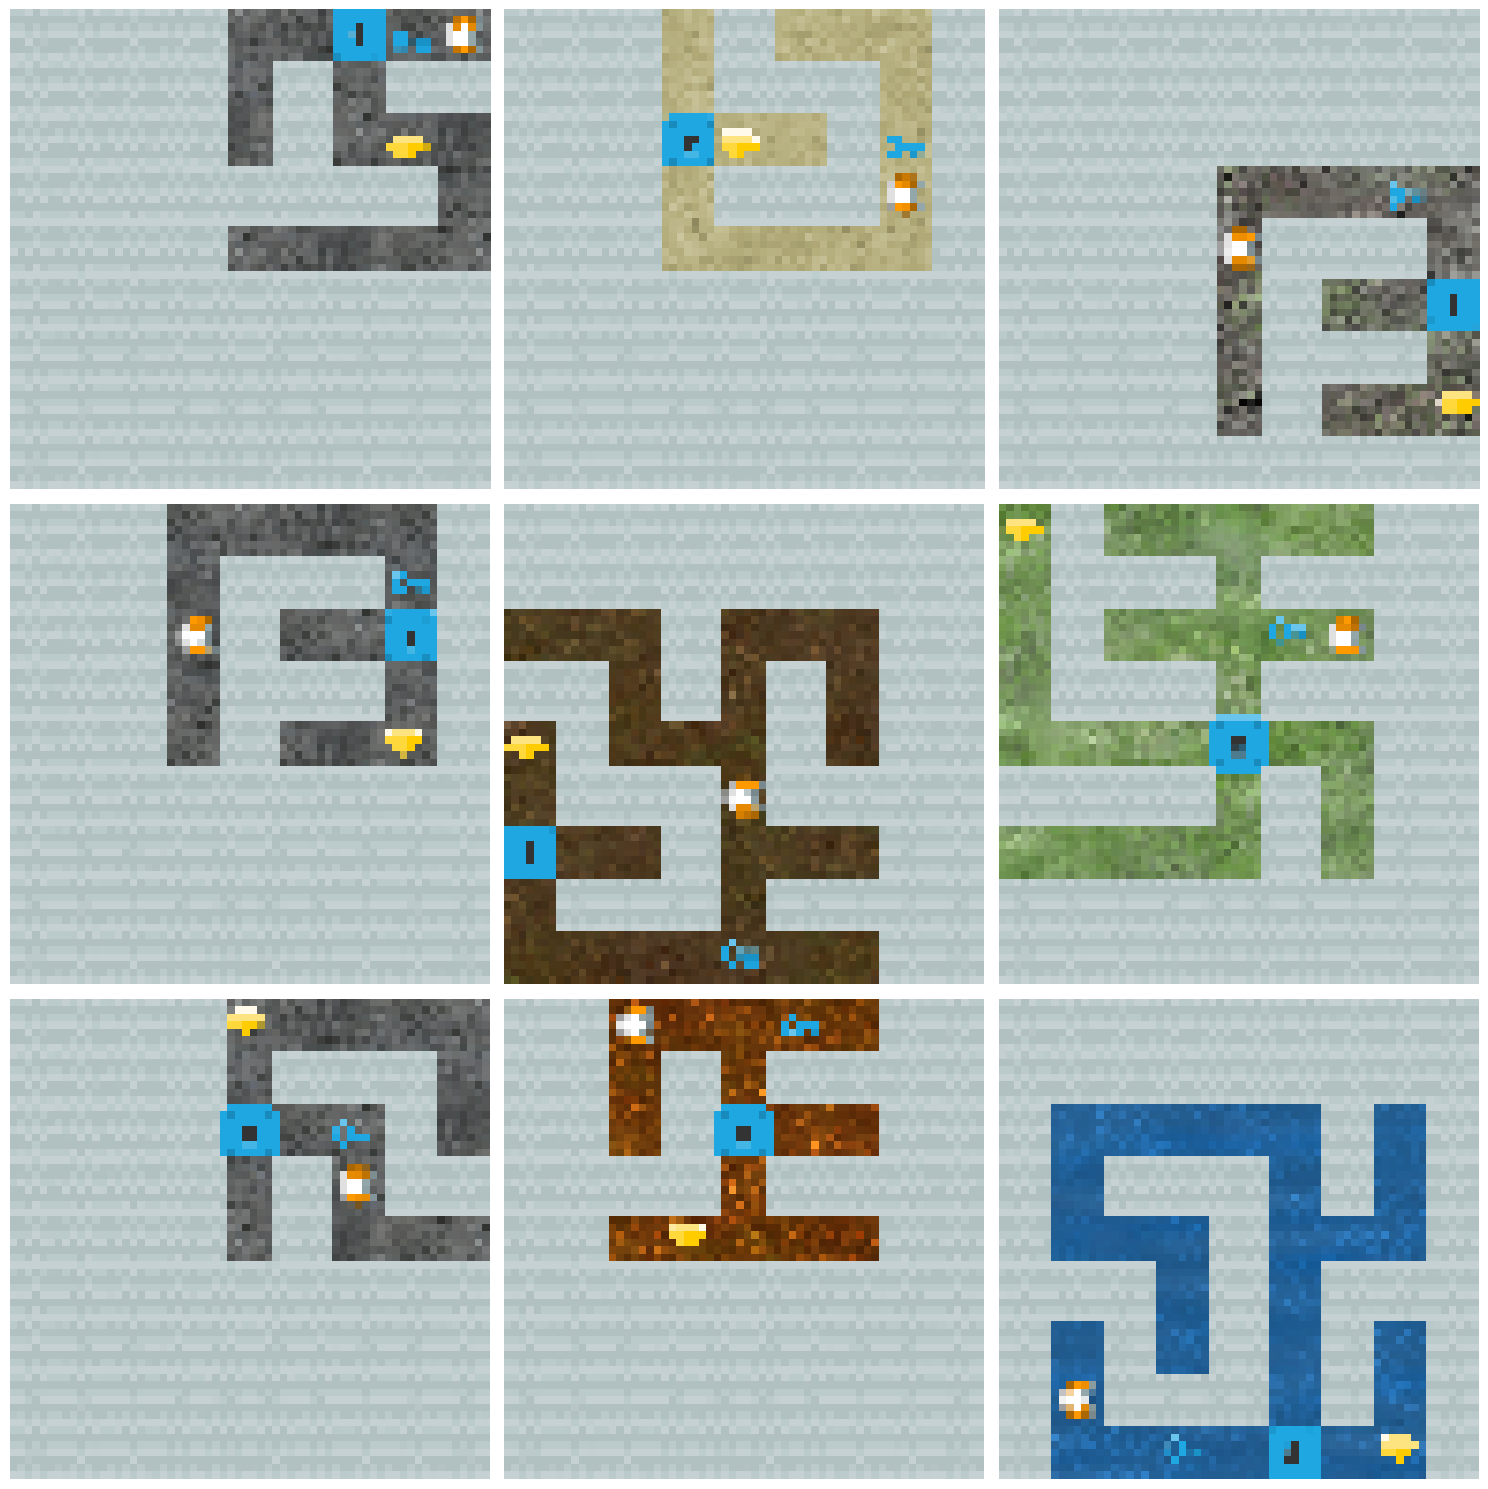

In [103]:
import matplotlib.pyplot as plt
import itertools

# Assuming 'dataset' is your data structure and it contains at least 15 images under the "blue_key" key
images = classified_dataset["blue_key"]  # Access the list of images
n_samples = 9  # Number of samples to display

# Create a figure with subplots in a 5x3 grid
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over the first 15 images (ensuring there are at least 15)
for idx, img in enumerate(images[:n_samples]):
    i, j = divmod(idx, 3)  # Calculate subplot grid indices
    axs[i, j].imshow(img)  # Display the image on the corresponding subplot
    axs[i, j].axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Show the plot


In [127]:
helpers.plot_activations_for_layers(activation_dataset["gem"][0], layer_paths=["conv_seqs_0"])

No activations found for layer: conv_seqs_0


In [ ]:
torch.equal(torch.tensor(activation_dataset["blue_key"][2]["conv_seqs_0_conv"][0]), torch.tensor((activation_dataset["blue_key"][1]["conv_seqs_0_conv"][0])))

/var/folders/58/f16y6j7x0j5d0vv3pvq80c680000gn/T/ipykernel_901/1014579437.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.equal(torch.tensor(activation_dataset["blue_key"][2]["conv_seqs_0_conv"][0]), torch.tensor((activation_dataset["blue_key"][1]["conv_seqs_0_conv"][0])))


False

In [137]:
results_dataframe = probing.linear_probe_per_category_using_probes(activation_dataset, 'hidden_fc', model_type='classifier', test_size=0.2, random_state=42)
results_dataframe["test_accuracy"]

/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer 

0    0.940476
1    0.816667
2    0.866667
3    0.814286
4    0.792857
5    0.785714
6    0.800000
Name: test_accuracy, dtype: float64

In [ ]:

single_class_category_results, single_class_result= linear_probe_per_category(activation_dataset, "hidden_fc")

NameError: name 'linear_probe_per_category' is not defined

In [ ]:
# Example usage
# activation_dataset and layer_path need to be defined as per your specific setup
results_dataframe = probing.linear_probe_per_category_using_probes(activation_dataset, 'hidden_fc', model_type='classifier', test_size=0.2, random_state=42)

y_pred = single_class_result["model"].predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0])

In [127]:
from sklearn.metrics import accuracy_score, classification_report



category_results= probing.linear_probe_multiclass(activation_dataset, "logits_fc")
print(category_results["test_accuracy"])
print(category_results["classification_report"])
category_results["conf_matrix"]

0.28888888888888886
              precision    recall  f1-score   support

         gem       0.35      0.48      0.41       174
    blue_key       0.31      0.42      0.35       174
   green_key       0.25      0.22      0.23       179
     red_key       0.32      0.35      0.33       186
   blue_lock       0.21      0.14      0.17       175
  green_lock       0.21      0.15      0.17       200
    red_lock       0.29      0.29      0.29       172

    accuracy                           0.29      1260
   macro avg       0.28      0.29      0.28      1260
weighted avg       0.28      0.29      0.28      1260



array([[96, 34,  5,  1, 17,  5,  4],
       [23, 62, 10,  0, 17,  9,  8],
       [11, 29, 39, 33,  5, 25, 16],
       [ 0,  1, 27, 53,  2, 15, 46],
       [53, 56, 12,  1, 16, 15,  5],
       [14, 11, 17, 34, 13, 19, 10],
       [ 7,  7, 14, 48,  1,  8, 54]])

In [ ]:
def plot_class_precision_with_title(class_precision_dict, title):
    # Enhanced colors for a more solid look
    enhanced_colors = {
        'top_left': '#ffd700',  # Gold for "top_left"
        'top_right': '#007bff',  # Strong blue
        'bottom_left': '#28a745',  # Strong green
        'bottom_right': '#dc3545',  # Strong red
    }

    # Plotting with enhanced colors
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(class_precision_dict.keys(), class_precision_dict.values(), color=[enhanced_colors.get(x, 'gray') for x in class_precision_dict.keys()])

    ax.set_xlabel('Class')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    plt.xticks(rotation=45)  # Rotate class labels for better visibility

    # Adding the precision values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')  # Align center horizontally

    plt.show()



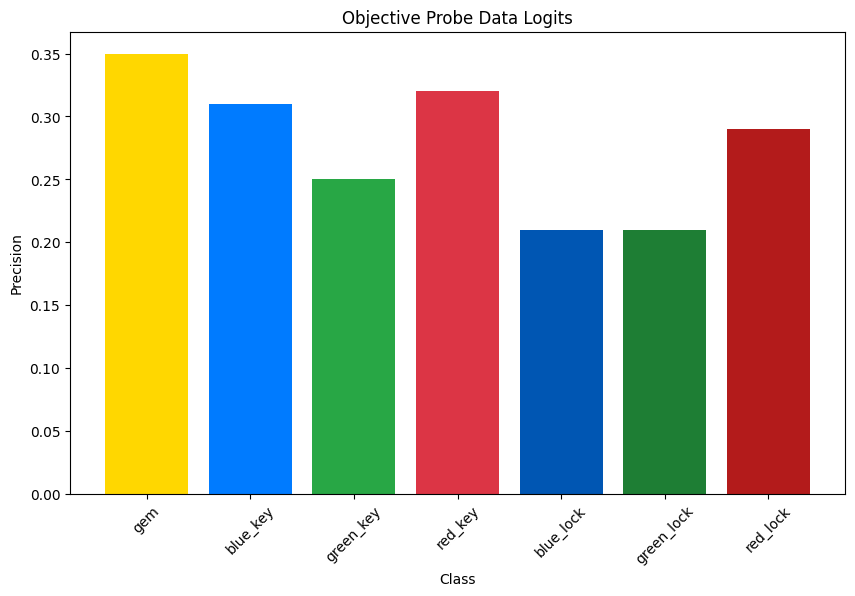

In [138]:
import matplotlib.pyplot as plt

# Your data
new_classification_data = """
         precision    recall  f1-score   support
         gem       0.35      0.48      0.41       174
    blue_key       0.31      0.42      0.35       174
   green_key       0.25      0.22      0.23       179
     red_key       0.32      0.35      0.33       186
   blue_lock       0.21      0.14      0.17       175
  green_lock       0.21      0.15      0.17       200
    red_lock       0.29      0.29      0.29       172
"""

# Parsing the new data
lines = new_classification_data.strip().split('\n')[1:]  # Skip the header
class_precision_dict = {}
for line in lines:
    parts = line.split()
    class_name = parts[0]
    precision_value = float(parts[1])
    class_precision_dict[class_name] = precision_value

# Function to plot the data
def plot_objective_probe_data(class_precision_dict):
    # Colors for direction-related classes
    enhanced_colors = {
        'gem': '#ffd700',  # Gold for "gem"
        'blue_key': '#007bff',  # Strong blue
        'green_key': '#28a745',  # Strong green
        'red_key': '#dc3545',  # Strong red
        'blue_lock': '#0056b3',  # Deeper blue
        'green_lock': '#1e7e34',  # Deeper green
        'red_lock': '#b31b1b'  # Deeper red
    }

    # Plotting with specific colors
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(class_precision_dict.keys(), class_precision_dict.values(), color=[enhanced_colors.get(x, 'gray') for x in class_precision_dict.keys()])

    ax.set_xlabel('Class')
    ax.set_ylabel('Precision')
    ax.set_title('Objective Probe Data Logits')
    plt.xticks(rotation=45)  # Rotate class labels for better visibility

    # Adding the precision values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        ax

plot_objective_probe_data(class_precision_dict)

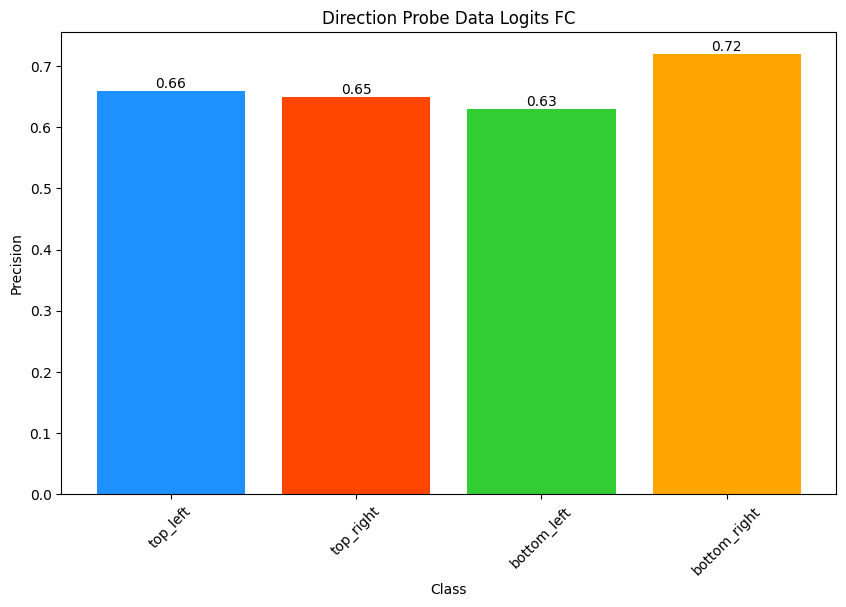

In [128]:

new_classification_data = """
          precision    recall  f1-score   support
    top_left       0.66      0.59      0.62       193
   top_right       0.65      0.77      0.70       179
 bottom_left       0.63      0.65      0.64       170
bottom_right       0.72      0.65      0.68       178
"""

# Parsing the new data
new_lines = new_classification_data.strip().split('\n')[1:]  # Include all classes
new_class_precision_dict = {}

for line in new_lines:
    parts = line.split(maxsplit=4)  # Ensure splitting is correctly done
    class_name = parts[0]
    precision_value = float(parts[1])
    new_class_precision_dict[class_name] = precision_value

# Update the function for new title and color scheme for direction-related classes
def plot_direction_probe_data(class_precision_dict):
    # Colors for direction-related classes
    direction_colors = {
        'top_left': '#1e90ff',  # Dodger blue
        'top_right': '#ff4500',  # Orange red
        'bottom_left': '#32cd32',  # Lime green
        'bottom_right': '#ffa500'  # Orange
    }

    # Plotting with specific colors
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(class_precision_dict.keys(), class_precision_dict.values(), color=[direction_colors.get(x, 'gray') for x in class_precision_dict.keys()])

    ax.set_xlabel('Class')
    ax.set_ylabel('Precision')
    ax.set_title('Direction Probe Data Logits FC')
    plt.xticks(rotation=45)  # Rotate class labels for better visibility

    # Adding the precision values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')  # Align center horizontally

    plt.show()

# Plotting the new data
plot_direction_probe_data(new_class_precision_dict)


In [ ]:
X = torch.cat([torch.stack([act["hidden_fc"][0] for act in activation_dataset[category]])
                   for category in activation_dataset.keys()])
y = torch.cat([torch.full((len(activation_dataset[category]),), i)
                   for i, category in enumerate(activation_dataset.keys())]).long()

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=None
    )
y_pred = category_results["model"].predict(X_test)

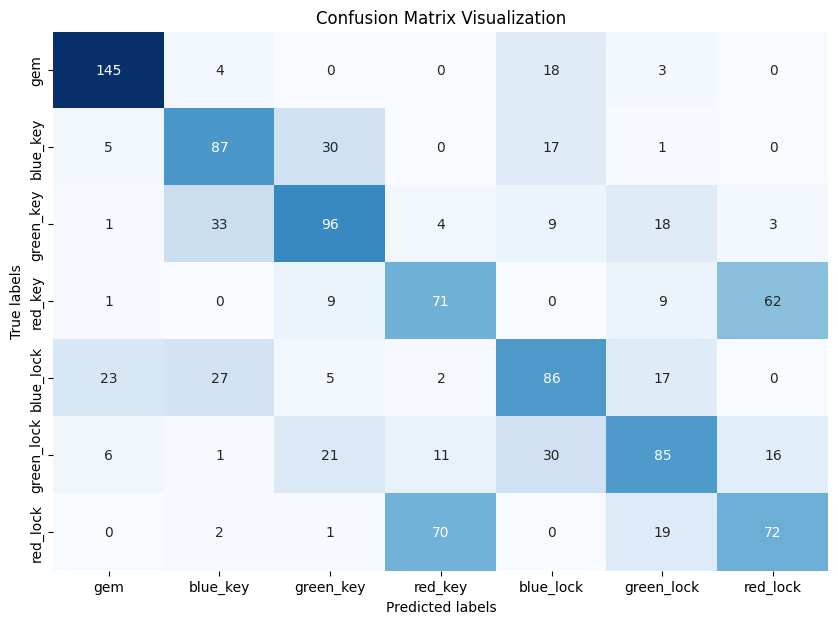

In [133]:
helpers.plot_confusion_matrix(category_results["conf_matrix"], activation_dataset)

Accuracy: 0.24285714285714285


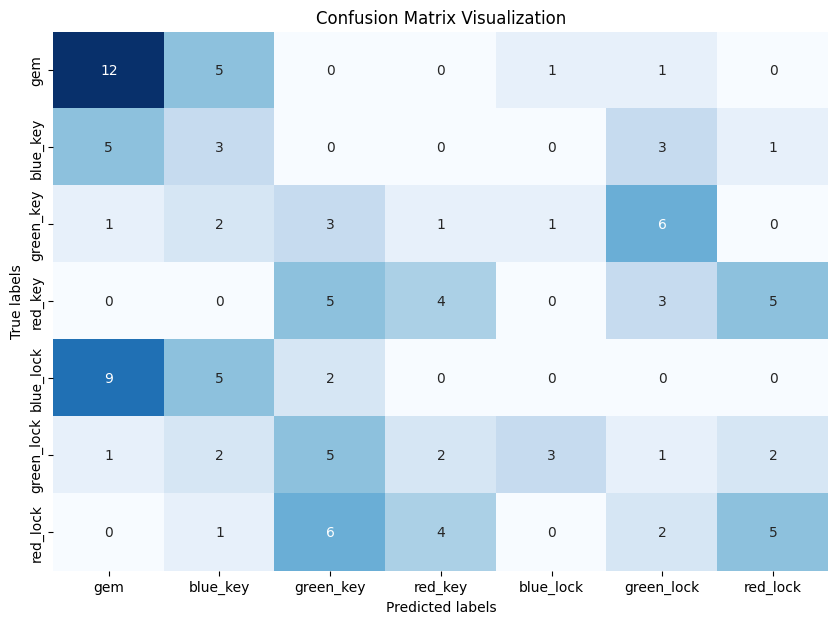

In [115]:
category_results= probing.linear_probe_multiclass(activation_dataset, "logits_fc")
print("Accuracy:", category_results["test_accuracy"])
helpers.plot_confusion_matrix(category_results["conf_matrix"], activation_dataset)

In [ ]:
print(category_results["classification_report"])

              precision    recall  f1-score   support

         gem       0.34      0.43      0.38        23
    blue_key       0.18      0.25      0.21        16
   green_key       0.21      0.12      0.15        25
     red_key       0.19      0.29      0.23        17
   blue_lock       0.22      0.21      0.22        19
  green_lock       0.17      0.12      0.14        17
    red_lock       0.33      0.26      0.29        23

    accuracy                           0.24       140
   macro avg       0.24      0.24      0.23       140
weighted avg       0.24      0.24      0.24       140



# Creating a directional dataset

We want to figure out if the logits_fc layer is involved with navigation, how much the hidden_fc layer plays a role in navigation, and if we can separate out the neurons involved with navigation in the hidden_fc layer. If we can determine this last thing then we can potentially control the movement of our player by manipulating the activations of the network.

To begin exploring this we need a dataset that can allow us to isolate these features in the network. Thus the goal is to create categories

In [ ]:
num_levels = 5
venv = heist.create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=num_levels)
state = heist.state_from_venv(venv, 0)

full_grid = state.full_grid(with_mouse=False)
entities = state.state_vals["ents"]
legal_mouse_positions = heist.get_legal_mouse_positions(full_grid, entities)

unchanged_obs= venv.reset()


state.remove_all_entities()


state =  heist.set_mouse_to_center(state)

state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    obs = venv.reset()



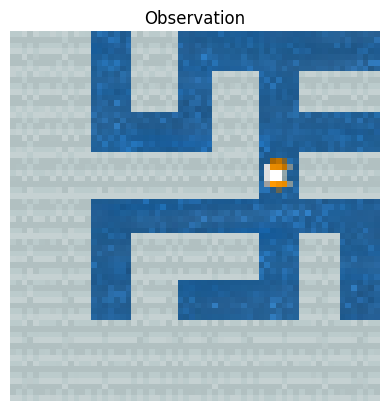

In [ ]:
helpers.plot_single_observation(helpers.observation_to_rgb(obs))

In [116]:
dataset = heist.create_direction_dataset()

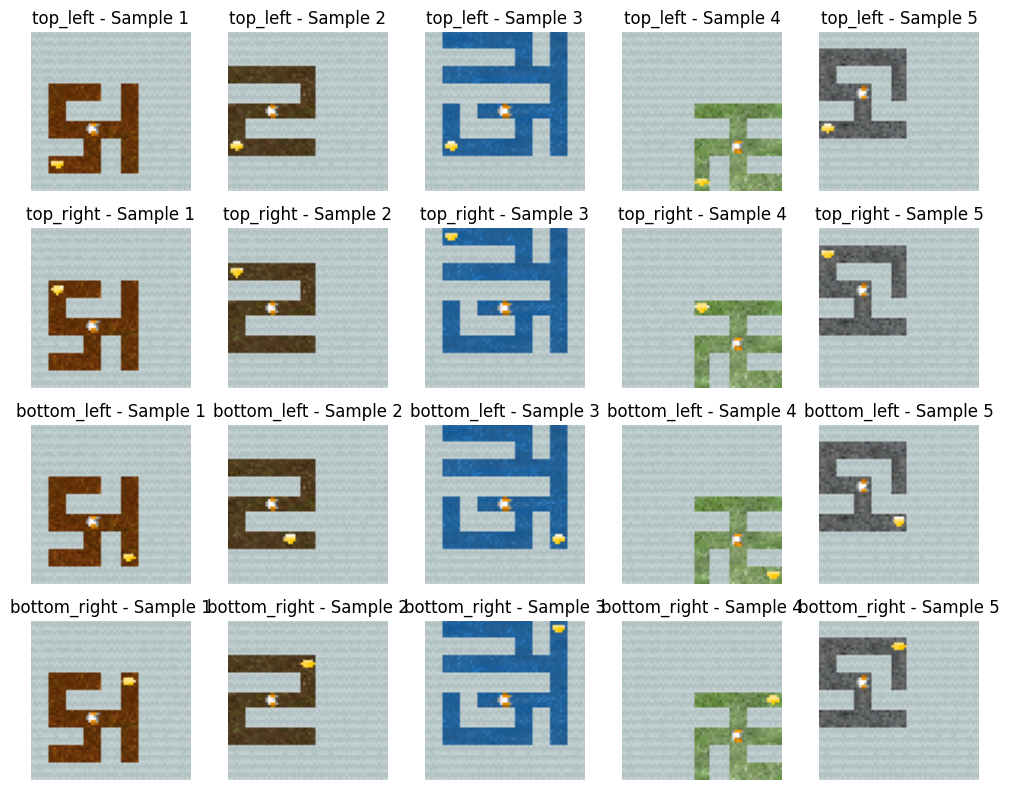

In [ ]:
import matplotlib.pyplot as plt

def visualize_dataset(dataset, num_samples_per_category=5):
    categories = list(dataset.keys())
    num_categories = len(categories)

    fig, axes = plt.subplots(num_categories, num_samples_per_category, figsize=(num_samples_per_category * 2, num_categories * 2))

    for i, category in enumerate(categories):
        samples = dataset[category]
        for j, sample in enumerate(samples):
            ax = axes[i, j] if num_categories > 1 else axes[j]
            ax.imshow(sample)
            ax.set_title(f"{category} - Sample {j+1}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

visualize_dataset(dataset)

In [119]:
dataset = heist.create_direction_dataset(900)


In [120]:
def create_direction_activation_dataset(dataset, model, layer_paths):
    activation_dataset = {
        "top_left": [],
        "top_right": [],
        "bottom_left": [],
        "bottom_right": []
    }

    for category in dataset:
        for obs in dataset[category]:
            obs_rgb = helpers.observation_to_rgb(obs)
            model_activations = helpers.ModelActivations(model)
            _, activations = model_activations.run_with_cache(obs_rgb, layer_paths)
            model_activations.clear_hooks()


            activation_dataset[category].append(activations)

    return activation_dataset


In [121]:
model = helpers.load_model()
layer_names = helpers.get_model_layer_names(model)

direction_activation_dataset = create_direction_activation_dataset(dataset, model, layer_names)

In [ ]:
direction_activation_dataset.keys()

dict_keys(['top_left', 'top_right', 'bottom_left', 'bottom_right'])

              precision    recall  f1-score   support

    top_left       0.66      0.59      0.62       193
   top_right       0.65      0.77      0.70       179
 bottom_left       0.63      0.65      0.64       170
bottom_right       0.72      0.65      0.68       178

    accuracy                           0.66       720
   macro avg       0.66      0.66      0.66       720
weighted avg       0.66      0.66      0.66       720



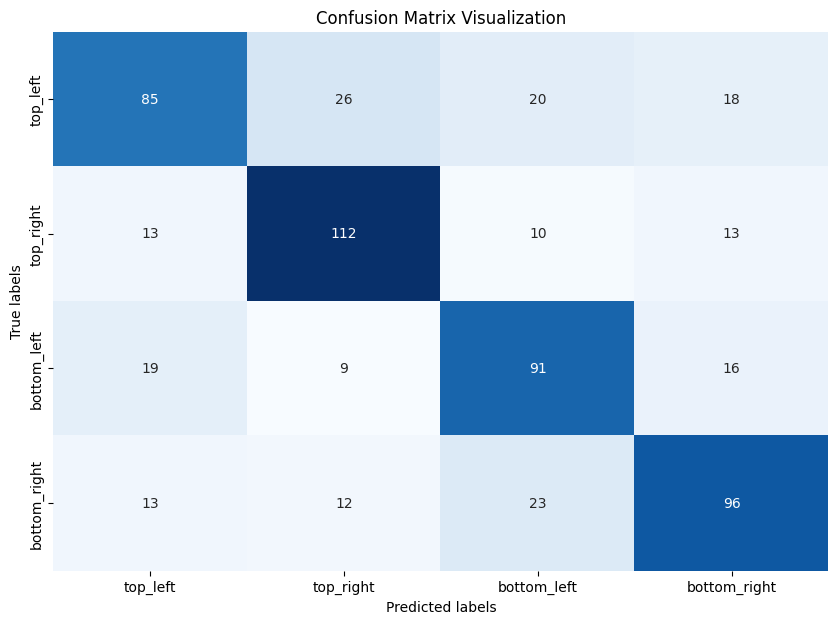

In [125]:
category_results= probing.linear_probe_multiclass(direction_activation_dataset, "logits_fc")
print(category_results["classification_report"])
helpers.plot_confusion_matrix(category_results["conf_matrix"], direction_activation_dataset)

In [ ]:
print(category_results["test_accuracy"])


0.9125


0.6375
              precision    recall  f1-score   support

    top_left       0.73      0.70      0.71        23
   top_right       0.70      0.70      0.70        20
 bottom_left       0.48      0.65      0.55        17
bottom_right       0.67      0.50      0.57        20

    accuracy                           0.64        80
   macro avg       0.64      0.64      0.63        80
weighted avg       0.65      0.64      0.64        80



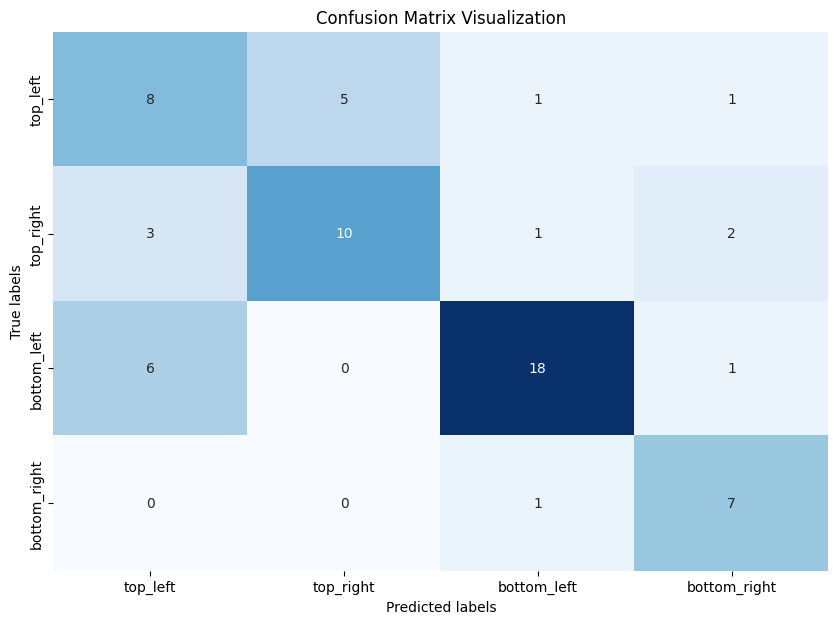

In [ ]:
category_results= linear_probe_multiclass(direction_activation_dataset, "logits_fc")
print(category_results["test_accuracy"])
print(category_results["classification_report"])
helpers.plot_confusion_matrix(category_results["conf_matrix"], direction_activation_dataset)

## Probing convolution layers for objectives

In [ ]:
layer_names = helpers.get_model_layer_names(model)


['conv_seqs',
 'conv_seqs.0',
 'conv_seqs.0.conv',
 'conv_seqs.0.max_pool2d',
 'conv_seqs.0.res_block0',
 'conv_seqs.0.res_block0.conv0',
 'conv_seqs.0.res_block0.conv1',
 'conv_seqs.0.res_block1',
 'conv_seqs.0.res_block1.conv0',
 'conv_seqs.0.res_block1.conv1',
 'conv_seqs.1',
 'conv_seqs.1.conv',
 'conv_seqs.1.max_pool2d',
 'conv_seqs.1.res_block0',
 'conv_seqs.1.res_block0.conv0',
 'conv_seqs.1.res_block0.conv1',
 'conv_seqs.1.res_block1',
 'conv_seqs.1.res_block1.conv0',
 'conv_seqs.1.res_block1.conv1',
 'conv_seqs.2',
 'conv_seqs.2.conv',
 'conv_seqs.2.max_pool2d',
 'conv_seqs.2.res_block0',
 'conv_seqs.2.res_block0.conv0',
 'conv_seqs.2.res_block0.conv1',
 'conv_seqs.2.res_block1',
 'conv_seqs.2.res_block1.conv0',
 'conv_seqs.2.res_block1.conv1',
 'hidden_fc',
 'logits_fc',
 'value_fc']

In [ ]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

def linear_probe_per_filter_using_probes(
    activation_dataset,
    layer_path,
    model_type="classifier",
    test_size=0.2,
    random_state=None,
    **regression_kwargs,
):
    results = []  # List to store data pairs
    filter_names = []  # List to store filter names for labeling purposes

    def linear_probes(xys, model_type, test_size, random_state, **kwargs):
        local_results = []
        for (X, y) in xys:
            X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=test_size, random_state=random_state)
            if model_type == "classifier":
                model = LogisticRegression(**kwargs)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)
            local_results.append((accuracy, report))
        return local_results

    for category in activation_dataset.keys():
        for filter_index in range(activation_dataset[category][0][layer_path][0].size(0)):
            # Extracting activations for each filter
            X_category = torch.stack([act[layer_path][0][filter_index].flatten() for act in activation_dataset[category]])
            y_category = torch.ones(len(activation_dataset[category])).long()

            X_rest = torch.cat([torch.stack([act[layer_path][0][filter_index].flatten() for act in activation_dataset[cat]])
                                for cat in activation_dataset.keys() if cat != category])
            y_rest = torch.zeros(len(X_rest)).long()

            X = torch.cat([X_category, X_rest])
            y = torch.cat([y_category, y_rest])

            filter_names.append(f"{category}_filter_{filter_index}")
            results.append((X, y))

    probing_results = linear_probes(results, model_type=model_type, test_size=test_size, random_state=random_state, **regression_kwargs)

    results_df = pd.DataFrame({
        'filter': filter_names,
        'test_accuracy': [result[0] for result in probing_results],
        'classification_report': [result[1] for result in probing_results]
    })

    return results_df

# Example usage assuming you have defined 'activation_dataset' and know the layer path for convolutional layers
results_dataframe = linear_probe_per_filter_using_probes(activation_dataset, 'conv_seqs_1', model_type='classifier', test_size=0.2, random_state=42)


/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer 

In [ ]:
results_dataframe.head(30)

filter  test_accuracy  \
0    gem_filter_0       0.864286   
1    gem_filter_1       0.857143   
2    gem_filter_2       0.907143   
3    gem_filter_3       0.864286   
4    gem_filter_4       0.907143   
5    gem_filter_5       0.935714   
6    gem_filter_6       0.814286   
7    gem_filter_7       0.900000   
8    gem_filter_8       0.914286   
9    gem_filter_9       0.871429   
10  gem_filter_10       0.914286   
11  gem_filter_11       0.885714   
12  gem_filter_12       0.900000   
13  gem_filter_13       0.871429   
14  gem_filter_14       0.935714   
15  gem_filter_15       0.871429   
16  gem_filter_16       0.907143   
17  gem_filter_17       0.885714   
18  gem_filter_18       0.900000   
19  gem_filter_19       0.885714   
20  gem_filter_20       0.900000   
21  gem_filter_21       0.907143   
22  gem_filter_22       0.914286   
23  gem_filter_23       0.942857   
24  gem_filter_24       0.892857   
25  gem_filter_25       0.928571   
26  gem_filter_26       0.878571   
27  gem_filter_27       0.892857   
28  gem_filter_28       0.878571   
29  gem_filter_29       0.864286   

                                classification_report  
0   {'0': {'precision': 0.8636363636363636, 'recal...  
1   {'0': {'precision': 0.8571428571428571, 'recal...  
2   {'0': {'precision': 0.9112903225806451, 'recal...  
3   {'0': {'precision': 0.8582089552238806, 'recal...  
4   {'0': {'precision': 0.9322033898305084, 'recal...  
5   {'0': {'precision': 0.9568965517241379, 'recal...  
6   {'0': {'precision': 0.8449612403100775, 'recal...  
7   {'0': {'precision': 0.8914728682170543, 'recal...  
8   {'0': {'precision': 0.905511811023622, 'recall...  
9   {'0': {'precision': 0.888, 'recall': 0.9652173...  
10  {'0': {'precision': 0.9401709401709402, 'recal...  
11  {'0': {'precision': 0.896, 'recall': 0.9739130...  
12  {'0': {'precision': 0.9105691056910569, 'recal...  
13  {'0': {'precision': 0.8702290076335878, 'recal...  
14  {'0': {'precision': 0.9274193548387096, 'recal...  
15  {'0': {'precision': 0.888, 'recall': 0.9652173...  
16  {'0': {'precision': 0.8984375, 'recall': 1.0, ...  
17  {'0': {'precision': 0.8837209302325582, 'recal...  
18  {'0': {'precision': 0.8976377952755905, 'recal...  
19  {'0': {'precision': 0.8778625954198473, 'recal...  
20  {'0': {'precision': 0.9316239316239316, 'recal...  
21  {'0': {'precision': 0.9112903225806451, 'recal...  
22  {'0': {'precision': 0.9256198347107438, 'recal...  
23  {'0': {'precision': 0.9421487603305785, 'recal...  
24  {'0': {'precision': 0.9032258064516129, 'recal...  
25  {'0': {'precision': 0.92, 'recall': 1.0, 'f1-s...  
26  {'0': {'precision': 0.8888888888888888, 'recal...  
27  {'0': {'precision': 0.8968253968253969, 'recal...  
28  {'0': {'precision': 0.8712121212121212, 'recal...  
29  {'0': {'precision': 0.9137931034482759, 'recal...

In [ ]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

def analyze_filter_performance(activation_dataset, layer_path, model_type="classifier", test_size=0.2, random_state=None):
    results = []
    for category in activation_dataset.keys():
        for filter_index in range(activation_dataset[category][0][layer_path][0].size(0)):
            # Prepare data for this filter across this category
            X_category = torch.stack([act[layer_path][0][filter_index].flatten() for act in activation_dataset[category]])
            y_category = torch.ones(len(activation_dataset[category])).long()

            X_rest = torch.cat([torch.stack([act[layer_path][0][filter_index].flatten() for act in activation_dataset[cat]])
                                for cat in activation_dataset.keys() if cat != category])
            y_rest = torch.zeros(len(X_rest)).long()

            X = torch.cat([X_category, X_rest])
            y = torch.cat([y_category, y_rest])

            # Train and test classifier
            X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=test_size, random_state=random_state)
            model = LogisticRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)

            # Store results
            results.append({
                'category': category,
                'filter_index': filter_index,
                'accuracy': accuracy,
                'precision': report['weighted avg']['precision'],
                'recall': report['weighted avg']['recall'],
                'f1_score': report['weighted avg']['f1-score']
            })

    return pd.DataFrame(results)

# Example usage
results_df = analyze_filter_performance(activation_dataset, 'conv_seqs_2_res_block1_conv0')


/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bensturgeon/Lib

In [ ]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

def summarize_filter_performance(activation_dataset, layer_path, model_type="classifier", test_size=0.2, random_state=None):
    filter_summary = []
    models = {}
    for filter_index in range(activation_dataset[next(iter(activation_dataset))][0][layer_path][0].size(0)):
        filter_results = []
        filter_models = {}
        for category in activation_dataset.keys():
            # Prepare data for this filter across this category
            X_category = torch.stack([act[layer_path][0][filter_index].flatten() for act in activation_dataset[category]])
            y_category = torch.ones(len(activation_dataset[category])).long()

            X_rest = torch.cat([torch.stack([act[layer_path][0][filter_index].flatten() for act in activation_dataset[cat]])
                                for cat in activation_dataset.keys() if cat != category])
            y_rest = torch.zeros(len(X_rest)).long()

            X = torch.cat([X_category, X_rest])
            y = torch.cat([y_category, y_rest])

            # Train and test classifier
            X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=test_size, random_state=random_state)
            model = LogisticRegression()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)

            # Collect results for this filter and category
            filter_results.append({
                'category': category,
                'accuracy': accuracy,
                'precision': report['weighted avg']['precision'],
                'recall': report['weighted avg']['recall'],
                'f1_score': report['weighted avg']['f1-score']
            })
            filter_models[category] = model
        
        # Analyze results for this filter
        df = pd.DataFrame(filter_results)
        best_performance = df.loc[df['accuracy'].idxmax()]
        worst_performance = df.loc[df['accuracy'].idxmin()]
        performance_range = best_performance['accuracy'] - worst_performance['accuracy']

        # Summarize this filter's results
        filter_summary.append({
            'filter_index': filter_index,
            'best_category': best_performance['category'],
            'best_accuracy': best_performance['accuracy'],
            'worst_category': worst_performance['category'],
            'worst_accuracy': worst_performance['accuracy'],
            'performance_range': performance_range
        })
        models[filter_index] = filter_models

    return models, pd.DataFrame(filter_summary)

# Example usage
models, results_summary = summarize_filter_performance(activation_dataset, 'conv_seqs_2_res_block1_conv0')


/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bensturgeon/Library/Caches/pypoetry/virtualenvs/ai-safety-camp-Y8XZewIj-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being s

In [ ]:
results_summary

filter_index best_category  best_accuracy worst_category  worst_accuracy  \
0              0      blue_key       0.914286     green_lock        0.771429   
1              1      red_lock       0.914286        red_key        0.792857   
2              2       red_key       0.900000     green_lock        0.828571   
3              3           gem       0.885714       red_lock        0.792857   
4              4      blue_key       0.878571        red_key        0.764286   
5              5     green_key       0.871429     green_lock        0.785714   
6              6           gem       0.907143     green_lock        0.807143   
7              7      blue_key       0.900000       red_lock        0.785714   
8              8    green_lock       0.864286       red_lock        0.757143   
9              9      blue_key       0.842857        red_key        0.750000   
10            10      blue_key       0.885714       red_lock        0.800000   
11            11           gem       0.892857        red_key        0.821429   
12            12           gem       0.900000       red_lock        0.792857   
13            13           gem       0.878571      green_key        0.821429   
14            14           gem       0.892857      blue_lock        0.814286   
15            15           gem       0.921429     green_lock        0.807143   
16            16       red_key       0.871429       red_lock        0.807143   
17            17      blue_key       0.885714      blue_lock        0.778571   
18            18     green_key       0.864286     green_lock        0.785714   
19            19           gem       0.857143        red_key        0.807143   
20            20           gem       0.942857     green_lock        0.814286   
21            21           gem       0.892857       red_lock        0.778571   
22            22           gem       0.907143        red_key        0.785714   
23            23           gem       0.900000       red_lock        0.800000   
24            24     blue_lock       0.864286        red_key        0.792857   
25            25    green_lock       0.864286        red_key        0.814286   
26            26      blue_key       0.907143        red_key        0.821429   
27            27           gem       0.900000       red_lock        0.835714   
28            28      blue_key       0.871429      blue_lock        0.800000   
29            29           gem       0.878571       blue_key        0.785714   
30            30           gem       0.864286     green_lock        0.785714   
31            31           gem       0.921429       blue_key        0.814286   

    performance_range  
0            0.142857  
1            0.121429  
2            0.071429  
3            0.092857  
4            0.114286  
5            0.085714  
6            0.100000  
7            0.114286  
8            0.107143  
9            0.092857  
10           0.085714  
11           0.071429  
12           0.107143  
13           0.057143  
14           0.078571  
15           0.114286  
16           0.064286  
17           0.107143  
18           0.078571  
19           0.050000  
20           0.128571  
21           0.114286  
22           0.121429  
23           0.100000  
24           0.071429  
25           0.050000  
26           0.085714  
27           0.064286  
28           0.071429  
29           0.092857  
30           0.078571  
31           0.107143

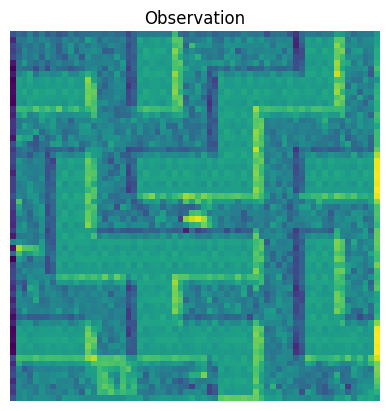

In [ ]:
helpers.plot_single_observation(activation_dataset["red_key"][45]["conv_seqs_2_res_block1_conv0"][0][14])



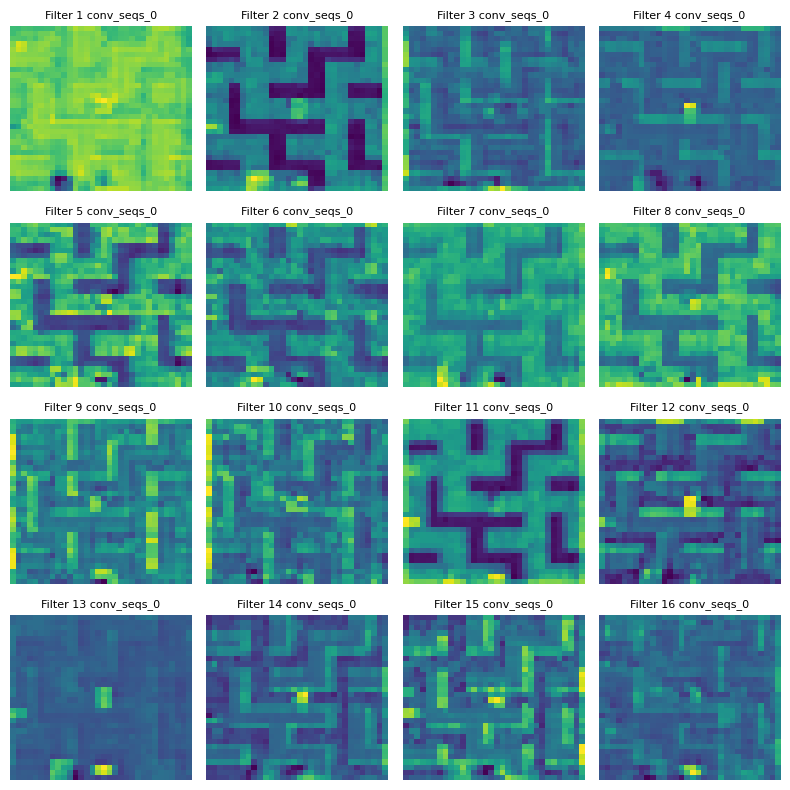

In [ ]:
helpers.plot_activations_for_layers(activations=activation_dataset["red_key"][45], layer_paths=["conv_seqs_0"])

In [ ]:
def predict_sample_category(models, sample_activation, layer_path):
    predictions = {}
    for filter_index, filter_models in models.items():
        filter_activation = sample_activation[layer_path][0][filter_index].flatten()
        for category, model in filter_models.items():
            prediction = model.predict([filter_activation.numpy()])
            predictions[(filter_index, category)] = prediction[0]
    return predictions

# Example usage:
sample_activation = activation_dataset["red_key"][45]
sample_predictions = predict_sample_category(models, sample_activation, 'conv_seqs_2_res_block1_conv0')


In [ ]:
sample_predictions



{(0, 'gem'): 0,
 (0, 'blue_key'): 0,
 (0, 'green_key'): 0,
 (0, 'red_key'): 1,
 (0, 'blue_lock'): 0,
 (0, 'green_lock'): 0,
 (0, 'red_lock'): 1,
 (1, 'gem'): 0,
 (1, 'blue_key'): 0,
 (1, 'green_key'): 0,
 (1, 'red_key'): 0,
 (1, 'blue_lock'): 0,
 (1, 'green_lock'): 0,
 (1, 'red_lock'): 0,
 (2, 'gem'): 0,
 (2, 'blue_key'): 0,
 (2, 'green_key'): 0,
 (2, 'red_key'): 1,
 (2, 'blue_lock'): 0,
 (2, 'green_lock'): 0,
 (2, 'red_lock'): 0,
 (3, 'gem'): 0,
 (3, 'blue_key'): 0,
 (3, 'green_key'): 0,
 (3, 'red_key'): 0,
 (3, 'blue_lock'): 0,
 (3, 'green_lock'): 0,
 (3, 'red_lock'): 0,
 (4, 'gem'): 0,
 (4, 'blue_key'): 0,
 (4, 'green_key'): 0,
 (4, 'red_key'): 0,
 (4, 'blue_lock'): 0,
 (4, 'green_lock'): 0,
 (4, 'red_lock'): 0,
 (5, 'gem'): 0,
 (5, 'blue_key'): 0,
 (5, 'green_key'): 0,
 (5, 'red_key'): 0,
 (5, 'blue_lock'): 0,
 (5, 'green_lock'): 0,
 (5, 'red_lock'): 0,
 (6, 'gem'): 0,
 (6, 'blue_key'): 0,
 (6, 'green_key'): 0,
 (6, 'red_key'): 1,
 (6, 'blue_lock'): 0,
 (6, 'green_lock'): 0,
 (6, '

In [ ]:
def calculate_accuracy(predictions, target_class):
    correct_predictions = 0
    total_predictions = len(predictions)
    
    for (_, category), prediction in predictions.items():
        if category == target_class and prediction == 1:
            correct_predictions += 1
        elif category != target_class and prediction == 0:
            correct_predictions += 1

    accuracy = (correct_predictions / total_predictions) * 100
    return accuracy

target_class = 'blue_key'
accuracy = calculate_accuracy(sample_predictions, target_class)
print("Accuracy: {:.2f}%".format(accuracy))


Accuracy: 89.73%


# Activation steering with single samples



plan: test if the model continues to try and solve the maze if the gem vector is removed.

In [223]:
import heist
import random
from copy import deepcopy

In [314]:
num_levels = 5
venv = heist.create_venv(num=1, start_level=random.randint(1000, 10000), num_levels=num_levels)


state = heist.state_from_venv(venv, 0)

full_grid = state.full_grid(with_mouse=False)
entities = state.state_vals["ents"]
legal_mouse_positions = heist.get_legal_mouse_positions(full_grid, entities)

unchanged_obs= venv.reset()


entities = state.state_vals["ents"]
gem_x = entities[2]["x"].val
gem_y = entities[2]["y"].val


state.remove_gem()


# state.delete_specific_keys_and_locks([0, 1])
# state.remove_all_entities()
# x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]
# entities = state.state_vals["ents"]
# state.set_key_position(0,x,y) 
# entities = state.state_vals["ents"]
# x, y = heist.get_legal_mouse_positions(full_grid, entities)[random.randint(0, len(legal_mouse_positions) - 1)]


state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    modified_obs = venv.reset()

state = heist.state_from_venv(venv, 0)

state.set_gem_position(gem_y-.5,gem_x-.5)

state_bytes = state.state_bytes

if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    # modified_obs = venv.reset()

In [315]:
model = helpers.load_model(model_path="../model_vivid_feather_latest.pt")
layer_names = helpers.get_model_layer_names(model)


model_activations = helpers.ModelActivations(model)
model_activations.clear_hooks()

output1, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb(unchanged_obs), layer_names)
model_activations.clear_hooks()
output2, modified_obs_activations = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs), layer_names)

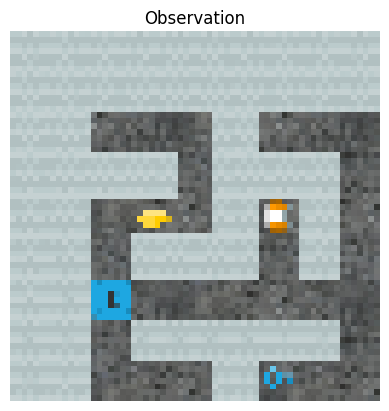

In [316]:
helpers.plot_single_observation(helpers.tensor_to_image(unchanged_obs))

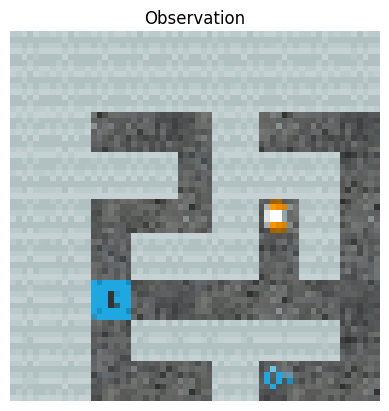

In [317]:
helpers.plot_single_observation(helpers.tensor_to_image(modified_obs))

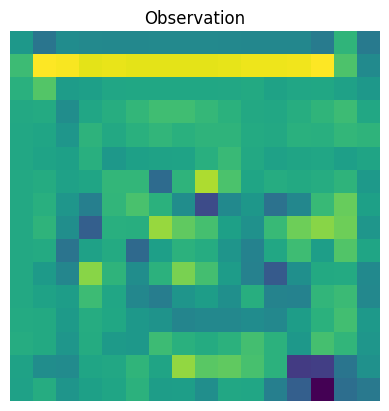

In [318]:
helpers.plot_single_observation(unmodified_activations["conv_seqs_1_res_block1_conv1"][0][0] )

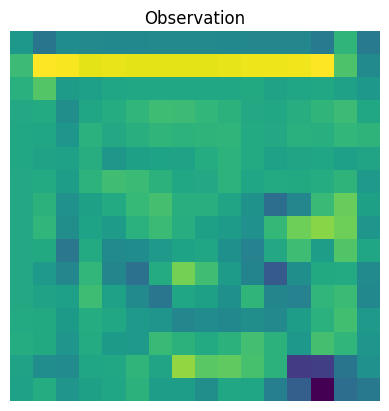

In [319]:
helpers.plot_single_observation(modified_obs_activations["conv_seqs_1_res_block1_conv1"][0][0] )

In [320]:
gem_vector = unmodified_activations["conv_seqs_1_res_block1_conv1"][0] - modified_obs_activations["conv_seqs_1_res_block1_conv1"][0]

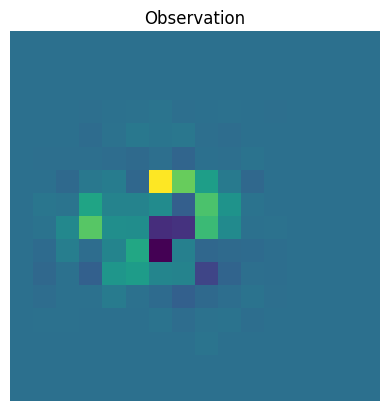

In [321]:
helpers.plot_single_observation(gem_vector[2] )


In [322]:
layer_names

['conv_seqs',
 'conv_seqs.0',
 'conv_seqs.0.conv',
 'conv_seqs.0.max_pool2d',
 'conv_seqs.0.res_block0',
 'conv_seqs.0.res_block0.conv0',
 'conv_seqs.0.res_block0.conv1',
 'conv_seqs.0.res_block1',
 'conv_seqs.0.res_block1.conv0',
 'conv_seqs.0.res_block1.conv1',
 'conv_seqs.1',
 'conv_seqs.1.conv',
 'conv_seqs.1.max_pool2d',
 'conv_seqs.1.res_block0',
 'conv_seqs.1.res_block0.conv0',
 'conv_seqs.1.res_block0.conv1',
 'conv_seqs.1.res_block1',
 'conv_seqs.1.res_block1.conv0',
 'conv_seqs.1.res_block1.conv1',
 'conv_seqs.2',
 'conv_seqs.2.conv',
 'conv_seqs.2.max_pool2d',
 'conv_seqs.2.res_block0',
 'conv_seqs.2.res_block0.conv0',
 'conv_seqs.2.res_block0.conv1',
 'conv_seqs.2.res_block1',
 'conv_seqs.2.res_block1.conv0',
 'conv_seqs.2.res_block1.conv1',
 'hidden_fc',
 'logits_fc',
 'value_fc']

In [323]:
steering_vector = gem_vector

total_reward, frames, observations2 = helpers.run_episode_with_steering_and_save_as_gif(venv, model, steering_vector, steering_layer="conv_seqs.1.res_block1.conv1", filepath=f'episode_steering.gif', save_gif=True,  episode_timeout=200)
print(f"Episode finished with total reward: {total_reward}")



total_reward, frames2, observations = helpers.run_episode_and_save_as_gif(venv, model, filepath=f'episode.gif', save_gif=True,  episode_timeout=200, is_procgen_env=True)
print(f"Episode finished with total reward: {total_reward}")

Saved gif!
Episode finished with total reward: [0.]
Episode finished with total reward: [10.]


In [1]:
from IPython.display import Image, display


# display(Image(filename='episode_steering.gif'))
# display(Image(filename='episode.gif'))